# Random Forest Feature Selection and Modeling

### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from loguru import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from pandas.api.types import is_numeric_dtype
from itertools import product
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")


In [2]:
import os
os.cpu_count()

8

In [3]:
csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':15}

### Setting columns and control combinations

In [ ]:
DROP_COLS = ['dem_att_noprivate','dem_att_nopublic','den_quartile','des_age_range','trip_stages', 'trip_duration', 'dem_population_18','dem_population_65','den_perc_hotel','den_perc_religious','den_perc_infra','des_total_length','des_degree','des_closeness','des_eigenvector']
ID_COLS =  ['id_municipality','id_taz','elevator','id_household','id_person','id_trip'] 
#CONTROLS = ['trip_purpose','trip_distance','des_age_range','den_quartile'] 
CONTROLS = ['trip_purpose','trip_distance']
CATEGORICAL = ['dem_activity','dem_hou_structure', 'dem_cohort']
EXCLUDE = DROP_COLS+ID_COLS+CONTROLS+CATEGORICAL

### Preparing data, scaling, one hot encoding, etc

In [ ]:
def prepare_data(path):

    or_data = {}
    scaler = StandardScaler()
    encoder = OneHotEncoder(drop=None, sparse_output=False)

    for dft in ('600','900','1200','1500'):
        or_data.update({dft: pd.read_parquet(path.format(di = dft))})

    for d, dft in or_data.items():

        dft.drop(columns=DROP_COLS, inplace=True)
        dft.rename(
        columns={
            w:w.replace("dens_","den_") for w in ['dens_pop_total','dens_hou_total', 'dens_far', 'dens_far_ag', 'den_perc_unbuilt','dens_built_total']},
            inplace = True)
        dft = dft[dft['trip_distance'] <= int(d)/1000]
        dft.set_index('id',inplace=True)
        
        DEMOGRAPHIC = [c for c in dft if c.startswith('dem_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DENSITY = [c for c in dft if c.startswith('den_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DESIGN = [c for c in dft if c.startswith('des_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DIVERSITY = [c for c in dft if c.startswith('div_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        ACCESSIBILITY = [c for c in dft if c.startswith('acc_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]

        numerical_features = DEMOGRAPHIC+DENSITY+DESIGN+DIVERSITY+ACCESSIBILITY

        dft[numerical_features] = dft[numerical_features].fillna(0)
        dft[numerical_features] = scaler.fit_transform(dft[numerical_features])
        dft.drop(columns=['tz_id'],inplace=True)
        dft['dem_education'] = dft['dem_education'].map({'Second - B':3, 'Second - A':2, 'First':1, 'No':0, 'Third':4})
        dft['dem_activity'] = dft['dem_activity'].map({'Retired':'retired', 'Student':'student', 'Caretaker':'caretaker', 'Worker':'worker', 'Unemployed':'unemployed'})
        dft['dem_gender'] = dft['dem_gender'].map({'Male':1,'Female':0})
        dft['dem_att_license'] = dft['dem_att_license'].map({'Yes':1,'No':0})
        dft['dem_att_card'] = dft['dem_att_card'].map({'Yes':1,'No':0})
        dft['dem_att_vehicle'] = dft['dem_att_vehicle'].map({'Yes':1,'No':0})
        dft['dem_hou_structure'] = dft['dem_hou_structure'].map(
        {'Students (Age 13–18)':'students_age13_18', 'Retirees':'retiree', 'Students (Age 6–12)':'students_age6_12',
       'Full-Time Workers':'worker', 'Other':'other', 'Students (age 19+)':'students_age19m', 'Children':'children'}
        )
                
        dft['dem_cohort'] = dft['dem_cohort'].map(
            {
                'More than 65':'more_65',
                'Ages 19-40':'ages_19-40',
                'Ages 13-18':'ages_13-18',
                'Ages 6-12':'ages_6-12',
                'Ages 41-65':'ages_41-65',
                'Less than 5':'less_5'})
        
        encoded_features = pd.DataFrame(encoder.fit_transform(dft[CATEGORICAL]), 
                                    columns=encoder.get_feature_names_out(CATEGORICAL),index=dft.index)
        dft = pd.concat([dft, encoded_features], axis = 1)
        dft = dft.drop(columns=CATEGORICAL)
        or_data.update({d:dft})

    return or_data


In [5]:
path = r"../data/extraction_{di}.parquet"
original_data = prepare_data(path)

### Setting Control Combinations

In [6]:
CONTROL_COMBINATIONS = list(original_data['1500'].trip_purpose.unique()) + ['all']

In [7]:
dist_CONTROL_COMBINATIONS = []
for v in CONTROL_COMBINATIONS:
    for d in ['600','900','1200','1500']:
        dist_CONTROL_COMBINATIONS.append(f"{d}|{v}")
        
CONTROL_COMBINATIONS = dist_CONTROL_COMBINATIONS

### Defining variables and schemas (groups)

In [8]:
SINGLE_VARIABLES = ['dem_income','dem_household_size','dem_gender','acc_transportation','den_pop_total','den_perc_unbuilt','den_perc_housing_sfr','des_mean_degree','des_straightness','des_betweenness', 'des_building_age']

In [9]:
# Define feature groups
FEATURE_GROUPS = {
    'acc_general': ['acc_care_other','acc_care_public', 'acc_school_superior', 'acc_school_basic','acc_leisure_bar', 'acc_leisure_cultural', 'acc_leisure_shows','acc_shopping_mall', 'acc_shopping_market', 'acc_shopping_alone','acc_sport_other'],
    'acc_green_areas' : ['acc_parks_S', 'acc_parks_M','acc_parks_L'],
    'den_urban_form' : ['den_far_ag','den_built_total'],
    'den_land_use_walkable' : ['den_perc_housing_ch', 'den_perc_care_other','den_perc_care_public', 'den_perc_school_superior','den_perc_school_basic', 'den_perc_leisure_bar','den_perc_leisure_cultural', 'den_perc_leisure_shows','den_perc_shopping_mall', 'den_perc_shopping_market','den_perc_shopping_alone', 'den_perc_sport_other', 'den_perc_office'],
    'den_less_walkable' : ['den_perc_industrial', 'den_perc_storage', 'den_perc_parking'],
    'div_walkable': ['div_wt_care','div_wt_school','div_wt_leisure','div_wt_shopping','div_wt_sport'],
    'div_unpaired': ['div_ut_care','div_ut_school','div_ut_leisure','div_ut_shopping','div_ut_sport'],
    'dem_attitude': ['dem_att_license','dem_att_vehicle','dem_att_card'],
    'dem_social': ['dem_education', 'dem_hou_size','dem_activity_retired','dem_activity_student',
        'dem_activity_unemployed','dem_activity_worker',
        'dem_hou_structure_children','dem_hou_structure_other',
        'dem_hou_structure_retiree','dem_hou_structure_students_age13_18',
        'dem_hou_structure_students_age6_12','dem_hou_structure_worker',
        'dem_cohort_more_65','dem_cohort_ages_19-40','dem_cohort_ages_13-18','dem_cohort_ages_6-12','dem_cohort_ages_41-65','dem_cohort_less_5']} 

In [10]:
PURPOSE_VARIABLES = {
    'Shopping':['acc_shopping_mall','acc_shopping_market','acc_shopping_alone','den_perc_shopping_mall','den_perc_shopping_market','den_perc_shopping_alone','div_wt_shopping','div_ut_shopping'],
    'Study':['acc_school_superior','acc_school_basic','den_perc_school_superior','den_perc_school_basic','div_wt_school','div_ut_school'],
    'Leisure':['acc_leisure_bar','acc_leisure_cultural','acc_leisure_shows','den_perc_leisure_bar','den_perc_leisure_cultural','den_perc_leisure_shows','div_wt_leisure','div_ut_leisure'],
    'Sport / Stroll':['acc_sport_other', 'acc_parks_S', 'acc_parks_M', 'acc_parks_L','den_perc_sport_other'],
    'Care':['acc_care_other','acc_care_public', 'den_perc_care_other', 'den_perc_care_public','div_wt_care','div_ut_care']}

### Building the final schema(s) definitions

In [11]:
COMBINATION_SCHEMA = []

In [12]:
import itertools

def merge_lists(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))


SCHEMA = {'pca_groups': None, 'single_variables': None, 'numeric_variables': None, 'categorical_variables': None, 'target_variable': None, 'control_variables': None}


def define_schemas(combination):
    results = {}
    purpose = combination.split("|")[1]
    
    for schema in ['all_features_be', 'combined_features_be', 'purpose_combined_features_be','only_purpose_features_be','only_density','only_diversity','only_accessibility','only_design']:
        if schema == 'all_features_be':
            pca_groups = None
            single_variables = [d for d in SINGLE_VARIABLES if not "dem_" in d]
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items() if not k.startswith('dem')  and v])),
            results.update({schema:
            {
            'pca_groups': None,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_be':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if not 'dem_' in k and v}
            single_variables = [d for d in SINGLE_VARIABLES if not "dem_" in d]
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'purpose_combined_features_be' and purpose != 'all':
            pca_groups = {k:[d for d in v if d not in PURPOSE_VARIABLES[purpose]] for k,v in FEATURE_GROUPS.items() if not 'dem_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if not "dem_" in d] + PURPOSE_VARIABLES[purpose]))
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_purpose_features_be' and purpose != 'all':
            pca_groups = None
            single_variables = list(set([d for d in SINGLE_VARIABLES if not "dem_" in d] + PURPOSE_VARIABLES[purpose]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_density':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'den_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if "den_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_diversity':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'div_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if "div_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_accessibility':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'acc_' in k and v}
            #
            single_variables = list(set([d for d in SINGLE_VARIABLES if "acc_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_design':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'des_' in k and v}
            #
            single_variables = list(set([d for d in SINGLE_VARIABLES if "des_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})

    for schema in ['all_features_dem', 'combined_features_dem','all_features_all','combined_features_all','purpose_features_all']:
        if schema == 'all_features_dem':
            pca_groups = None
            single_variables = [d for d in SINGLE_VARIABLES if  "dem_" in d]
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items() if k.startswith('dem')])),
            results.update({schema:
            {
            'pca_groups': None,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_dem':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if  'dem_' in k and v}
            single_variables = [d for d in SINGLE_VARIABLES if  "dem_" in d]
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'all_features_all':
            pca_groups = None
            single_variables = SINGLE_VARIABLES
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items()])),
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_all':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if v}
            single_variables = SINGLE_VARIABLES
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
    
    return results
 


### Modeling (first, control random state, sample threshold, and test size)

In [13]:
RANDOM_STATE = 42
SAMPLE_THRESHOLD = 50000
TEST_SIZE = 0.4

### Setting ModeClassifier class

In [14]:
class ModeClassifier:
    
    def __init__(self, dataset, schema, control_combination, grid_search = False):
        """
        Initialize the ModeClassifier class.

        Parameters:
        - dataset: Input dataset (pandas DataFrame).
        - schema: A dictionary with PCA groupings and single variables.
        - control_combinations: A dictionary of combinations for filtering the dataset.
        """
        self.original_dataset = dataset
        self.filtered_dataset = None
        self.schema = schema
        self.control_combinations = {'trip_purpose':control_combination.split("|")[1]}
        self.results = {}
        self.plots = None
        self.discard = False
        self.grid_search = grid_search

    def prepare_rows(self):

        filtered_data = self.original_dataset.copy()
        
        logger.info(f"Length of original dataset is {str(len(filtered_data))}")
        for key, value in self.control_combinations.items():
            if value != "all":
                filtered_data = filtered_data[filtered_data[key] == value]
        
        logger.info(f"Length of filtered dataset is {str(len(filtered_data))}")
        logger.info(f"Sample Size of filtered dataset is {str(int(filtered_data['elevator'].sum()))}")
        
        if filtered_data['elevator'].sum() < SAMPLE_THRESHOLD:
            
            logger.opt(colors=True).info(f"<r>Model is discarded for being too a little sample</r>")
            self.discard = True
        else:
            self.filtered_dataset = filtered_data
    
    def prepare_columns(self):
        
        def prepare_schema():
            columns = []
            for sch in self.schema.values():
                if not sch:
                    pass
                elif isinstance(sch,tuple): columns.append(sch[0])
                elif isinstance(sch,list): columns.append(sch)
                elif isinstance(sch,str): columns.append([sch])
            l = merge_lists(columns)
            return  sorted(list(set(l))) #Do something better than hardcoding this here
        
        if self.schema['pca_groups']:
            self.apply_pca()
            cols = prepare_schema()+['elevator','trip_mode']
            self.filtered_dataset = self.filtered_dataset[[c for c in cols if c in self.filtered_dataset.columns]]
            logger.info(f"Final schema is {", ".join(cols)}")
        else: 
            cols = prepare_schema()+['elevator','trip_mode']
            self.filtered_dataset = self.filtered_dataset[[c for c in cols if c in self.filtered_dataset.columns]]
            
            logger.info(f"Final schema is {", ".join(cols)}")
            
    def split_sample_data(self, test_size = TEST_SIZE, random_state = RANDOM_STATE):
        """
        Filter the dataset based on the provided combination and prepare feature sets.
        """

        # Split data
        X = self.filtered_dataset.drop(columns=['trip_mode'])  
        y = self.filtered_dataset['trip_mode']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) #STRATIFY TO AVOID BIAS IN UNDERSAMPLER

        undersampler = RandomUnderSampler(random_state=random_state)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        logger.info(f"Final size after undersampling is {str(len(X_train))}")
        return X_train, X_test, y_train, y_test
    
    def apply_pca(self):
        """
        Apply PCA to grouped features defined in the schema.
        """    
        
        for group_name, features in self.schema['pca_groups'].items():
            if len(features) != 0:
                pca = PCA(n_components=1)
                self.filtered_dataset[group_name] = pca.fit_transform(self.filtered_dataset[features])
        
        merged_columns = merge_lists(self.schema['pca_groups'].values())
        
        self.filtered_dataset.drop(columns= merged_columns, inplace=True)
        
    def train_model(self, model, X_train, y_train, X_test, y_test, model_name):
        """
        Train a model and compute accuracy.
        """
        
            
        if not self.grid_search:
            weights = None
            if 'elevator' in X_train.columns:
                weights = X_train['elevator'].values
                X_train = X_train.drop(columns=['elevator'])
                X_test = X_test.drop(columns=['elevator'])
            
            model.fit(X_train, y_train, sample_weight = weights)
            y_pred = model.predict(X_test)
            accuracy = round(accuracy_score(y_test, y_pred),3)
            cmatrix = confusion_matrix(y_test, y_pred)
            logger.info(f"Accuracy of {model_name} is {str(accuracy)}")
            return model, accuracy, None, cmatrix
        
        else:
            if model_name == 'Binomial Logistic Regression':
                param_grid = {
                    'C': [0.01, 1, 10],
                    'penalty': ['l2'],  
                    'solver': ['lbfgs']}
            elif model_name == 'Random Forest':
                param_grid = {
                    'n_estimators': [50, 100],
                    'max_depth': [5, 10],
                    'min_samples_split': [10,20],
                    'min_samples_leaf': [5,10]
                    }

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring="accuracy",
                cv=3,
                verbose=1,
                n_jobs=7,
            )
            
            weights = None
            if 'elevator' in X_train.columns:
                weights = X_train['elevator'].values
                X_train = X_train.drop(columns=['elevator'])
                X_test = X_test.drop(columns=['elevator'])

            grid_search.fit(X_train, y_train, sample_weight=weights)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

            y_pred = best_model.predict(X_test)
            accuracy = round(accuracy_score(y_test, y_pred), 3)
            cmatrix = confusion_matrix(y_test, y_pred)
            logger.info(f"Accuracy of {model_name} is {str(accuracy)}")
            return best_model, accuracy, best_params, cmatrix
        
    def compute_permutation_importance(self, model, X_test, y_test, model_name):
        """
        Compute permutation feature importance for a given model.

        Parameters:
        - model: Trained model.
        - X_test: Test features (unaltered, with all original columns).
        - y_test: Test labels.
        - model_name: Name of the model for logging and storage.

        Returns:
        - perm_importance: A pandas DataFrame of feature importances.
        """
        logger.info(f"Computing Permutation Importance for {model_name}")
        if 'elevator' in X_test.columns:
            X_test = X_test.drop(columns=['elevator'])

        perm_importance = permutation_importance(
            model,
            X_test,
            y_test,
            n_repeats=30,
            random_state=RANDOM_STATE,
            scoring="accuracy"
        )

        # Validate feature alignment
        if len(X_test.columns) != len(perm_importance.importances_mean):
            logger.error("Mismatch between feature names and importance values.")
            return pd.DataFrame()  # Return an empty DataFrame to handle gracefully

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            "Feature": X_test.columns,
            "Importance_Mean": perm_importance.importances_mean,
            "Importance_Std": perm_importance.importances_std
        }).sort_values(by="Importance_Mean", ascending=False)

        logger.info(f"Permutation Importance for {model_name} computed successfully")
        return importance_df
        

    def check_overfitting(self, model, X_train, X_test, y_train, y_test,  threshold=0.1):
        """Compares training and test performance to detect overfitting."""
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)

        print(f"Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")
        if train_score > test_score + threshold:
            print("Overfitting detected!")
            return True 
        else: 
            print("No overfitting.")
            return False
        
    def cross_val_performance(self, model, X_train, y_train, cv=10, std_threshold=0.08):
        """Performs cross-validation to detect instability in test performance."""
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        print(f"Cross-validation scores: {scores}")
        print(f"Mean: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")

        if np.std(scores) > std_threshold: 
            print("High variance in CV scores—potential: overfitting.")
            return True
        else:
            return False
        
    def drop_highly_correlated(self, df, target_column, correlation_threshold=0.9, columns_to_test=None):
        """
        Drops columns from the dataframe that are highly correlated with another column
        (above the specified threshold). From each pair, the column that correlates less
        with the target variable is dropped. Records the variables dropped and their correlation.

        Parameters:
            df (pd.DataFrame): Input dataframe.
            target_column (str): The target variable to determine which column to retain.
            correlation_threshold (float): Threshold above which correlation is considered high.
            columns_to_test (list, optional): List of columns to consider for correlation analysis.

        Returns:
            pd.DataFrame: DataFrame with highly correlated columns removed.
            pd.DataFrame: A record of dropped variables and their correlations.
        """
        if columns_to_test is None:
            columns_to_test = df.columns.tolist()

        # Subset the dataframe for correlation analysis
        df_to_test = df[columns_to_test]

        # Compute the correlation matrix
        corr_matrix = df_to_test.corr()

        # Identify pairs of highly correlated variables
        correlated_pairs = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):  # Only check upper triangle
                if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                    col1 = corr_matrix.columns[i]
                    col2 = corr_matrix.columns[j]
                    correlated_pairs.add((col1, col2))

        # Determine which columns to drop and record the decisions
        columns_to_drop = set()
        drop_records = []
        for col1, col2 in correlated_pairs:
            if col1 in columns_to_drop or col2 in columns_to_drop:
                continue  # Skip if either column is already marked for dropping

            # Compare correlation with the target variable
            target_corr1 = abs(df[col1].corr(df[target_column]))
            target_corr2 = abs(df[col2].corr(df[target_column]))

            if target_corr1 < target_corr2:
                columns_to_drop.add(col1)
                drop_records.append({
                    'dropped_variable': col1,
                    'kept_variable': col2,
                    'correlation_with_target': target_corr1,
                    'correlation_between': corr_matrix.loc[col1, col2]
                })
                logger.info(f"Dropped '{col1}' (correlation with target: {target_corr1:.3f}) because it is highly correlated with '{col2}' (correlation: {corr_matrix.loc[col1, col2]:.3f}).")
            else:
                columns_to_drop.add(col2)
                drop_records.append({
                    'dropped_variable': col2,
                    'kept_variable': col1,
                    'correlation_with_target': target_corr2,
                    'correlation_between': corr_matrix.loc[col1, col2]
                })
                logger.info(f"Dropped '{col2}' (correlation with target: {target_corr2:.3f}) because it is highly correlated with '{col1}' (correlation: {corr_matrix.loc[col1, col2]:.3f}).")

        # Drop the identified columns
        df_cleaned = df.drop(columns=list(columns_to_drop), inplace=False)

        # Create a DataFrame for the drop records
        drop_records_df = pd.DataFrame(drop_records)

        return df_cleaned, drop_records_df

    def process_combination(self):
        """
        Process the instance's combination, schema, and models
        """
        logger.opt(colors=True).info(f"<e>Prepare Rows</e>")
        self.prepare_rows()
        if self.discard: return
        logger.opt(colors=True).info(f"<e>Prepare Columns</e>")
        self.prepare_columns()
        if self.discard: return
        
        self.filtered_dataset, drop = self.drop_highly_correlated(
            self.filtered_dataset,
            target_column ='trip_mode',
            correlation_threshold=0.9,
            columns_to_test=[c for c in self.filtered_dataset if not c in ['trip_mode','elevator']])
        
        
        logger.opt(colors=True).info(f"<e>Split Sample Data</e>")

        X_train, X_test, y_train, y_test = self.split_sample_data()
        
        MIN_FEATURE_THRESHOLD = 2  # Minimum number of features required to proceed

        logger.opt(colors=True).info(f"<e>Train Random Forest</e>")
        features = X_train.drop(columns=['elevator']).columns.tolist()
        rf_removed_features = []

        while True:
            
            if not features:
                logger.error("No features remain for training after removing negative features.")
                return
            
            features = [f for f in features if f != 'elevator']
            X_train = X_train[features]
            X_test = X_test[features]

            rf, rf_acc, best_rf, rf_cf = self.train_model(
                RandomForestClassifier(random_state=RANDOM_STATE),
                X_train, y_train, X_test, y_test, "Random Forest"
            )

            rf_perm_importance = self.compute_permutation_importance(rf, X_test, y_test, "Random Forest")
            negative_features = rf_perm_importance[rf_perm_importance["Importance_Mean"] < 0.01 ]["Feature"].tolist() #ALSO DROP NEAR ZERO

            if not negative_features:
                break

            logger.info(f"Removing negative features: {negative_features}")
            rf_removed_features.extend(negative_features)
            #features = [f for f in features if f not in negative_features]
            features = list(set(features) - set(negative_features))
            if len(features) < MIN_FEATURE_THRESHOLD:
                logger.warning(f"Minimal features remaining ({len(features)}), model might fail.")
                break

            #X_train = X_train[features + ['elevator']]
            #X_test = X_test[features + ['elevator']]

        self.results = {
            'rf_model': rf,
            'rf_accuracy': rf_acc,
            'best_rf': best_rf,
            'train_test_overfit': self.check_overfitting(rf, X_train, X_test, y_train, y_test),
            'cv_overfit': self.cross_val_performance(rf, X_train, y_train),
            'rf_cmatrix' : rf_cf,
            'rf_perm_importance': rf_perm_importance,
            'rf_removed_features': rf_removed_features,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'drop':drop}
  
    def plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix", cmap="Blues"):
        """Plot a confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["Walking", "Motor"], yticklabels=["Walking", "Motor"])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


In [15]:
age = ['More than 65', 'Ages 41-65', 'Ages 13-18', 'Ages 6-12','Ages 19-40','Less than 5']
building_age = ['1880-1930','1960-1980', '1980-2000', '2000-2010', '1930-1960']
activity = ['retiree', 'worker', 'other', 'students_age13_18','students_age6_12','age19m','children']
density = ['den_hou_Q3', 'den_hou_Q2','den_hou_Q4', 'den_hou_Q1']
be_schemas = ['all_features_be', 'combined_features_be','purpose_combined_features_be', 'only_purpose_features_be','only_density', 'only_diversity', 'only_accessibility''only_design']
dem_schemas =  ['all_features_dem', 'combined_features_dem']

In [16]:
data_walking = {}

for k,v in original_data.items():
    dd = v.copy()
    dd.loc[dd['trip_mode'] == 'Walking','trip_mode'] = '1'
    dd.loc[dd['trip_mode'] != '1','trip_mode'] = '0'
    dd['trip_mode'] = dd['trip_mode'].astype(int)
    data_walking.update({k : dd})

In [17]:
CONTROL_COMBINATIONS

['600|Shopping',
 '900|Shopping',
 '1200|Shopping',
 '1500|Shopping',
 '600|Study',
 '900|Study',
 '1200|Study',
 '1500|Study',
 '600|Leisure',
 '900|Leisure',
 '1200|Leisure',
 '1500|Leisure',
 '600|Sport / Stroll',
 '900|Sport / Stroll',
 '1200|Sport / Stroll',
 '1500|Sport / Stroll',
 '600|Care',
 '900|Care',
 '1200|Care',
 '1500|Care',
 '600|all',
 '900|all',
 '1200|all',
 '1500|all']

### Processing all combinations

In [18]:
DISCARDED_COMBINATIONS = {}
PROCESSED_COMBINATIONS = {}
i=0
for k in CONTROL_COMBINATIONS:
    logger.opt(colors=True).info(f"<m>Processing combination walking|{k}</m>")
    data = data_walking[k.split('|')[0]]
    schemas = define_schemas(k)
    for a,s in list(schemas.items()):
                
        logger.opt(colors=True).info(f"<y>Processing schema {a}</y>")
            
        instance = ModeClassifier(data, s, k, grid_search=True)
        try:
            instance.process_combination()
        except Exception as e:
            print(f"Model failed for {k} {a}: {e}")
            instance.discard = e
            DISCARDED_COMBINATIONS.update({f"walking|{k}|{a}":e})
        
        PROCESSED_COMBINATIONS.update({f"walking|{k}|{a}": instance})    


2025-03-19 18:57:04.384 | INFO     | __main__:<module>:5 - Processing combination walking|600|Shopping
2025-03-19 18:57:04.385 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 18:57:04.387 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:04.396 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:04.409 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:04.410 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:04.411 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:04.418 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_oth

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:10.646 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.699
2025-03-19 18:57:10.646 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:17.669 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:17.680 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'den_perc_care_other', 'den_perc_school_basic', 'den_perc_housing_ch', 'den_perc_unbuilt', 'div_wt_care', 'des_mean_degree', 'acc_parks_S', 'den_perc_parking', 'den_perc_shopping_mall', 'acc_transportation', 'den_perc_shopping_alone', 'div_wt_sport', 'den_perc_storage', 'acc_shopping_market', 'des_betweenness', 'den_perc_school_superior', 'den_perc_shopping_market', 'acc_leisure_cultural', 'div_ut_care', 'acc_parks_L', 'den_perc_leisure_shows', 'acc_parks_M', 'acc_leisure_shows', 'den_perc_care_

Train Score: 0.8544, Test Score: 0.6988
Overfitting detected!


2025-03-19 18:57:18.301 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 18:57:18.307 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:18.309 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:18.314 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:18.314 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:18.314 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:18.318 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 18:57:18.338 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.66666667 0.76190476 0.85714286 0.76190476 0.52380952 0.52380952
 0.7        0.4        0.7        0.7       ]
Mean: 0.6595, Std Dev: 0.1301
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:19.467 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.722
2025-03-19 18:57:19.482 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:21.423 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:21.423 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'des_building_age', 'acc_green_areas', 'den_land_use_walkable', 'den_perc_housing_sfr', 'den_less_walkable', 'acc_transportation', 'div_unpaired', 'div_walkable', 'den_perc_unbuilt', 'des_betweenness', 'acc_general', 'den_urban_form']
2025-03-19 18:57:21.424 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8252, Test Score: 0.7223
Overfitting detected!


2025-03-19 18:57:21.979 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 18:57:21.980 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:21.983 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:21.987 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:21.988 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:21.988 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:22.001 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.71428571 0.71428571 0.85714286 0.76190476 0.57142857 0.52380952
 0.65       0.45       0.75       0.65      ]
Mean: 0.6643, Std Dev: 0.1157
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:23.189 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.697
2025-03-19 18:57:23.189 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:26.485 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:26.487 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'den_perc_shopping_mall', 'acc_green_areas', 'den_less_walkable', 'des_betweenness', 'acc_shopping_market', 'den_perc_shopping_alone', 'acc_shopping_mall', 'div_unpaired', 'den_perc_shopping_market', 'acc_shopping_alone', 'den_perc_unbuilt', 'acc_transportation', 'acc_general', 'des_mean_degree', 'div_walkable', 'div_wt_shopping', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:27.662 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.736
2025-03-19 18:57:27.662 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:27.979 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7961, Test Score: 0.7359
No overfitting.


2025-03-19 18:57:28.480 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 18:57:28.495 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:28.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:28.502 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:28.502 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:28.502 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:28.503 | INFO     | __main__:prepare_columns:62 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.80952381 0.95238095 0.85714286 0.80952381 0.61904762 0.47619048
 0.7        0.4        0.75       0.75      ]
Mean: 0.7124, Std Dev: 0.1620
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:30.058 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.722
2025-03-19 18:57:30.059 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:33.590 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:33.590 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'des_mean_degree', 'den_perc_unbuilt', 'acc_shopping_mall', 'acc_transportation', 'des_betweenness', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'den_perc_shopping_mall', 'den_perc_shopping_alone', 'den_pop_total', 'div_wt_shopping', 'acc_shopping_market', 'acc_shopping_alone']
2025-03-19 18:57:33.593 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8010, Test Score: 0.7216
No overfitting.


2025-03-19 18:57:34.643 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 18:57:34.643 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:34.645 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:34.650 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:34.651 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:34.651 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:34.656 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 18:57:34.661 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:57:34.669 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 206
2025-03-19 18:57:34.670 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.66666667 0.80952381 0.85714286 0.80952381 0.57142857 0.57142857
 0.7        0.5        0.75       0.75      ]
Mean: 0.6986, Std Dev: 0.1131
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:36.109 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.635
2025-03-19 18:57:36.110 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:36.611 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:36.614 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_pop_total', 'den_perc_unbuilt']
2025-03-19 18:57:36.614 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7913, Test Score: 0.6353
Overfitting detected!


2025-03-19 18:57:37.125 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 18:57:37.138 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:37.140 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:37.145 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:37.145 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:37.145 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:37.151 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 18:57:37.152 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:57:37.159 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 206
2025-03-19 18:57:37.160 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 18:57:37.161 | ERROR    | 

Cross-validation scores: [0.66666667 0.71428571 0.76190476 0.57142857 0.52380952 0.61904762
 0.65       0.6        0.7        0.6       ]
Mean: 0.6407, Std Dev: 0.0683
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:38.609 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.586
2025-03-19 18:57:38.619 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:38.808 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7087, Test Score: 0.5860
Overfitting detected!


2025-03-19 18:57:39.381 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 18:57:39.381 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:39.384 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:39.387 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:39.388 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:39.388 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:39.389 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 18:57:39.392 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.006) because it is highly correlated with 'des_mean_degree' (correlation: 0.972).
2025-03-19 18:57:39.394 | INFO     | __main__:p

Cross-validation scores: [0.52380952 0.71428571 0.52380952 0.57142857 0.61904762 0.42857143
 0.35       0.55       0.55       0.4       ]
Mean: 0.5231, Std Dev: 0.1018
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:40.792 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.766
2025-03-19 18:57:40.807 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:41.311 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:41.312 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:42.739 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.735
2025-03-19 18:57:42.750 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:43.307 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7476, Test Score: 0.7352
No overfitting.


2025-03-19 18:57:44.291 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 18:57:44.291 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:44.294 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:44.298 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:44.299 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:44.299 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:44.300 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.66666667 0.80952381 0.80952381 0.66666667 0.61904762 0.52380952
 0.65       0.5        0.8        0.65      ]
Mean: 0.6695, Std Dev: 0.1047
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:45.790 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.742
2025-03-19 18:57:45.803 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:51.987 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:51.997 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_cohort_ages_41-65', 'dem_hou_size', 'dem_activity_worker', 'dem_education', 'dem_hou_structure_worker', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_activity_student', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age6_12', 'dem_cohort_more_65', 'dem_hou_structure_other', 'dem_activity_retired', 'dem_att_card', 'dem_activity_unemployed', 'dem_hou_structure_students_age13_18', 'dem_att_vehicle', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:53.450 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 18:57:53.451 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:54.043 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7864, Test Score: 0.6417
Overfitting detected!


2025-03-19 18:57:55.036 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 18:57:55.037 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:57:55.040 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:57:55.044 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:57:55.045 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:57:55.045 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:57:55.051 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 18:57:55.054 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:57:55.059 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 206
2025-03-19 18:57:55.059 | INFO     | __main__:proces

Cross-validation scores: [0.52380952 0.71428571 0.9047619  0.66666667 0.61904762 0.47619048
 0.65       0.55       0.65       0.75      ]
Mean: 0.6505, Std Dev: 0.1168
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:56.541 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.77
2025-03-19 18:57:56.542 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:57.850 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:57:57.855 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:57:59.303 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 18:57:59.304 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:57:59.896 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7864, Test Score: 0.6417
Overfitting detected!


2025-03-19 18:58:00.884 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 18:58:00.888 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:00.891 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:58:00.893 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:58:00.896 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:58:00.896 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:00.898 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.52380952 0.71428571 0.9047619  0.66666667 0.61904762 0.47619048
 0.65       0.55       0.65       0.75      ]
Mean: 0.6505, Std Dev: 0.1168
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:02.616 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.713
2025-03-19 18:58:02.624 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:13.894 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:13.895 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_parking', 'div_ut_care', 'den_perc_storage', 'acc_school_superior', 'den_perc_care_other', 'dem_education', 'acc_leisure_shows', 'den_perc_school_basic', 'acc_shopping_market', 'acc_transportation', 'dem_activity_retired', 'div_wt_sport', 'dem_att_card', 'den_perc_shopping_market', 'den_perc_school_superior', 'dem_att_vehicle', 'acc_parks_S', 'den_perc_leisure_shows', 'des_mean_degree', 'acc_parks_M', 'dem_activity_unemployed', 'dem_hou_structure_children', 'dem_hou_structure_stude

Train Score: 0.8689, Test Score: 0.7131
Overfitting detected!


2025-03-19 18:58:14.532 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 18:58:14.533 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:14.536 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 18:58:14.539 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-03-19 18:58:14.540 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-03-19 18:58:14.540 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:14.559 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.71428571 0.76190476 0.85714286 0.76190476 0.57142857 0.57142857
 0.7        0.4        0.75       0.7       ]
Mean: 0.6788, Std Dev: 0.1239
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:16.078 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.732
2025-03-19 18:58:16.087 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:18.890 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:18.901 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_attitude', 'dem_social', 'dem_gender', 'den_less_walkable', 'den_land_use_walkable', 'acc_green_areas', 'des_mean_degree', 'div_unpaired', 'dem_household_size', 'den_perc_housing_sfr', 'acc_transportation', 'des_building_age', 'dem_income', 'den_perc_unbuilt', 'des_betweenness', 'den_urban_form', 'div_walkable', 'acc_general']
2025-03-19 18:58:18.901 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8738, Test Score: 0.7323
Overfitting detected!


2025-03-19 18:58:19.478 | INFO     | __main__:<module>:5 - Processing combination walking|900|Shopping
2025-03-19 18:58:19.479 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 18:58:19.480 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:19.483 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:58:19.488 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:58:19.489 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:58:19.489 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:19.491 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_oth

Cross-validation scores: [0.66666667 0.76190476 0.80952381 0.80952381 0.57142857 0.57142857
 0.75       0.5        0.75       0.8       ]
Mean: 0.6990, Std Dev: 0.1082
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:21.653 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 18:58:21.653 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:34.868 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:34.868 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'den_perc_shopping_market', 'den_pop_total', 'den_perc_leisure_shows', 'acc_parks_L', 'den_perc_leisure_cultural', 'acc_leisure_shows', 'den_perc_housing_sfr', 'acc_leisure_cultural', 'acc_shopping_alone', 'des_betweenness', 'div_wt_sport', 'den_perc_care_public', 'den_perc_unbuilt', 'den_perc_parking', 'den_perc_office', 'den_perc_housing_ch', 'den_perc_school_superior', 'div_wt_care', 'acc_school_basic', 'den_perc_industrial', 'div_wt_school', 'acc_parks_M', 'den_perc_storage', 'acc_shopping_m

Train Score: 0.8075, Test Score: 0.6543
Overfitting detected!


2025-03-19 18:58:36.351 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 18:58:36.353 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:36.355 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:58:36.361 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:58:36.363 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:58:36.363 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:36.380 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 18:58:36.388 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.51162791 0.53488372 0.62790698 0.53488372 0.55813953 0.6744186
 0.66666667 0.78571429 0.66666667 0.73809524]
Mean: 0.6299, Std Dev: 0.0882
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:38.081 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.674
2025-03-19 18:58:38.096 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:40.348 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:40.354 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'des_betweenness', 'acc_green_areas', 'den_urban_form', 'den_pop_total', 'den_land_use_walkable', 'den_perc_unbuilt', 'acc_transportation', 'div_walkable', 'den_less_walkable', 'acc_general']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:41.846 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.7
2025-03-19 18:58:41.851 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:42.231 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7183, Test Score: 0.7002
No overfitting.


2025-03-19 18:58:42.806 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 18:58:42.808 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:42.811 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:58:42.817 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:58:42.817 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:58:42.818 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:42.834 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.55813953 0.65116279 0.62790698 0.60465116 0.48837209 0.65116279
 0.5952381  0.73809524 0.52380952 0.61904762]
Mean: 0.6058, Std Dev: 0.0672
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:44.729 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.682
2025-03-19 18:58:44.731 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:48.093 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:48.097 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'den_perc_unbuilt', 'des_building_age', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'den_perc_shopping_mall', 'den_perc_shopping_alone', 'acc_green_areas', 'acc_transportation', 'den_pop_total', 'den_less_walkable', 'acc_shopping_mall', 'acc_shopping_market', 'den_land_use_walkable', 'acc_general', 'div_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:49.562 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.653
2025-03-19 18:58:49.571 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:50.193 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7770, Test Score: 0.6525
Overfitting detected!


2025-03-19 18:58:50.761 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 18:58:50.768 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:50.770 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:58:50.778 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:58:50.779 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:58:50.779 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:50.781 | INFO     | __main__:prepare_columns:62 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.58139535 0.60465116 0.69767442 0.65116279 0.51162791 0.74418605
 0.69047619 0.78571429 0.57142857 0.78571429]
Mean: 0.6624, Std Dev: 0.0895
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:52.458 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.685
2025-03-19 18:58:52.468 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:54.846 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:54.847 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'den_perc_housing_sfr', 'des_building_age', 'acc_shopping_market', 'des_betweenness', 'den_perc_shopping_market', 'acc_shopping_alone', 'acc_shopping_mall', 'den_perc_shopping_mall', 'den_pop_total', 'acc_transportation', 'den_perc_shopping_alone']
2025-03-19 18:58:54.847 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7559, Test Score: 0.6851
No overfitting.


2025-03-19 18:58:55.476 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 18:58:55.476 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:58:55.481 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:58:55.486 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:58:55.489 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:58:55.489 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:58:55.492 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 18:58:55.498 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:58:55.504 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 426
2025-03-19 18:58:55.505 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.58139535 0.55813953 0.58139535 0.60465116 0.60465116 0.72093023
 0.57142857 0.76190476 0.61904762 0.71428571]
Mean: 0.6318, Std Dev: 0.0689
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:56.992 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 18:58:56.996 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:57.623 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:58:57.627 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:58:59.211 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 18:58:59.211 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:58:59.813 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7066, Test Score: 0.6275
No overfitting.


2025-03-19 18:59:00.884 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 18:59:00.889 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:00.892 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:00.899 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:00.899 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:00.900 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:00.910 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 18:59:00.912 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:59:00.920 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 426
2025-03-19 18:59:00.920 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 18:59:00.921 | ERROR    | 

Cross-validation scores: [0.51162791 0.48837209 0.55813953 0.62790698 0.55813953 0.51162791
 0.52380952 0.61904762 0.66666667 0.57142857]
Mean: 0.5637, Std Dev: 0.0553
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:02.543 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.533
2025-03-19 18:59:02.544 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:02.740 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6925, Test Score: 0.5334
Overfitting detected!


2025-03-19 18:59:03.306 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 18:59:03.306 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:03.316 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:03.324 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:03.325 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:03.325 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:03.327 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 18:59:03.330 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.010) because it is highly correlated with 'des_straightness' (correlation: 0.973).
2025-03-19 18:59:03.332 | INFO     | __main__:p

Cross-validation scores: [0.62790698 0.53488372 0.44186047 0.53488372 0.53488372 0.69767442
 0.5        0.69047619 0.66666667 0.69047619]
Mean: 0.5920, Std Dev: 0.0884
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:04.890 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.652
2025-03-19 18:59:04.891 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:05.920 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:05.920 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:07.377 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.696
2025-03-19 18:59:07.378 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:07.765 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6878, Test Score: 0.6961
No overfitting.


2025-03-19 18:59:08.304 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 18:59:08.304 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:08.313 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:08.321 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:08.322 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:08.322 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:08.324 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.62790698 0.6744186  0.53488372 0.55813953 0.53488372 0.65116279
 0.61904762 0.71428571 0.61904762 0.69047619]
Mean: 0.6224, Std Dev: 0.0601
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:09.934 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.669
2025-03-19 18:59:09.938 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:14.684 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:14.699 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_hou_structure_students_age13_18', 'dem_hou_size', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_cohort_ages_41-65', 'dem_education', 'dem_cohort_ages_6-12', 'dem_hou_structure_children', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_activity_student', 'dem_att_card', 'dem_hou_structure_other', 'dem_att_vehicle', 'dem_hou_structure_worker', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_activity_unemployed', 'dem_activity_worker', 'dem_cohort_more_65']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:16.233 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.575
2025-03-19 18:59:16.233 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:16.866 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7371, Test Score: 0.5752
Overfitting detected!


2025-03-19 18:59:17.916 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 18:59:17.927 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:17.930 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:17.935 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:17.935 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:17.937 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:17.945 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 18:59:17.947 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 18:59:17.955 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 426
2025-03-19 18:59:17.956 | INFO     | __main__:proces

Cross-validation scores: [0.60465116 0.53488372 0.62790698 0.55813953 0.46511628 0.6744186
 0.5952381  0.69047619 0.69047619 0.61904762]
Mean: 0.6060, Std Dev: 0.0685
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:19.545 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.661
2025-03-19 18:59:19.546 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:20.461 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:20.462 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:22.008 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 18:59:22.013 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:22.955 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:22.956 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:24.501 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.575
2025-03-19 18:59:24.511 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:25.133 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7371, Test Score: 0.5752
Overfitting detected!


2025-03-19 18:59:26.201 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 18:59:26.207 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:26.209 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:26.214 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:26.216 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:26.216 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:26.219 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.60465116 0.53488372 0.62790698 0.55813953 0.46511628 0.6744186
 0.5952381  0.69047619 0.69047619 0.61904762]
Mean: 0.6060, Std Dev: 0.0685
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:28.439 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.674
2025-03-19 18:59:28.440 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:48.692 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:48.704 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'den_perc_unbuilt', 'des_betweenness', 'div_wt_leisure', 'acc_transportation', 'div_wt_school', 'den_perc_storage', 'div_wt_sport', 'den_perc_office', 'dem_activity_worker', 'acc_parks_L', 'den_perc_sport_other', 'den_pop_total', 'dem_hou_structure_worker', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_cohort_ages_19-40', 'dem_activity_student', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_cohort_ages

Train Score: 0.7934, Test Score: 0.6740
Overfitting detected!


2025-03-19 18:59:50.165 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 18:59:50.166 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:50.170 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 18:59:50.175 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-03-19 18:59:50.176 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-03-19 18:59:50.176 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:50.198 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.55813953 0.58139535 0.6744186  0.55813953 0.60465116 0.69767442
 0.64285714 0.76190476 0.71428571 0.69047619]
Mean: 0.6484, Std Dev: 0.0670
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:51.940 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.683
2025-03-19 18:59:51.948 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 18:59:55.213 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 18:59:55.214 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'dem_attitude', 'den_land_use_walkable', 'den_perc_unbuilt', 'den_less_walkable', 'des_betweenness', 'dem_social', 'den_urban_form', 'acc_transportation', 'dem_gender', 'acc_green_areas', 'dem_income', 'des_building_age', 'den_pop_total', 'dem_household_size', 'div_walkable', 'acc_general']
2025-03-19 18:59:55.214 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7817, Test Score: 0.6827
No overfitting.


2025-03-19 18:59:55.889 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Shopping
2025-03-19 18:59:55.903 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 18:59:55.903 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 18:59:55.905 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 18:59:55.911 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 18:59:55.911 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 18:59:55.915 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 18:59:55.917 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_ot

Cross-validation scores: [0.58139535 0.58139535 0.65116279 0.44186047 0.53488372 0.6744186
 0.66666667 0.78571429 0.69047619 0.71428571]
Mean: 0.6322, Std Dev: 0.0938
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 18:59:58.286 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.678
2025-03-19 18:59:58.295 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:06.403 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:06.405 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation', 'div_wt_school', 'den_perc_parking', 'acc_school_basic', 'den_perc_industrial', 'div_wt_care', 'des_betweenness', 'acc_shopping_market', 'den_perc_school_basic', 'den_perc_care_other', 'den_perc_care_public', 'acc_care_other', 'acc_shopping_mall', 'den_perc_leisure_cultural', 'acc_parks_M', 'acc_school_superior', 'acc_sport_other', 'acc_leisure_shows', 'den_perc_shopping_market', 'acc_parks_L', 'des_straightness', 'den_perc_housing_sfr', 'acc_leisure_cultural', 'den_perc_leisure_shows', 'den_p

Train Score: 0.7659, Test Score: 0.6783
No overfitting.


2025-03-19 19:00:07.336 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:00:07.336 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:07.342 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:07.347 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:07.348 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:07.348 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:07.367 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:00:07.374 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.6119403  0.64179104 0.57575758 0.63636364 0.6969697  0.75757576
 0.53030303 0.66666667 0.63636364 0.6969697 ]
Mean: 0.6451, Std Dev: 0.0614
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:09.351 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.668
2025-03-19 19:00:09.351 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:12.963 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:12.964 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'den_urban_form', 'den_perc_unbuilt', 'des_betweenness', 'acc_transportation', 'den_land_use_walkable', 'acc_green_areas', 'acc_general', 'den_perc_housing_sfr', 'den_less_walkable', 'den_pop_total']
2025-03-19 19:00:12.964 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7613, Test Score: 0.6682
No overfitting.


2025-03-19 19:00:14.481 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:00:14.488 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:14.491 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:14.498 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:14.500 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:14.500 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:14.520 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.64179104 0.64179104 0.54545455 0.62121212 0.68181818 0.77272727
 0.43939394 0.68181818 0.59090909 0.68181818]
Mean: 0.6299, Std Dev: 0.0859
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:16.696 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.67
2025-03-19 19:00:16.709 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:22.898 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:22.899 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_urban_form', 'div_walkable', 'den_land_use_walkable', 'den_less_walkable', 'acc_general', 'acc_shopping_mall', 'acc_transportation', 'den_perc_shopping_market', 'den_perc_unbuilt', 'des_mean_degree', 'acc_green_areas', 'acc_shopping_market', 'den_perc_shopping_mall', 'des_straightness', 'den_perc_housing_sfr', 'des_betweenness', 'den_perc_shopping_alone', 'den_pop_total', 'acc_shopping_alone']
2025-03-19 19:00:22.899 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fai

Train Score: 0.7402, Test Score: 0.6698
No overfitting.


2025-03-19 19:00:24.473 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:00:24.474 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:24.479 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:24.484 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:24.485 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:24.485 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:24.487 | INFO     | __main__:prepare_columns:62 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.67164179 0.62686567 0.54545455 0.57575758 0.66666667 0.78787879
 0.48484848 0.71212121 0.60606061 0.71212121]
Mean: 0.6389, Std Dev: 0.0851
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:26.341 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.659
2025-03-19 19:00:26.358 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:29.034 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:29.035 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_shopping_mall', 'des_betweenness', 'acc_shopping_market', 'acc_transportation', 'den_perc_shopping_mall', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'den_perc_shopping_alone', 'acc_shopping_alone', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:30.676 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:00:30.677 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:31.160 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7462, Test Score: 0.6171
Overfitting detected!


2025-03-19 19:00:31.790 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:00:31.796 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:31.798 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:31.806 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:31.807 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:31.807 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:31.817 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:00:31.820 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:00:31.826 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 662
2025-03-19 19:00:31.827 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.52238806 0.50746269 0.60606061 0.59090909 0.5        0.6969697
 0.60606061 0.51515152 0.63636364 0.54545455]
Mean: 0.5727, Std Dev: 0.0618
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:33.407 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.637
2025-03-19 19:00:33.419 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:34.022 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:34.026 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt']
2025-03-19 19:00:34.026 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7054, Test Score: 0.6366
No overfitting.


2025-03-19 19:00:34.621 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:00:34.622 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:34.624 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:34.631 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:34.633 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:34.633 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:34.641 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:00:34.643 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:00:34.650 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 662
2025-03-19 19:00:34.650 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:00:34.651 | ERROR    | 

Cross-validation scores: [0.65671642 0.64179104 0.56060606 0.66666667 0.68181818 0.6969697
 0.43939394 0.6969697  0.56060606 0.66666667]
Mean: 0.6268, Std Dev: 0.0781
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:36.503 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.591
2025-03-19 19:00:36.504 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:36.923 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7190, Test Score: 0.5912
Overfitting detected!


2025-03-19 19:00:38.120 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:00:38.120 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:38.126 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:38.132 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:38.136 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:38.136 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:38.138 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:00:38.142 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.009) because it is highly correlated with 'des_building_age' (correlation: 0.935).
2025-03-19 19:00:38.144 | INFO     | __main__:d

Cross-validation scores: [0.52238806 0.65671642 0.62121212 0.68181818 0.57575758 0.62121212
 0.56060606 0.63636364 0.53030303 0.57575758]
Mean: 0.5982, Std Dev: 0.0507
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:39.804 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.645
2025-03-19 19:00:39.818 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:40.636 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7341, Test Score: 0.6450
No overfitting.


2025-03-19 19:00:41.813 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:00:41.814 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:41.820 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:41.825 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:41.826 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:41.826 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:41.828 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.53731343 0.58208955 0.74242424 0.57575758 0.65151515 0.6969697
 0.54545455 0.57575758 0.59090909 0.59090909]
Mean: 0.6089, Std Dev: 0.0633
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:43.420 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.707
2025-03-19 19:00:43.428 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:47.774 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:47.774 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_size', 'dem_att_card', 'dem_cohort_ages_19-40', 'dem_hou_structure_worker', 'dem_activity_student', 'dem_cohort_ages_6-12', 'dem_cohort_ages_13-18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_hou_structure_other', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_hou_structure_students_age13_18', 'dem_gender', 'dem_hou_structure_students_age6_12', 'dem_activity_worker', 'dem_cohort_more_65', 'dem_cohort_ages_41-65', 'dem_education', 'dem_att_vehicle', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:49.450 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.671
2025-03-19 19:00:49.460 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:50.277 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7659, Test Score: 0.6714
No overfitting.


2025-03-19 19:00:51.466 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:00:51.466 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:51.473 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:51.478 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:51.482 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:51.482 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:51.491 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:00:51.494 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:00:51.501 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 662
2025-03-19 19:00:51.502 | INFO     | __main__:proces

Cross-validation scores: [0.68656716 0.64179104 0.59090909 0.63636364 0.72727273 0.68181818
 0.54545455 0.68181818 0.59090909 0.71212121]
Mean: 0.6495, Std Dev: 0.0560
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:53.245 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.707
2025-03-19 19:00:53.258 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:55.500 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:00:55.501 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:00:57.129 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.734
2025-03-19 19:00:57.134 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:00:57.730 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7251, Test Score: 0.7336
No overfitting.


2025-03-19 19:00:58.389 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:00:58.389 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:00:58.396 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:00:58.402 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:00:58.402 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:00:58.405 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:00:58.407 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.74626866 0.67164179 0.63636364 0.77272727 0.72727273 0.77272727
 0.68181818 0.68181818 0.65151515 0.62121212]
Mean: 0.6963, Std Dev: 0.0523
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:01:00.829 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.705
2025-03-19 19:01:00.829 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:01:14.124 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:01:14.125 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'div_wt_care', 'des_mean_degree', 'den_perc_school_superior', 'dem_att_vehicle', 'dem_hou_structure_worker', 'acc_sport_other', 'acc_school_basic', 'den_built_total', 'den_perc_housing_ch', 'den_perc_housing_sfr', 'den_perc_industrial', 'dem_activity_worker', 'den_perc_shopping_market', 'div_wt_sport', 'dem_hou_size', 'den_perc_shopping_mall', 'acc_leisure_cultural', 'dem_hou_structure_other', 'dem_hou_structure_students_age6_12', 'acc_parks_L', 'dem_cohort_ages_13-18', 'dem_cohort_ages_41-65', 'dem_h

Train Score: 0.7900, Test Score: 0.7046
No overfitting.


2025-03-19 19:01:15.071 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:01:15.072 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:01:15.074 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:01:15.080 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-03-19 19:01:15.083 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-03-19 19:01:15.083 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:01:15.102 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.65671642 0.64179104 0.56060606 0.62121212 0.74242424 0.75757576
 0.5        0.6969697  0.63636364 0.6969697 ]
Mean: 0.6511, Std Dev: 0.0749
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:01:17.208 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.712
2025-03-19 19:01:17.217 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:01:22.587 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:01:22.592 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'acc_green_areas', 'dem_social', 'den_urban_form', 'den_less_walkable', 'dem_gender', 'den_land_use_walkable', 'den_perc_unbuilt', 'des_betweenness', 'des_straightness', 'den_perc_housing_sfr', 'acc_transportation', 'acc_general', 'dem_household_size', 'den_pop_total']
2025-03-19 19:01:22.592 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7628, Test Score: 0.7120
No overfitting.


2025-03-19 19:01:24.082 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Shopping
2025-03-19 19:01:24.083 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:01:24.083 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:01:24.087 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:01:24.093 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:01:24.096 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:01:24.096 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:01:24.098 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_ot

Cross-validation scores: [0.68656716 0.6119403  0.60606061 0.72727273 0.71212121 0.75757576
 0.59090909 0.72727273 0.60606061 0.72727273]
Mean: 0.6753, Std Dev: 0.0609
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:01:27.083 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:01:27.084 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:01:45.161 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:01:45.163 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation', 'den_perc_care_other', 'des_straightness', 'den_perc_housing_sfr', 'acc_parks_M', 'div_ut_care', 'acc_school_basic', 'des_mean_degree', 'den_perc_leisure_cultural', 'den_perc_school_basic', 'acc_leisure_cultural', 'den_far_ag', 'acc_shopping_market', 'den_perc_unbuilt', 'acc_parks_L', 'den_perc_shopping_market', 'den_perc_storage', 'acc_parks_S', 'acc_care_other', 'den_perc_industrial', 'den_perc_leisure_bar', 'den_perc_office', 'acc_school_superior', 'des_betweenness', 'den_perc_shopping_mall

Train Score: 0.8239, Test Score: 0.6537
Overfitting detected!


2025-03-19 19:01:47.643 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:01:47.648 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:01:47.650 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:01:47.658 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:01:47.661 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:01:47.661 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:01:47.692 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:01:47.710 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.57303371 0.60674157 0.71910112 0.61797753 0.70786517 0.70786517
 0.60227273 0.64772727 0.63636364 0.65909091]
Mean: 0.6478, Std Dev: 0.0477
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:01:49.909 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.691
2025-03-19 19:01:49.918 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:01:53.940 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:01:53.952 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_urban_form', 'des_straightness', 'den_perc_unbuilt', 'den_less_walkable', 'des_mean_degree', 'acc_transportation', 'acc_green_areas', 'des_betweenness', 'acc_general', 'den_land_use_walkable', 'den_pop_total']
2025-03-19 19:01:53.952 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7517, Test Score: 0.6911
No overfitting.


2025-03-19 19:01:55.539 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:01:55.542 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:01:55.544 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:01:55.552 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:01:55.554 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:01:55.555 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:01:55.571 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.59550562 0.66292135 0.68539326 0.61797753 0.70786517 0.70786517
 0.63636364 0.61363636 0.68181818 0.68181818]
Mean: 0.6591, Std Dev: 0.0385
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:01:57.917 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.641
2025-03-19 19:01:57.918 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:02.560 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:02:02.560 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'den_perc_unbuilt', 'den_urban_form', 'acc_transportation', 'acc_green_areas', 'div_walkable', 'den_perc_shopping_market', 'des_mean_degree', 'den_perc_housing_sfr', 'des_straightness', 'den_perc_shopping_mall', 'acc_shopping_mall', 'den_perc_shopping_alone', 'des_betweenness', 'acc_shopping_market', 'den_less_walkable', 'den_pop_total', 'acc_general']
2025-03-19 19:02:02.561 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8318, Test Score: 0.6409
Overfitting detected!


2025-03-19 19:02:03.644 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:02:03.645 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:03.650 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:03.656 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:03.657 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:03.657 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:03.659 | INFO     | __main__:prepare_columns:62 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.59550562 0.60674157 0.68539326 0.68539326 0.66292135 0.69662921
 0.59090909 0.63636364 0.63636364 0.65909091]
Mean: 0.6455, Std Dev: 0.0367
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:06.003 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:02:06.011 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:11.513 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:02:11.514 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_shopping_market', 'acc_shopping_market', 'des_mean_degree', 'des_betweenness', 'acc_shopping_mall', 'des_straightness', 'den_perc_shopping_alone', 'acc_transportation', 'den_perc_unbuilt', 'den_perc_shopping_mall', 'div_wt_shopping', 'den_pop_total']
2025-03-19 19:02:11.515 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7980, Test Score: 0.6443
Overfitting detected!


2025-03-19 19:02:13.233 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:02:13.236 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:13.238 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:13.245 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:13.248 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:13.249 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:13.258 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:02:13.260 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:02:13.267 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 886
2025-03-19 19:02:13.268 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.57303371 0.68539326 0.69662921 0.61797753 0.6741573  0.69662921
 0.56818182 0.625      0.64772727 0.65909091]
Mean: 0.6444, Std Dev: 0.0450
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:14.899 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:02:14.902 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:15.698 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7540, Test Score: 0.6443
Overfitting detected!


2025-03-19 19:02:16.365 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:02:16.373 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:16.375 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:16.384 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:16.385 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:16.385 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:16.392 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:02:16.394 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:02:16.402 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 886
2025-03-19 19:02:16.402 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:02:16.403 | ERROR    | 

Cross-validation scores: [0.59550562 0.65168539 0.58426966 0.68539326 0.66292135 0.75280899
 0.60227273 0.625      0.65909091 0.68181818]
Mean: 0.6501, Std Dev: 0.0482
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:18.074 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.62
2025-03-19 19:02:18.075 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:18.298 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6998, Test Score: 0.6202
No overfitting.


2025-03-19 19:02:18.962 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:02:18.975 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:18.981 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:18.986 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:18.987 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:18.988 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:18.990 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:02:18.993 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.005) because it is highly correlated with 'des_building_age' (correlation: 0.939).
2025-03-19 19:02:18.995 | INFO     | __main__:d

Cross-validation scores: [0.58426966 0.58426966 0.68539326 0.58426966 0.59550562 0.59550562
 0.59090909 0.70454545 0.63636364 0.67045455]
Mean: 0.6231, Std Dev: 0.0447
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:20.679 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.634
2025-03-19 19:02:20.681 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:21.227 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7822, Test Score: 0.6340
Overfitting detected!


2025-03-19 19:02:21.945 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:02:21.950 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:21.952 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:21.962 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:21.963 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:21.964 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:21.966 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.59550562 0.52808989 0.69662921 0.69662921 0.64044944 0.6741573
 0.53409091 0.67045455 0.57954545 0.625     ]
Mean: 0.6241, Std Dev: 0.0596
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:23.696 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.7
2025-03-19 19:02:23.697 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:29.568 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:02:29.570 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_education', 'dem_hou_structure_worker', 'dem_activity_worker', 'dem_gender', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_other', 'dem_hou_size', 'dem_att_card', 'dem_activity_student', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_cohort_ages_19-40', 'dem_activity_unemployed', 'dem_cohort_more_65', 'dem_cohort_ages_41-65', 'dem_hou_structure_retiree', 'dem_att_vehicle', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:31.222 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.657
2025-03-19 19:02:31.226 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:31.771 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7901, Test Score: 0.6567
Overfitting detected!


2025-03-19 19:02:32.455 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:02:32.470 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:32.476 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:32.482 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:32.483 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:32.484 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:32.496 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:02:32.499 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:02:32.508 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 886
2025-03-19 19:02:32.509 | INFO     | __main__:proces

Cross-validation scores: [0.62921348 0.59550562 0.64044944 0.65168539 0.65168539 0.68539326
 0.52272727 0.64772727 0.625      0.63636364]
Mean: 0.6286, Std Dev: 0.0414
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:34.270 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.694
2025-03-19 19:02:34.286 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:35.648 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:02:35.649 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:37.556 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.684
2025-03-19 19:02:37.556 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:39.560 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:02:39.561 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:41.235 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.722
2025-03-19 19:02:41.239 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:02:42.307 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7099, Test Score: 0.7222
No overfitting.


2025-03-19 19:02:43.483 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:02:43.483 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:02:43.489 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:02:43.494 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:02:43.496 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:02:43.496 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:02:43.498 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.6741573  0.68539326 0.66292135 0.64044944 0.71910112 0.58426966
 0.64772727 0.71590909 0.625      0.61363636]
Mean: 0.6569, Std Dev: 0.0413
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:02:46.199 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.698
2025-03-19 19:02:46.208 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:08.788 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:08.788 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'des_mean_degree', 'dem_activity_worker', 'dem_household_size', 'dem_hou_structure_students_age6_12', 'dem_gender', 'acc_parks_L', 'dem_hou_structure_students_age13_18', 'den_far_ag', 'dem_activity_student', 'dem_hou_structure_children', 'dem_cohort_ages_19-40', 'dem_cohort_ages_6-12', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_other', 'den_perc_parking', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'den_perc_shopping_market', 'dem_cohort_ages_41-65', 'dem_hou_siz

Train Score: 0.7585, Test Score: 0.6980
No overfitting.


2025-03-19 19:03:10.689 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:03:10.696 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:03:10.698 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:03:10.706 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-03-19 19:03:10.706 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-03-19 19:03:10.708 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:03:10.733 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.62921348 0.65168539 0.6741573  0.61797753 0.73033708 0.76404494
 0.68181818 0.64772727 0.69318182 0.71590909]
Mean: 0.6806, Std Dev: 0.0440
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:13.073 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.71
2025-03-19 19:03:13.073 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:18.990 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:18.999 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'den_perc_unbuilt', 'dem_income', 'dem_social', 'dem_gender', 'den_urban_form', 'des_betweenness', 'acc_green_areas', 'des_mean_degree', 'acc_transportation', 'dem_household_size', 'den_land_use_walkable', 'den_perc_housing_sfr', 'den_less_walkable', 'den_pop_total', 'acc_general']
2025-03-19 19:03:18.999 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7743, Test Score: 0.7103
No overfitting.


2025-03-19 19:03:20.718 | INFO     | __main__:<module>:5 - Processing combination walking|600|Study
2025-03-19 19:03:20.719 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:03:20.719 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:03:20.722 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:03:20.726 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:03:20.728 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:03:20.728 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:03:20.730 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.61797753 0.69662921 0.69662921 0.66292135 0.73033708 0.71910112
 0.67045455 0.67045455 0.67045455 0.69318182]
Mean: 0.6828, Std Dev: 0.0302
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:23.001 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.652
2025-03-19 19:03:23.014 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:38.725 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:38.725 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'den_perc_industrial', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'acc_shopping_market', 'den_perc_storage', 'acc_care_public', 'den_perc_school_superior', 'acc_parks_M', 'acc_school_superior', 'des_building_age', 'den_perc_school_basic', 'den_perc_leisure_bar', 'acc_parks_S', 'den_far_ag', 'den_perc_shopping_mall', 'acc_transportation', 'div_wt_shopping', 'den_perc_housing_ch', 'acc_sport_other', 'acc_school_basic', 'den_perc_parking', 'den_perc_leisure_shows', 'acc_parks_L', 'acc_leisure_bar',

Train Score: 0.8473, Test Score: 0.6516
Overfitting detected!


2025-03-19 19:03:40.480 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:03:40.486 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:03:40.488 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:03:40.492 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:03:40.494 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:03:40.494 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:03:40.500 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:03:40.517 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.63636364 0.61818182 0.58181818 0.69090909 0.58181818 0.65454545
 0.58181818 0.63636364 0.67272727 0.65454545]
Mean: 0.6309, Std Dev: 0.0373
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:42.281 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.674
2025-03-19 19:03:42.281 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:44.945 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:44.952 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'des_building_age', 'den_land_use_walkable', 'div_walkable', 'den_pop_total', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:46.788 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:03:46.789 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:49.461 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:49.462 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_green_areas', 'den_less_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:51.175 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.64
2025-03-19 19:03:51.176 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:52.893 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8073, Test Score: 0.6401
Overfitting detected!


2025-03-19 19:03:54.149 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:03:54.149 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:03:54.156 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:03:54.160 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:03:54.161 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:03:54.161 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:03:54.164 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.67272727 0.74545455 0.69090909 0.65454545 0.54545455 0.69090909
 0.67272727 0.58181818 0.69090909 0.72727273]
Mean: 0.6673, Std Dev: 0.0581
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:03:56.058 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.655
2025-03-19 19:03:56.065 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:03:59.205 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:03:59.212 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'des_building_age', 'acc_transportation', 'acc_school_basic', 'acc_green_areas', 'des_betweenness', 'den_perc_housing_sfr', 'den_perc_school_basic', 'div_wt_school', 'den_perc_unbuilt', 'den_perc_school_superior', 'den_land_use_walkable', 'acc_school_superior', 'den_less_walkable', 'den_pop_total', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:00.706 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:04:00.720 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:01.198 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7691, Test Score: 0.6292
Overfitting detected!


2025-03-19 19:04:01.806 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:04:01.820 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:01.823 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:01.826 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:01.827 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:01.827 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:01.828 | INFO     | __main__:prepare_columns:62 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-03-19 19:04:01.831 | INFO     | __main__:drop_hi

Cross-validation scores: [0.61818182 0.63636364 0.56363636 0.52727273 0.58181818 0.58181818
 0.63636364 0.58181818 0.63636364 0.70909091]
Mean: 0.6073, Std Dev: 0.0482
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:03.590 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.616
2025-03-19 19:04:03.592 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:06.168 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:06.180 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_school_superior', 'acc_school_superior', 'den_perc_school_basic', 'den_perc_unbuilt', 'des_betweenness', 'des_mean_degree', 'acc_school_basic', 'des_building_age', 'acc_transportation', 'den_pop_total', 'div_wt_school']
2025-03-19 19:04:06.180 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8618, Test Score: 0.6158
Overfitting detected!


2025-03-19 19:04:06.930 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:04:06.931 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:06.934 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:06.938 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:06.939 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:06.939 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:06.946 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:04:06.948 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:04:06.956 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 550
2025-03-19 19:04:06.956 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.69090909 0.6        0.63636364 0.72727273 0.61818182 0.63636364
 0.61818182 0.63636364 0.70909091 0.67272727]
Mean: 0.6545, Std Dev: 0.0407
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:08.472 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.586
2025-03-19 19:04:08.473 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:09.124 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7582, Test Score: 0.5865
Overfitting detected!


2025-03-19 19:04:09.714 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:04:09.715 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:09.717 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:09.721 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:09.722 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:09.722 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:09.725 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:04:09.729 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:04:09.736 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 550
2025-03-19 19:04:09.737 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:04:09.738 | ERROR    | 

Cross-validation scores: [0.6        0.58181818 0.54545455 0.61818182 0.56363636 0.69090909
 0.6        0.52727273 0.63636364 0.70909091]
Mean: 0.6073, Std Dev: 0.0559
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:11.502 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.608
2025-03-19 19:04:11.508 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:11.918 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7455, Test Score: 0.6075
Overfitting detected!


2025-03-19 19:04:13.101 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:04:13.116 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:13.118 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:13.122 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:13.124 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:13.124 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:13.125 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:04:13.128 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.028) because it is highly correlated with 'des_mean_degree' (correlation: 0.962).
2025-03-19 19:04:13.129 | INFO     | __main__:p

Cross-validation scores: [0.6        0.56363636 0.6        0.61818182 0.52727273 0.6
 0.58181818 0.61818182 0.58181818 0.6       ]
Mean: 0.5891, Std Dev: 0.0260
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:14.669 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.652
2025-03-19 19:04:14.670 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:15.301 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:15.307 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:16.870 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:04:16.871 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:17.494 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7364, Test Score: 0.6458
No overfitting.


2025-03-19 19:04:18.564 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:04:18.564 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:18.567 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:18.571 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:18.572 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:18.572 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:18.574 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.76363636 0.61818182 0.58181818 0.74545455 0.63636364 0.58181818
 0.6        0.49090909 0.76363636 0.67272727]
Mean: 0.6455, Std Dev: 0.0858
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:20.131 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:04:20.136 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:24.586 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:24.587 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'dem_hou_structure_students_age13_18', 'dem_gender', 'dem_hou_structure_other', 'dem_att_license', 'dem_att_card', 'dem_hou_structure_worker', 'dem_cohort_more_65', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_cohort_less_5', 'dem_activity_worker', 'dem_cohort_ages_41-65', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age6_12']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:26.171 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:04:26.172 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:27.779 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:27.786 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:29.360 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.61
2025-03-19 19:04:29.361 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:30.612 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7436, Test Score: 0.6101
Overfitting detected!


2025-03-19 19:04:31.766 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:04:31.767 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:31.770 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:31.773 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:31.774 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:31.774 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:31.778 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:04:31.783 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:04:31.790 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 550
2025-03-19 19:04:31.791 | INFO     | __main__:proces

Cross-validation scores: [0.6        0.6        0.58181818 0.52727273 0.49090909 0.58181818
 0.67272727 0.50909091 0.6        0.61818182]
Mean: 0.5782, Std Dev: 0.0519
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:33.310 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:04:33.319 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:34.568 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:34.570 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:36.159 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.605
2025-03-19 19:04:36.160 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:36.810 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7145, Test Score: 0.6050
Overfitting detected!


2025-03-19 19:04:37.907 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:04:37.915 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:37.919 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:37.921 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:37.923 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:37.923 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:37.925 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.63636364 0.63636364 0.54545455 0.56363636 0.58181818 0.6
 0.65454545 0.52727273 0.54545455 0.67272727]
Mean: 0.5964, Std Dev: 0.0487
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:40.026 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.669
2025-03-19 19:04:40.028 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:04:52.432 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:04:52.433 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_shopping_market', 'dem_cohort_ages_6-12', 'des_mean_degree', 'div_wt_leisure', 'den_perc_industrial', 'den_perc_school_basic', 'dem_hou_structure_students_age6_12', 'den_perc_care_other', 'den_perc_shopping_alone', 'den_perc_leisure_bar', 'den_perc_office', 'den_perc_shopping_market', 'acc_parks_S', 'acc_care_other', 'dem_education', 'den_perc_housing_sfr', 'den_perc_storage', 'den_perc_shopping_mall', 'acc_care_public', 'acc_school_basic', 'dem_cohort_ages_13-18', 'acc_parks_M', 'div_wt_sport', 'dem_income', 

Train Score: 0.8036, Test Score: 0.6688
Overfitting detected!


2025-03-19 19:04:53.251 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:04:53.255 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:04:53.257 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:04:53.260 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-03-19 19:04:53.262 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-03-19 19:04:53.262 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:04:53.281 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.63636364 0.65454545 0.54545455 0.65454545 0.61818182 0.61818182
 0.6        0.6        0.81818182 0.72727273]
Mean: 0.6473, Std Dev: 0.0724
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:04:55.266 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.68
2025-03-19 19:04:55.267 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:01.497 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:05:01.499 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'dem_household_size', 'dem_social', 'acc_green_areas', 'des_mean_degree', 'den_perc_housing_sfr', 'acc_transportation', 'den_perc_unbuilt', 'des_building_age', 'dem_gender', 'acc_general', 'dem_income', 'den_less_walkable', 'dem_attitude', 'den_pop_total', 'den_land_use_walkable', 'div_walkable', 'den_urban_form']
2025-03-19 19:05:01.499 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8636, Test Score: 0.6796
Overfitting detected!


2025-03-19 19:05:02.988 | INFO     | __main__:<module>:5 - Processing combination walking|900|Study
2025-03-19 19:05:02.989 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:05:02.989 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:02.994 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:02.997 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:03.000 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:03.000 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:03.003 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.70909091 0.69090909 0.61818182 0.78181818 0.56363636 0.61818182
 0.58181818 0.63636364 0.70909091 0.65454545]
Mean: 0.6564, Std Dev: 0.0632
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:06.102 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.657
2025-03-19 19:05:06.103 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:15.359 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:05:15.361 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_basic', 'div_wt_school', 'acc_care_public', 'acc_school_basic', 'div_wt_care', 'acc_shopping_market', 'acc_care_other', 'acc_parks_M', 'acc_leisure_bar', 'den_perc_leisure_bar', 'des_building_age', 'des_straightness', 'den_perc_storage', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'den_perc_office', 'den_perc_shopping_alone', 'acc_transportation', 'den_perc_parking', 'acc_shopping_mall', 'acc_school_superior', 'div_ut_care', 'den_built_total', 'acc_leisure_shows', 'den_perc_care_public', 'den_perc_

Train Score: 0.7150, Test Score: 0.6568
No overfitting.


2025-03-19 19:05:16.524 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:05:16.531 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:16.533 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:16.538 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:16.539 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:16.539 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:16.549 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:05:16.561 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.66666667 0.63414634 0.64227642 0.63414634 0.63414634 0.63414634
 0.61788618 0.69918699 0.69672131 0.56557377]
Mean: 0.6425, Std Dev: 0.0368
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:19.022 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 19:05:19.023 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:23.605 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:05:23.605 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'den_land_use_walkable', 'den_pop_total', 'den_perc_housing_sfr', 'des_straightness', 'den_less_walkable', 'des_building_age', 'acc_green_areas', 'des_betweenness', 'den_perc_unbuilt', 'den_urban_form', 'acc_transportation', 'acc_general']
2025-03-19 19:05:23.615 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7020, Test Score: 0.6420
No overfitting.


2025-03-19 19:05:25.456 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:05:25.460 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:25.462 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:25.467 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:25.471 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:25.472 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:25.490 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.66666667 0.6097561  0.67479675 0.6097561  0.65853659 0.65853659
 0.55284553 0.6504065  0.69672131 0.59836066]
Mean: 0.6376, Std Dev: 0.0413
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:28.319 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.609
2025-03-19 19:05:28.319 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:37.567 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:05:37.568 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_superior', 'des_building_age', 'div_walkable', 'div_wt_school', 'acc_school_basic', 'acc_general', 'den_perc_housing_sfr', 'acc_school_superior', 'den_perc_unbuilt', 'den_pop_total', 'des_straightness', 'des_betweenness', 'den_urban_form', 'den_less_walkable', 'acc_transportation', 'acc_green_areas', 'den_perc_school_basic', 'den_land_use_walkable']
2025-03-19 19:05:37.568 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7948, Test Score: 0.6089
Overfitting detected!


2025-03-19 19:05:40.087 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:05:40.089 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:40.092 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:40.097 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:40.098 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:40.099 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:40.101 | INFO     | __main__:prepare_columns:62 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-03-19 19:05:40.111 | INFO     | __main__:drop_hi

Cross-validation scores: [0.69105691 0.63414634 0.66666667 0.63414634 0.66666667 0.60162602
 0.58536585 0.69105691 0.69672131 0.56557377]
Mean: 0.6433, Std Dev: 0.0445
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:42.607 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:05:42.612 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:46.947 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:05:46.949 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr', 'den_perc_school_superior', 'div_wt_school', 'den_perc_unbuilt', 'den_perc_school_basic', 'des_straightness', 'acc_school_superior', 'acc_transportation', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:48.620 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 19:05:48.628 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:49.094 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6564, Test Score: 0.6277
No overfitting.


2025-03-19 19:05:49.718 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:05:49.730 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:49.732 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:49.737 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:49.740 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:49.740 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:49.750 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:05:49.753 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:05:49.761 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1228
2025-03-19 19:05:49.761 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.63414634 0.63414634 0.66666667 0.63414634 0.67479675 0.62601626
 0.56910569 0.64227642 0.64754098 0.55737705]
Mean: 0.6286, Std Dev: 0.0358
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:51.668 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 19:05:51.668 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:53.168 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7598, Test Score: 0.6277
Overfitting detected!


2025-03-19 19:05:54.633 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:05:54.633 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:54.638 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:54.643 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:54.644 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:54.645 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:54.653 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:05:54.655 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:05:54.663 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1228
2025-03-19 19:05:54.663 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:05:54.664 | ERROR    |

Cross-validation scores: [0.6504065  0.56910569 0.64227642 0.62601626 0.6097561  0.60162602
 0.52845528 0.63414634 0.67213115 0.51639344]
Mean: 0.6050, Std Dev: 0.0493
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:05:56.715 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.574
2025-03-19 19:05:56.715 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:05:57.233 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7264, Test Score: 0.5744
Overfitting detected!


2025-03-19 19:05:58.827 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:05:58.828 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:05:58.832 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:05:58.837 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:05:58.838 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:05:58.839 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:05:58.840 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:05:58.844 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.030) because it is highly correlated with 'des_straightness' (correlation: 0.966).
2025-03-19 19:05:58.845 | INFO     | __main__:p

Cross-validation scores: [0.57723577 0.52845528 0.6097561  0.61788618 0.61788618 0.60162602
 0.52845528 0.6097561  0.63934426 0.46721311]
Mean: 0.5798, Std Dev: 0.0516
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:00.682 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.632
2025-03-19 19:06:00.694 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:06:01.782 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6621, Test Score: 0.6322
No overfitting.


2025-03-19 19:06:03.036 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:06:03.036 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:06:03.041 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:06:03.047 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:06:03.048 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:06:03.049 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:06:03.051 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.59349593 0.61788618 0.69105691 0.6504065  0.61788618 0.6504065
 0.6504065  0.63414634 0.6147541  0.57377049]
Mean: 0.6294, Std Dev: 0.0316
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:04.994 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.653
2025-03-19 19:06:04.997 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:06:16.058 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:06:16.071 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_students_age6_12', 'dem_att_vehicle', 'dem_hou_structure_other', 'dem_cohort_ages_6-12', 'dem_cohort_ages_41-65', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_cohort_more_65', 'dem_activity_retired', 'dem_hou_structure_worker', 'dem_cohort_ages_19-40', 'dem_activity_student', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_att_card', 'dem_hou_size', 'dem_gender', 'dem_att_license', 'dem_cohort_ages_13-18', 'dem_hou_structure_students_age13_18']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:17.891 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.694
2025-03-19 19:06:17.896 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:06:19.042 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6840, Test Score: 0.6944
No overfitting.


2025-03-19 19:06:20.301 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:06:20.302 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:06:20.306 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:06:20.310 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:06:20.312 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:06:20.312 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:06:20.327 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:06:20.335 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:06:20.363 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1228
2025-03-19 19:06:20.364 | INFO     | __main__:proce

Cross-validation scores: [0.60162602 0.62601626 0.62601626 0.65853659 0.64227642 0.62601626
 0.6097561  0.64227642 0.57377049 0.56557377]
Mean: 0.6172, Std Dev: 0.0284
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:22.294 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 19:06:22.295 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:06:23.803 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:06:23.812 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social', 'dem_gender', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:25.600 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.601
2025-03-19 19:06:25.601 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:06:26.256 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7484, Test Score: 0.6013
Overfitting detected!


2025-03-19 19:06:27.019 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:06:27.028 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:06:27.030 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:06:27.036 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:06:27.038 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:06:27.038 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:06:27.041 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.63414634 0.57723577 0.62601626 0.58536585 0.68292683 0.59349593
 0.59349593 0.63414634 0.6557377  0.54098361]
Mean: 0.6124, Std Dev: 0.0397
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:06:30.733 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.639
2025-03-19 19:06:30.746 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:05.231 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:07:05.236 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_ages_13-18', 'dem_hou_structure_students_age13_18', 'dem_household_size', 'dem_education', 'des_straightness', 'des_building_age', 'dem_cohort_ages_6-12', 'dem_hou_size', 'div_wt_school', 'dem_cohort_less_5', 'dem_att_vehicle', 'den_perc_shopping_alone', 'acc_care_other', 'acc_parks_L', 'dem_hou_structure_children', 'den_perc_shopping_market', 'den_perc_office', 'dem_hou_structure_other', 'dem_hou_structure_worker', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_activity_student', 'dem_cohort_a

Train Score: 0.8037, Test Score: 0.6389
Overfitting detected!


2025-03-19 19:07:07.981 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:07:07.994 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:07:07.997 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:07:08.001 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-03-19 19:07:08.003 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-03-19 19:07:08.003 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:07:08.028 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.66666667 0.64227642 0.60162602 0.66666667 0.67479675 0.63414634
 0.61788618 0.67479675 0.66393443 0.56557377]
Mean: 0.6408, Std Dev: 0.0346
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:07:10.544 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.658
2025-03-19 19:07:10.557 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:14.361 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:07:14.367 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'des_building_age', 'acc_green_areas', 'den_perc_unbuilt', 'dem_social', 'den_pop_total', 'acc_transportation', 'acc_general', 'dem_income', 'dem_attitude', 'dem_household_size', 'des_straightness', 'den_perc_housing_sfr', 'dem_gender', 'den_urban_form', 'den_less_walkable', 'des_betweenness', 'den_land_use_walkable']
2025-03-19 19:07:14.367 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7109, Test Score: 0.6582
No overfitting.


2025-03-19 19:07:15.391 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Study
2025-03-19 19:07:15.392 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:07:15.393 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:07:15.398 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:07:15.405 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:07:15.406 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:07:15.406 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:07:15.409 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.65853659 0.60162602 0.70731707 0.65853659 0.68292683 0.67479675
 0.54471545 0.66666667 0.6147541  0.56557377]
Mean: 0.6375, Std Dev: 0.0506
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:07:19.740 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.607
2025-03-19 19:07:19.740 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:37.283 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:07:37.284 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_wt_school', 'acc_sport_other', 'den_perc_care_other', 'den_perc_sport_other', 'div_wt_care', 'div_ut_care', 'acc_parks_S', 'acc_school_basic', 'den_perc_school_superior', 'acc_shopping_market', 'acc_leisure_shows', 'acc_transportation', 'acc_leisure_bar', 'acc_care_public', 'des_straightness', 'den_pop_total', 'acc_parks_M', 'acc_parks_L', 'den_perc_housing_ch', 'den_perc_shopping_market', 'den_perc_care_public', 'den_perc_leisure_cultural', 'den_far_ag', 'den_perc_housing_sfr', 'den_perc_shopping_alone', 'den

Train Score: 0.6922, Test Score: 0.6068
No overfitting.


2025-03-19 19:07:40.223 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:07:40.224 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:07:40.228 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:07:40.235 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:07:40.235 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:07:40.235 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:07:40.255 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:07:40.264 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.56770833 0.63020833 0.578125   0.59375    0.63020833 0.59895833
 0.578125   0.609375   0.63541667 0.56770833]
Mean: 0.5990, Std Dev: 0.0250
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:07:43.188 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.614
2025-03-19 19:07:43.189 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:46.232 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:07:46.233 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_urban_form', 'den_land_use_walkable', 'den_perc_housing_sfr', 'acc_transportation', 'acc_green_areas', 'des_betweenness', 'den_perc_unbuilt', 'des_mean_degree', 'des_straightness', 'den_less_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:07:48.234 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.623
2025-03-19 19:07:48.234 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:48.967 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6453, Test Score: 0.6228
No overfitting.


2025-03-19 19:07:49.713 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:07:49.713 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:07:49.718 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:07:49.724 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:07:49.725 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:07:49.726 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:07:49.744 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.59895833 0.59895833 0.56770833 0.64583333 0.609375   0.60416667
 0.56770833 0.578125   0.59895833 0.578125  ]
Mean: 0.5948, Std Dev: 0.0223
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:07:53.081 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.612
2025-03-19 19:07:53.092 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:07:57.274 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:07:57.276 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_school_basic', 'den_pop_total', 'acc_school_superior', 'des_straightness', 'acc_general', 'den_land_use_walkable', 'den_perc_school_basic', 'des_mean_degree', 'acc_green_areas', 'den_perc_housing_sfr', 'acc_transportation', 'den_perc_unbuilt', 'div_walkable', 'den_perc_school_superior', 'den_urban_form', 'den_less_walkable', 'des_betweenness']
2025-03-19 19:07:57.276 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.6828, Test Score: 0.6125
No overfitting.


2025-03-19 19:07:58.531 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:07:58.532 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:07:58.537 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:07:58.543 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:07:58.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:07:58.545 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:07:58.547 | INFO     | __main__:prepare_columns:62 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-03-19 19:07:58.556 | INFO     | __main__:drop_hi

Cross-validation scores: [0.56770833 0.625      0.56770833 0.59895833 0.65104167 0.61458333
 0.60416667 0.61979167 0.640625   0.58854167]
Mean: 0.6078, Std Dev: 0.0267
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:01.560 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.618
2025-03-19 19:08:01.569 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:04.344 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:08:04.352 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_school_superior', 'des_straightness', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_perc_school_basic', 'den_perc_school_superior', 'acc_transportation', 'des_mean_degree', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:06.488 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.614
2025-03-19 19:08:06.489 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:08.360 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7333, Test Score: 0.6144
Overfitting detected!


2025-03-19 19:08:10.092 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:08:10.093 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:10.098 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:10.103 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:10.104 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:10.105 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:10.115 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:08:10.118 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:08:10.127 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1920
2025-03-19 19:08:10.128 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.578125   0.59895833 0.55729167 0.61458333 0.609375   0.60416667
 0.59895833 0.59895833 0.609375   0.578125  ]
Mean: 0.5948, Std Dev: 0.0171
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:12.163 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.619
2025-03-19 19:08:12.164 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:13.139 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:08:13.151 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:15.288 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.608
2025-03-19 19:08:15.289 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:16.471 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7250, Test Score: 0.6075
Overfitting detected!


2025-03-19 19:08:18.354 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:08:18.354 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:18.363 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:18.371 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:18.373 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:18.373 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:18.381 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:08:18.383 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:08:18.392 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1920
2025-03-19 19:08:18.393 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:08:18.394 | ERROR    |

Cross-validation scores: [0.53125    0.58333333 0.53125    0.578125   0.5625     0.56770833
 0.546875   0.58333333 0.609375   0.5625    ]
Mean: 0.5656, Std Dev: 0.0233
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:20.524 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.567
2025-03-19 19:08:20.538 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:20.937 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6349, Test Score: 0.5668
No overfitting.


2025-03-19 19:08:22.404 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:08:22.405 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:22.411 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:22.417 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:22.418 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:22.418 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:22.420 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:08:22.423 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_building_age' (correlation with target: 0.003) because it is highly correlated with 'des_mean_degree' (correlation: 0.931).
2025-03-19 19:08:22.424 | INFO     | __main__:p

Cross-validation scores: [0.54166667 0.52604167 0.48958333 0.57291667 0.578125   0.46875
 0.52604167 0.53125    0.61458333 0.53125   ]
Mean: 0.5380, Std Dev: 0.0403
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:24.541 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.591
2025-03-19 19:08:24.542 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:25.494 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7156, Test Score: 0.5908
Overfitting detected!


2025-03-19 19:08:26.351 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:08:26.359 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:26.361 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:26.367 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:26.370 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:26.370 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:26.373 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.54166667 0.53645833 0.53125    0.61458333 0.578125   0.55208333
 0.56770833 0.55729167 0.60416667 0.55729167]
Mean: 0.5641, Std Dev: 0.0264
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:28.399 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.623
2025-03-19 19:08:28.399 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:41.114 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:08:41.115 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_education', 'dem_gender', 'dem_cohort_ages_6-12', 'dem_cohort_ages_19-40', 'dem_activity_worker', 'dem_att_card', 'dem_hou_structure_worker', 'dem_cohort_ages_41-65', 'dem_hou_structure_other', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_cohort_more_65', 'dem_att_license', 'dem_cohort_less_5', 'dem_hou_size', 'dem_hou_structure_children']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:43.306 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.614
2025-03-19 19:08:43.309 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:45.177 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6865, Test Score: 0.6140
No overfitting.


2025-03-19 19:08:46.704 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:08:46.705 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:46.709 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:46.713 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:46.717 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:46.717 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:46.726 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:08:46.729 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:08:46.737 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1920
2025-03-19 19:08:46.738 | INFO     | __main__:proce

Cross-validation scores: [0.63541667 0.56770833 0.55208333 0.65625    0.63541667 0.625
 0.65104167 0.60416667 0.59375    0.59375   ]
Mean: 0.6115, Std Dev: 0.0332
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:48.822 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.632
2025-03-19 19:08:48.824 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:08:50.569 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8292, Test Score: 0.6323
Overfitting detected!


2025-03-19 19:08:51.583 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:08:51.589 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:08:51.592 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:08:51.600 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:08:51.601 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:08:51.602 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:08:51.604 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.59375    0.63541667 0.54166667 0.64583333 0.60416667 0.63541667
 0.65104167 0.58854167 0.58333333 0.64583333]
Mean: 0.6125, Std Dev: 0.0341


2025-03-19 19:08:51.774 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_leisure' (correlation with target: 0.113) because it is highly correlated with 'den_pop_total' (correlation: -0.985).
2025-03-19 19:08:51.775 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_shopping' (correlation with target: 0.114) because it is highly correlated with 'den_pop_total' (correlation: -0.979).
2025-03-19 19:08:51.777 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'dem_activity_student' (correlation with target: 0.030) because it is highly correlated with 'dem_activity_worker' (correlation: -1.000).
2025-03-19 19:08:51.778 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'den_built_total' (correlation with target: 0.093) because it is highly correlated with 'acc_leisure_bar' (correlation: 0.902).
2025-03-19 19:08:51.779 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_building_age' (correlation with target: 0.003) because it is 

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:08:55.980 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.619
2025-03-19 19:08:55.992 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:09:13.355 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:09:13.357 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'acc_care_public', 'den_perc_housing_ch', 'div_wt_school', 'acc_leisure_bar', 'des_mean_degree', 'div_wt_leisure', 'dem_income', 'div_wt_care', 'den_perc_shopping_alone', 'den_pop_total', 'dem_att_vehicle', 'den_perc_industrial', 'den_perc_leisure_bar', 'den_perc_office', 'acc_school_basic', 'acc_shopping_market', 'acc_sport_other', 'den_perc_school_superior', 'des_straightness', 'den_perc_housing_sfr', 'div_wt_sport', 'div_ut_care', 'den_perc_shopping_market', 'den_perc_care_public', 'den_per

Train Score: 0.7255, Test Score: 0.6190
Overfitting detected!


2025-03-19 19:09:14.875 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:09:14.875 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:09:14.880 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:09:14.886 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-03-19 19:09:14.887 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-03-19 19:09:14.887 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:09:14.933 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.60416667 0.625      0.578125   0.59895833 0.63020833 0.66145833
 0.61458333 0.63020833 0.63541667 0.58333333]
Mean: 0.6161, Std Dev: 0.0242
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:09:18.157 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.62
2025-03-19 19:09:18.168 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:09:24.033 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:09:24.035 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'den_land_use_walkable', 'des_straightness', 'dem_attitude', 'den_pop_total', 'dem_gender', 'den_urban_form', 'dem_social', 'den_less_walkable', 'acc_transportation', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'acc_green_areas', 'dem_household_size', 'acc_general', 'des_mean_degree', 'des_betweenness']
2025-03-19 19:09:24.035 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8036, Test Score: 0.6197
Overfitting detected!


2025-03-19 19:09:25.734 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Study
2025-03-19 19:09:25.734 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:09:25.735 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:09:25.740 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:09:25.746 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:09:25.747 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:09:25.748 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:09:25.750 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.58854167 0.625      0.59375    0.63541667 0.625      0.625
 0.58333333 0.61458333 0.625      0.59895833]
Mean: 0.6115, Std Dev: 0.0176
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:09:30.866 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.638
2025-03-19 19:09:30.866 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:09:48.559 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:09:48.574 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_wt_school', 'den_perc_housing_ch', 'den_perc_leisure_bar', 'acc_leisure_bar', 'acc_care_public', 'div_wt_leisure', 'acc_sport_other', 'den_perc_office', 'den_perc_storage', 'den_perc_school_basic', 'acc_shopping_market', 'div_wt_care', 'acc_school_superior', 'den_perc_unbuilt', 'den_far_ag', 'den_perc_shopping_mall', 'den_perc_shopping_alone', 'acc_parks_S', 'den_pop_total', 'des_mean_degree', 'den_perc_care_public', 'acc_transportation', 'den_perc_school_superior', 'den_perc_industrial', 'den_perc_parking', '

Train Score: 0.6679, Test Score: 0.6377
No overfitting.


2025-03-19 19:09:52.007 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:09:52.007 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:09:52.014 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:09:52.020 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:09:52.021 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:09:52.021 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:09:52.041 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:09:52.050 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.61302682 0.57854406 0.60536398 0.62835249 0.58237548 0.63601533
 0.58237548 0.63218391 0.66923077 0.56923077]
Mean: 0.6097, Std Dev: 0.0304
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:09:55.559 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.622
2025-03-19 19:09:55.565 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:09:58.434 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:09:58.435 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt', 'den_less_walkable', 'des_mean_degree', 'den_pop_total', 'acc_green_areas', 'des_betweenness', 'den_land_use_walkable', 'acc_transportation', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:00.757 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:10:00.773 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:01.611 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6246, Test Score: 0.6295
No overfitting.


2025-03-19 19:10:03.205 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:10:03.212 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:03.214 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:03.222 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:03.222 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:03.224 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:03.249 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.62452107 0.57471264 0.6091954  0.61302682 0.5440613  0.61685824
 0.60536398 0.61685824 0.60384615 0.53846154]
Mean: 0.5947, Std Dev: 0.0296
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:07.310 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.608
2025-03-19 19:10:07.315 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:13.437 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:10:13.449 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'den_perc_housing_sfr', 'des_betweenness', 'des_straightness', 'den_perc_school_basic', 'acc_school_superior', 'acc_general', 'den_less_walkable', 'den_urban_form', 'den_pop_total', 'den_perc_unbuilt', 'des_mean_degree', 'den_perc_school_superior', 'acc_transportation', 'acc_green_areas']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:15.772 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:10:15.773 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:16.448 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6764, Test Score: 0.6295
No overfitting.


2025-03-19 19:10:17.449 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:10:17.454 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:17.456 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:17.464 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:17.465 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:17.465 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:17.467 | INFO     | __main__:prepare_columns:62 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-03-19 19:10:17.475 | INFO     | __main__:drop_hi

Cross-validation scores: [0.59770115 0.56704981 0.62452107 0.61685824 0.56704981 0.59003831
 0.57854406 0.59386973 0.60769231 0.53461538]
Mean: 0.5878, Std Dev: 0.0255
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:21.072 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.63
2025-03-19 19:10:21.074 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:26.052 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:10:26.054 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_basic', 'den_perc_unbuilt', 'den_pop_total', 'des_betweenness', 'acc_transportation', 'des_mean_degree', 'den_perc_school_superior', 'des_straightness', 'acc_school_superior']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:28.413 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.64
2025-03-19 19:10:28.413 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:30.177 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6902, Test Score: 0.6404
No overfitting.


2025-03-19 19:10:32.143 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:10:32.149 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:32.151 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:32.161 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:32.162 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:32.162 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:32.176 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:10:32.179 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:10:32.225 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2608
2025-03-19 19:10:32.225 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.59003831 0.59770115 0.59770115 0.63601533 0.5440613  0.58237548
 0.62835249 0.60536398 0.61153846 0.56538462]
Mean: 0.5959, Std Dev: 0.0262
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:34.741 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:10:34.754 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:36.722 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7189, Test Score: 0.6168
Overfitting detected!


2025-03-19 19:10:38.704 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:10:38.713 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:38.715 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:38.721 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:38.721 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:38.726 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:38.736 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:10:38.738 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:10:38.748 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2608
2025-03-19 19:10:38.748 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:10:38.749 | ERROR    |

Cross-validation scores: [0.63984674 0.59386973 0.61302682 0.63601533 0.56321839 0.63601533
 0.62068966 0.5862069  0.61923077 0.54615385]
Mean: 0.6054, Std Dev: 0.0306
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:41.473 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.57
2025-03-19 19:10:41.480 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:42.238 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6936, Test Score: 0.5695
Overfitting detected!


2025-03-19 19:10:44.352 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:10:44.359 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:44.361 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:44.372 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:44.373 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:44.374 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:44.375 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:10:44.379 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_building_age' (correlation with target: 0.006) because it is highly correlated with 'des_mean_degree' (correlation: 0.932).
2025-03-19 19:10:44.381 | INFO     | __main__:p

Cross-validation scores: [0.60536398 0.64750958 0.62068966 0.5862069  0.55555556 0.60536398
 0.6091954  0.58237548 0.61153846 0.56538462]
Mean: 0.5989, Std Dev: 0.0257
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:46.620 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.602
2025-03-19 19:10:46.633 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:10:47.735 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7151, Test Score: 0.6017
Overfitting detected!


2025-03-19 19:10:48.771 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:10:48.772 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:10:48.777 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:10:48.784 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:10:48.784 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:10:48.785 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:10:48.787 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.6091954  0.61302682 0.62068966 0.59003831 0.57854406 0.59386973
 0.63984674 0.58237548 0.63846154 0.56153846]
Mean: 0.6028, Std Dev: 0.0246
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:10:51.134 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.596
2025-03-19 19:10:51.139 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:11:04.734 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:11:04.735 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'dem_gender', 'dem_cohort_ages_6-12', 'dem_cohort_ages_13-18', 'dem_hou_structure_students_age13_18', 'dem_att_license', 'dem_activity_student', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_hou_structure_worker', 'dem_hou_size', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_hou_structure_other', 'dem_education', 'dem_att_card']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:11:07.007 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.602
2025-03-19 19:11:07.013 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:11:07.715 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7048, Test Score: 0.6024
Overfitting detected!


2025-03-19 19:11:08.705 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:11:08.715 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:11:08.717 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:11:08.723 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:11:08.727 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:11:08.727 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:11:08.738 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:11:08.742 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:11:08.751 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2608
2025-03-19 19:11:08.752 | INFO     | __main__:proce

Cross-validation scores: [0.6091954  0.5862069  0.62835249 0.61685824 0.58237548 0.6091954
 0.61302682 0.62835249 0.63846154 0.61153846]
Mean: 0.6124, Std Dev: 0.0168
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:11:11.405 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.592
2025-03-19 19:11:11.410 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:11:14.652 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:11:14.663 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:11:16.905 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.602
2025-03-19 19:11:16.907 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:11:17.626 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7048, Test Score: 0.6024
Overfitting detected!


2025-03-19 19:11:18.635 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:11:18.646 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:11:18.648 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:11:18.658 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:11:18.659 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:11:18.659 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:11:18.662 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.6091954  0.5862069  0.62835249 0.61685824 0.58237548 0.6091954
 0.61302682 0.62835249 0.63846154 0.61153846]
Mean: 0.6124, Std Dev: 0.0168


2025-03-19 19:11:18.822 | INFO     | __main__:process_combination:319 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:11:24.298 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.632
2025-03-19 19:11:24.298 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:12.664 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:12.665 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'den_far_ag', 'den_perc_housing_ch', 'den_perc_shopping_market', 'acc_leisure_bar', 'den_perc_shopping_mall', 'acc_school_basic', 'dem_hou_size', 'acc_sport_other', 'acc_care_public', 'den_perc_industrial', 'den_perc_care_public', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_13-18', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'div_wt_leisure', 'den_pop_total', 'den_perc_school_basic', 'acc_leisure_shows', 'div_wt_school', 'den_perc_shopping_alone', 'den_perc_unbuilt', 'den_pe

Train Score: 0.8056, Test Score: 0.6315
Overfitting detected!


2025-03-19 19:12:18.084 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:12:18.086 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:12:18.088 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:12:18.095 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-03-19 19:12:18.098 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-03-19 19:12:18.098 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:12:18.121 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.61685824 0.60153257 0.62068966 0.63601533 0.61302682 0.65517241
 0.59003831 0.62835249 0.65384615 0.58846154]
Mean: 0.6204, Std Dev: 0.0224
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:22.266 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.62
2025-03-19 19:12:22.267 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:33.301 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:33.302 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_attitude', 'den_pop_total', 'den_perc_housing_sfr', 'des_mean_degree', 'den_perc_unbuilt', 'acc_transportation', 'dem_social', 'des_straightness', 'dem_household_size', 'dem_gender', 'dem_income', 'des_betweenness', 'den_land_use_walkable', 'den_less_walkable', 'acc_green_areas']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:35.648 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:12:35.651 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:36.617 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6246, Test Score: 0.6295
No overfitting.


2025-03-19 19:12:38.214 | INFO     | __main__:<module>:5 - Processing combination walking|600|Leisure
2025-03-19 19:12:38.225 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:12:38.225 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:12:38.229 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:12:38.232 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:12:38.233 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:12:38.233 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:12:38.234 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.62452107 0.57471264 0.6091954  0.61302682 0.5440613  0.61685824
 0.60536398 0.61685824 0.60384615 0.53846154]
Mean: 0.5947, Std Dev: 0.0296
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:39.729 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.532
2025-03-19 19:12:39.738 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:46.159 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:46.167 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_ut_shopping', 'acc_parks_M', 'den_perc_shopping_alone', 'div_ut_care', 'den_perc_office', 'div_wt_care', 'acc_shopping_market', 'div_wt_school', 'den_perc_unbuilt', 'des_building_age', 'acc_parks_S', 'den_perc_leisure_shows', 'acc_school_superior', 'den_perc_storage', 'acc_care_other', 'den_perc_school_superior', 'acc_transportation', 'den_far_ag', 'den_perc_housing_ch', 'den_perc_shopping_market', 'acc_care_public', 'den_perc_leisure_bar', 'des_mean_degree', 'acc_leisure_cultural', 'acc_leisure_bar', 'den_per

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:47.615 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.613
2025-03-19 19:12:47.617 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:48.281 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:48.282 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_shopping_alone']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:49.658 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.57
2025-03-19 19:12:49.661 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:50.171 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:50.172 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_built_total', 'div_wt_leisure']
2025-03-19 19:12:50.173 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7857, Test Score: 0.5704
Overfitting detected!


2025-03-19 19:12:51.118 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:12:51.119 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:12:51.121 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:12:51.125 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:12:51.126 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:12:51.126 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:12:51.138 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:12:51.144 | INFO     | __main__:drop_highly_cor

Cross-validation scores: [0.66666667 0.66666667 0.66666667 0.66666667 0.83333333 0.5
 0.4        0.2        0.6        0.8       ]
Mean: 0.6000, Std Dev: 0.1795
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:52.449 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.556
2025-03-19 19:12:52.463 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:53.815 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:53.816 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'des_mean_degree', 'den_urban_form', 'acc_transportation', 'des_betweenness', 'den_pop_total', 'acc_general', 'den_perc_housing_sfr', 'acc_green_areas', 'des_building_age', 'den_less_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:55.205 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.588
2025-03-19 19:12:55.214 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:12:55.471 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:12:55.471 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable']
2025-03-19 19:12:55.472 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8393, Test Score: 0.5880
Overfitting detected!


2025-03-19 19:12:56.004 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:12:56.010 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:12:56.012 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:12:56.015 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:12:56.015 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:12:56.016 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:12:56.028 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_m

Cross-validation scores: [0.66666667 1.         0.83333333 0.5        0.66666667 0.66666667
 0.6        0.8        1.         1.        ]
Mean: 0.7733, Std Dev: 0.1724
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:12:57.455 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.518
2025-03-19 19:12:57.463 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:00.672 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:00.673 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'des_betweenness', 'div_walkable', 'acc_general', 'acc_leisure_cultural', 'den_perc_leisure_cultural', 'acc_transportation', 'div_wt_leisure', 'acc_green_areas', 'acc_leisure_bar', 'des_building_age', 'den_perc_leisure_shows', 'den_land_use_walkable', 'des_mean_degree', 'den_perc_housing_sfr', 'acc_leisure_shows', 'den_perc_unbuilt', 'den_perc_leisure_bar']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:02.040 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.683
2025-03-19 19:13:02.056 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:02.449 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6607, Test Score: 0.6831
No overfitting.


2025-03-19 19:13:03.410 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:13:03.410 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:03.413 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:03.416 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:03.416 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:03.416 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:03.417 | INFO     | __main__:prepare_columns:62 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-03-19

Cross-validation scores: [0.16666667 0.5        0.66666667 0.66666667 0.33333333 0.66666667
 0.4        0.4        0.2        0.6       ]
Mean: 0.4600, Std Dev: 0.1806
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:04.864 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.556
2025-03-19 19:13:04.865 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:06.958 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:06.960 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'acc_transportation', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'den_perc_leisure_cultural', 'des_mean_degree', 'den_perc_leisure_bar', 'acc_leisure_shows']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:08.373 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.528
2025-03-19 19:13:08.373 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:09.427 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:09.428 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'des_building_age', 'den_perc_housing_sfr', 'des_betweenness', 'div_wt_leisure', 'acc_leisure_bar']
2025-03-19 19:13:09.429 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8393, Test Score: 0.5282
Overfitting detected!


2025-03-19 19:13:10.390 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:13:10.391 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:10.393 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:10.397 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:10.397 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:10.397 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:10.400 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:13:10.406 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:13:10.410 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 56
2025-03-19 19:13:10.411 | INFO     | __main__:process_combination:319 - Train R

Cross-validation scores: [0.83333333 1.         0.66666667 0.66666667 0.33333333 0.5
 0.4        0.8        0.4        0.8       ]
Mean: 0.6400, Std Dev: 0.2118
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:11.816 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.623
2025-03-19 19:13:11.816 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:12.155 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:12.162 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:13.527 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.489
2025-03-19 19:13:13.528 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:13.770 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:13.771 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'den_pop_total']
2025-03-19 19:13:13.772 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8036, Test Score: 0.4894
Overfitting detected!


2025-03-19 19:13:14.372 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:13:14.373 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:14.375 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:14.379 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:14.380 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:14.381 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:14.386 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:13:14.388 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:13:14.392 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 56
2025-03-19 19:13:14.393 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:13:14.393 | ERROR    | __m

Cross-validation scores: [0.66666667 0.83333333 0.66666667 0.5        0.5        0.66666667
 0.4        0.6        0.8        0.8       ]
Mean: 0.6433, Std Dev: 0.1375
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:15.836 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.43
2025-03-19 19:13:15.838 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:16.020 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:16.030 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation']
2025-03-19 19:13:16.030 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.6964, Test Score: 0.4296
Overfitting detected!


2025-03-19 19:13:16.989 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:13:16.991 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:16.993 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:16.996 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:16.997 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:16.997 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:16.998 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:13:17.000 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.035) because it is highly correlated with 'des_mean_degree' (correlation: 0.962).
2025-03-19 19:13:17.002 | INFO     | __main__:pro

Cross-validation scores: [0.16666667 0.33333333 0.33333333 0.33333333 0.83333333 0.66666667
 0.6        0.4        0.8        0.8       ]
Mean: 0.5267, Std Dev: 0.2294
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:18.402 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.486
2025-03-19 19:13:18.415 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:18.900 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:18.900 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'des_mean_degree', 'des_building_age']
2025-03-19 19:13:18.901 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7143, Test Score: 0.4859
Overfitting detected!


2025-03-19 19:13:19.836 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:13:19.848 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:19.850 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:19.852 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:19.854 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:19.854 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:19.855 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_s

Cross-validation scores: [0.5        0.83333333 0.66666667 0.83333333 0.33333333 0.66666667
 0.6        0.6        0.8        0.6       ]
Mean: 0.6433, Std Dev: 0.1484
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:21.322 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.553
2025-03-19 19:13:21.324 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:23.579 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:23.594 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'dem_activity_unemployed', 'dem_activity_student', 'dem_att_card', 'dem_cohort_ages_13-18', 'dem_cohort_ages_19-40', 'dem_activity_worker', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_cohort_less_5', 'dem_cohort_ages_6-12', 'dem_hou_structure_other', 'dem_hou_structure_worker', 'dem_hou_structure_children', 'dem_cohort_ages_41-65', 'dem_hou_size', 'dem_household_size', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_gender', 'dem_att_vehicle', 'dem_cohort_mor

Train Score: 0.7321, Test Score: 0.5528
Overfitting detected!


2025-03-19 19:13:24.085 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:13:24.098 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:24.101 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:24.104 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:24.105 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:24.105 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:24.108 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:13:24.112 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:13:24.117 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 56
2025-03-19 19:13:24.118 | INFO     | __main__:process_c

Cross-validation scores: [0.66666667 0.83333333 0.66666667 0.5        0.83333333 0.83333333
 0.8        0.4        0.6        0.6       ]
Mean: 0.6733, Std Dev: 0.1444
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:25.466 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.518
2025-03-19 19:13:25.482 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:26.033 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:26.035 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_social', 'dem_gender', 'dem_attitude', 'dem_income']
2025-03-19 19:13:26.036 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8750, Test Score: 0.5176
Overfitting detected!


2025-03-19 19:13:26.619 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:13:26.619 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:26.622 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:26.625 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:26.625 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:26.626 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:26.627 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activit

Cross-validation scores: [0.66666667 0.66666667 0.5        0.66666667 0.66666667 0.66666667
 0.8        0.6        0.4        0.6       ]
Mean: 0.6233, Std Dev: 0.1033
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:28.165 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.486
2025-03-19 19:13:28.179 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:34.997 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:35.004 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_basic', 'acc_leisure_bar', 'den_far_ag', 'div_ut_care', 'den_perc_shopping_alone', 'acc_transportation', 'acc_shopping_alone', 'den_perc_office', 'den_perc_housing_ch', 'den_perc_parking', 'dem_household_size', 'dem_education', 'dem_hou_size', 'des_building_age', 'den_perc_leisure_bar', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'dem_cohort_ages_41-65', 'den_perc_school_superior', 'des_betweenness', 'div_wt_sport', 'div_wt_leisure', 'dem_hou_structure_students_age13_18', 'acc_parks_M', 'ac

Train Score: 0.9107, Test Score: 0.4859
Overfitting detected!


2025-03-19 19:13:35.528 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:13:35.538 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:35.540 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:13:35.543 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-03-19 19:13:35.544 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-03-19 19:13:35.544 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:35.562 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, 

Cross-validation scores: [0.5        0.83333333 0.5        0.66666667 0.5        0.5
 0.4        0.4        0.4        0.6       ]
Mean: 0.5300, Std Dev: 0.1303
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:37.109 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.528
2025-03-19 19:13:37.110 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:39.744 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:39.750 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'des_building_age', 'des_mean_degree', 'acc_green_areas', 'dem_gender', 'den_urban_form', 'den_land_use_walkable', 'acc_general', 'dem_social', 'dem_attitude', 'div_walkable', 'den_perc_housing_sfr', 'den_pop_total', 'acc_transportation', 'den_perc_unbuilt', 'des_betweenness', 'dem_income']
2025-03-19 19:13:39.750 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8036, Test Score: 0.5282
Overfitting detected!


2025-03-19 19:13:40.676 | INFO     | __main__:<module>:5 - Processing combination walking|900|Leisure
2025-03-19 19:13:40.690 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:13:40.690 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:40.693 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:13:40.698 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:13:40.699 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:13:40.699 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:40.700 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.66666667 0.83333333 0.66666667 0.66666667 0.5        0.66666667
 0.4        0.8        0.4        0.6       ]
Mean: 0.6200, Std Dev: 0.1408
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:42.242 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.636
2025-03-19 19:13:42.243 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:46.889 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:46.892 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'den_perc_shopping_market', 'acc_shopping_market', 'div_wt_sport', 'den_perc_storage', 'acc_parks_M', 'den_perc_housing_sfr', 'den_far_ag', 'den_perc_office', 'acc_leisure_cultural', 'den_perc_leisure_cultural', 'den_perc_leisure_shows', 'acc_parks_L', 'den_perc_shopping_mall', 'acc_care_other', 'acc_leisure_bar', 'den_pop_total', 'div_wt_shopping', 'den_perc_parking', 'des_building_age', 'den_perc_school_superior', 'den_perc_care_public', 'acc_sport_other', 'des_straightness', 'den_perc_shopping

Train Score: 0.8947, Test Score: 0.6356
Overfitting detected!


2025-03-19 19:13:47.462 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:13:47.464 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:47.467 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:13:47.471 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:13:47.472 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:13:47.472 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:47.488 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:13:47.493 | INFO     | __main__:drop_highly_cor

Cross-validation scores: [0.58333333 0.75       0.75       0.5        0.36363636 0.54545455
 0.36363636 0.81818182 0.63636364 0.45454545]
Mean: 0.5765, Std Dev: 0.1532
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:48.990 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.636
2025-03-19 19:13:48.996 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:51.286 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:51.302 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'den_pop_total', 'den_land_use_walkable', 'acc_green_areas', 'des_straightness', 'acc_transportation', 'den_less_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:52.686 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.604
2025-03-19 19:13:52.699 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:53.389 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:53.390 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'den_perc_housing_sfr', 'div_walkable', 'den_perc_unbuilt', 'den_urban_form', 'acc_general']
2025-03-19 19:13:53.390 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8596, Test Score: 0.6037
Overfitting detected!


2025-03-19 19:13:53.904 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:13:53.915 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:53.919 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:13:53.922 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:13:53.923 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:13:53.923 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:53.935 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_m

Cross-validation scores: [0.5        0.66666667 0.66666667 0.5        0.18181818 0.72727273
 0.72727273 0.72727273 0.54545455 0.36363636]
Mean: 0.5606, Std Dev: 0.1720
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:55.473 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:13:55.475 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:13:57.635 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:13:57.645 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_green_areas', 'acc_transportation', 'acc_leisure_bar', 'des_betweenness', 'den_perc_leisure_cultural', 'des_building_age', 'den_perc_unbuilt', 'des_straightness', 'acc_leisure_shows', 'den_perc_housing_sfr', 'den_perc_leisure_shows', 'den_less_walkable', 'den_urban_form', 'acc_general', 'den_pop_total', 'den_land_use_walkable', 'den_perc_leisure_bar', 'acc_leisure_cultural']
2025-03-19 19:13:57.645 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8772, Test Score: 0.6543
Overfitting detected!


2025-03-19 19:13:58.185 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:13:58.191 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:13:58.194 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:13:58.199 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:13:58.200 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:13:58.200 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:13:58.202 | INFO     | __main__:prepare_columns:62 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-03-19

Cross-validation scores: [0.58333333 0.5        0.58333333 0.5        0.27272727 0.54545455
 0.36363636 0.81818182 0.63636364 0.54545455]
Mean: 0.5348, Std Dev: 0.1400
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:13:59.651 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.625
2025-03-19 19:13:59.659 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:01.890 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:01.898 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'acc_leisure_cultural', 'des_betweenness', 'acc_leisure_shows', 'den_perc_leisure_shows', 'den_perc_leisure_bar', 'den_pop_total', 'den_perc_leisure_cultural']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:03.285 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.609
2025-03-19 19:14:03.286 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:03.887 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:03.895 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_leisure_bar', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:05.276 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 19:14:05.276 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:05.794 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7368, Test Score: 0.6277
Overfitting detected!


2025-03-19 19:14:06.758 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:14:06.758 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:06.763 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:06.767 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:06.768 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:06.768 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:06.775 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:14:06.778 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:14:06.783 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 114
2025-03-19 19:14:06.784 | INFO     | __main__:process_combination:319 - Train 

Cross-validation scores: [0.75       0.5        0.58333333 0.5        0.36363636 0.63636364
 0.63636364 0.72727273 0.45454545 0.54545455]
Mean: 0.5697, Std Dev: 0.1151
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:08.226 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.612
2025-03-19 19:14:08.229 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:08.777 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:08.779 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:10.209 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.731
2025-03-19 19:14:10.209 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:10.475 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6930, Test Score: 0.7314
No overfitting.


2025-03-19 19:14:10.993 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:14:10.993 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:10.996 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:11.000 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:11.002 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:11.002 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:11.007 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:14:11.009 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:14:11.013 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 114
2025-03-19 19:14:11.014 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:14:11.015 | ERROR    | __

Cross-validation scores: [0.58333333 0.66666667 0.41666667 0.5        0.18181818 0.45454545
 0.63636364 0.45454545 0.45454545 0.54545455]
Mean: 0.4894, Std Dev: 0.1299
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:12.463 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.495
2025-03-19 19:14:12.469 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:12.674 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:12.678 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation']
2025-03-19 19:14:12.678 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7368, Test Score: 0.4947
Overfitting detected!


2025-03-19 19:14:13.693 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:14:13.693 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:13.697 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:13.701 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:13.701 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:13.702 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:13.703 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:14:13.705 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.036) because it is highly correlated with 'des_straightness' (correlation: 0.963).
2025-03-19 19:14:13.706 | INFO     | __main__:pro

Cross-validation scores: [0.5        0.58333333 0.41666667 0.25       0.45454545 0.54545455
 0.45454545 0.45454545 0.54545455 0.45454545]
Mean: 0.4659, Std Dev: 0.0878
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:15.117 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.553
2025-03-19 19:14:15.118 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:15.675 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:15.676 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:17.189 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.572
2025-03-19 19:14:17.190 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:17.548 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7193, Test Score: 0.5718
Overfitting detected!


2025-03-19 19:14:18.494 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:14:18.494 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:18.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:18.502 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:18.503 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:18.504 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:18.505 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_s

Cross-validation scores: [0.58333333 0.58333333 0.5        0.75       0.45454545 0.36363636
 0.63636364 0.36363636 0.72727273 0.45454545]
Mean: 0.5417, Std Dev: 0.1306
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:19.971 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:14:19.977 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:22.502 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:22.513 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_ages_19-40', 'dem_household_size', 'dem_att_vehicle', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_activity_unemployed', 'dem_hou_structure_other', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_hou_size', 'dem_att_license', 'dem_att_card', 'dem_activity_worker', 'dem_hou_structure_worker', 'dem_activity_retired', 'dem_gender', 'dem_income', 'dem_activity_student', 'dem_cohort_ages_41-65', 'dem_education', 'de

Train Score: 0.6404, Test Score: 0.6543
No overfitting.


2025-03-19 19:14:23.010 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:14:23.011 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:23.015 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:23.020 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:23.020 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:23.020 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:23.025 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:14:23.027 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:14:23.033 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 114
2025-03-19 19:14:23.034 | INFO     | __main__:process_

Cross-validation scores: [0.58333333 0.5        0.5        0.66666667 0.36363636 0.72727273
 0.72727273 0.54545455 0.81818182 0.45454545]
Mean: 0.5886, Std Dev: 0.1354
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:24.352 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.62
2025-03-19 19:14:24.364 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:24.954 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:24.954 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_household_size', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:26.289 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.612
2025-03-19 19:14:26.290 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:26.558 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:26.560 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'dem_attitude']
2025-03-19 19:14:26.560 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7281, Test Score: 0.6117
Overfitting detected!


2025-03-19 19:14:27.093 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:14:27.093 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:27.097 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:27.101 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:27.102 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:27.102 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:27.104 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activit

Cross-validation scores: [0.5        0.33333333 0.58333333 0.5        0.18181818 0.54545455
 0.63636364 0.72727273 0.63636364 0.27272727]
Mean: 0.4917, Std Dev: 0.1667
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:28.847 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.606
2025-03-19 19:14:28.848 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:39.481 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:39.485 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_more_65', 'dem_att_license', 'dem_activity_retired', 'dem_hou_size', 'dem_hou_structure_children', 'dem_activity_student', 'acc_leisure_shows', 'acc_parks_L', 'acc_leisure_cultural', 'dem_cohort_ages_13-18', 'dem_att_card', 'dem_cohort_ages_19-40', 'dem_cohort_ages_6-12', 'dem_activity_worker', 'dem_activity_unemployed', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_other', 'dem_hou_structure_worker', 'dem_cohort_less_5', 'dem_hou_structure_students_age6_12', 'dem_gender', 'den_perc_leisure_

Train Score: 0.8509, Test Score: 0.6064
Overfitting detected!


2025-03-19 19:14:40.500 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:14:40.510 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:40.512 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:14:40.517 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-03-19 19:14:40.519 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-03-19 19:14:40.519 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:40.536 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, 

Cross-validation scores: [0.66666667 0.5        0.66666667 0.5        0.27272727 0.54545455
 0.45454545 0.72727273 0.63636364 0.54545455]
Mean: 0.5515, Std Dev: 0.1253
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:41.966 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 19:14:41.966 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:44.077 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:44.081 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'des_building_age', 'den_urban_form', 'dem_attitude', 'den_perc_unbuilt', 'den_pop_total', 'des_straightness', 'acc_transportation', 'dem_income', 'acc_green_areas', 'den_perc_housing_sfr', 'des_betweenness', 'dem_household_size', 'dem_gender', 'dem_social', 'den_land_use_walkable', 'acc_general', 'den_less_walkable']
2025-03-19 19:14:44.081 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8947, Test Score: 0.6277
Overfitting detected!


2025-03-19 19:14:44.616 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Leisure
2025-03-19 19:14:44.616 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:14:44.617 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:44.621 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:14:44.626 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:14:44.627 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:14:44.627 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:44.628 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_othe

Cross-validation scores: [0.5        0.41666667 0.58333333 0.5        0.27272727 0.72727273
 0.45454545 0.81818182 0.63636364 0.45454545]
Mean: 0.5364, Std Dev: 0.1510
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:46.291 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.594
2025-03-19 19:14:46.293 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:54.032 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:54.033 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_shopping_market', 'den_perc_school_basic', 'den_far_ag', 'div_wt_sport', 'den_perc_housing_ch', 'den_perc_shopping_market', 'den_perc_unbuilt', 'acc_shopping_mall', 'den_perc_office', 'des_mean_degree', 'den_perc_housing_sfr', 'div_wt_school', 'div_ut_care', 'acc_care_public', 'den_perc_sport_other', 'des_building_age', 'acc_school_basic', 'den_perc_industrial', 'acc_care_other', 'acc_sport_other', 'acc_transportation', 'acc_parks_L', 'acc_leisure_shows', 'acc_leisure_bar', 'den_perc_school_superior', 'den_per

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:55.506 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.587
2025-03-19 19:14:55.507 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:14:56.254 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:14:56.254 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'des_straightness', 'den_perc_leisure_bar', 'div_wt_care']
2025-03-19 19:14:56.255 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7979, Test Score: 0.5868
Overfitting detected!


2025-03-19 19:14:57.279 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:14:57.281 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:14:57.285 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:14:57.290 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:14:57.291 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:14:57.291 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:14:57.303 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:14:57.308 | INFO     | __main__:drop_highly_co

Cross-validation scores: [0.63157895 0.73684211 0.68421053 0.36842105 0.52631579 0.89473684
 0.47368421 0.47368421 0.55555556 0.44444444]
Mean: 0.5789, Std Dev: 0.1505
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:14:58.751 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.557
2025-03-19 19:14:58.765 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:00.253 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:00.254 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'div_walkable', 'den_less_walkable', 'des_mean_degree', 'des_building_age', 'den_perc_unbuilt', 'den_land_use_walkable', 'acc_green_areas', 'den_pop_total', 'den_perc_housing_sfr', 'acc_transportation']
2025-03-19 19:15:00.255 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8777, Test Score: 0.5571
Overfitting detected!


2025-03-19 19:15:00.829 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:15:00.830 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:00.834 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:00.839 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:00.840 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:00.840 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:00.853 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_

Cross-validation scores: [0.47368421 0.68421053 0.47368421 0.57894737 0.47368421 0.68421053
 0.42105263 0.52631579 0.44444444 0.44444444]
Mean: 0.5205, Std Dev: 0.0922
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:02.320 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.573
2025-03-19 19:15:02.321 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:04.696 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:04.697 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable', 'acc_transportation', 'den_perc_housing_sfr', 'des_straightness', 'des_building_age', 'div_walkable', 'den_land_use_walkable', 'acc_green_areas', 'den_perc_leisure_bar', 'den_perc_unbuilt', 'den_urban_form', 'acc_leisure_shows', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'den_pop_total', 'den_perc_leisure_cultural']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:06.112 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.584
2025-03-19 19:15:06.114 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:06.603 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:06.617 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_leisure_bar', 'des_mean_degree', 'acc_general']
2025-03-19 19:15:06.617 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8351, Test Score: 0.5845
Overfitting detected!


2025-03-19 19:15:07.155 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:15:07.169 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:07.171 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:07.176 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:07.178 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:07.178 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:07.179 | INFO     | __main__:prepare_columns:62 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-03-1

Cross-validation scores: [0.63157895 0.63157895 0.68421053 0.52631579 0.31578947 0.68421053
 0.52631579 0.47368421 0.44444444 0.55555556]
Mean: 0.5474, Std Dev: 0.1106
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:08.792 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.61
2025-03-19 19:15:08.799 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:11.394 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:11.395 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'des_straightness', 'acc_leisure_bar', 'acc_leisure_shows', 'den_perc_leisure_shows', 'den_perc_housing_sfr', 'des_betweenness', 'den_perc_leisure_cultural', 'des_building_age', 'den_pop_total', 'acc_leisure_cultural']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:12.770 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.495
2025-03-19 19:15:12.781 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:13.358 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:13.358 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_bar', 'des_mean_degree', 'acc_transportation']
2025-03-19 19:15:13.359 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7128, Test Score: 0.4954
Overfitting detected!


2025-03-19 19:15:14.334 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:15:14.335 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:14.338 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:14.344 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:14.345 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:14.345 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:14.352 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:15:14.353 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:15:14.359 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 188
2025-03-19 19:15:14.359 | INFO     | __main__:process_combination:319 - Train

Cross-validation scores: [0.57894737 0.63157895 0.42105263 0.36842105 0.57894737 0.68421053
 0.47368421 0.52631579 0.44444444 0.61111111]
Mean: 0.5319, Std Dev: 0.0969
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:15.696 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.532
2025-03-19 19:15:15.710 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:16.103 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:16.104 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'den_perc_unbuilt']
2025-03-19 19:15:16.104 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8085, Test Score: 0.5320
Overfitting detected!


2025-03-19 19:15:16.717 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:15:16.717 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:16.722 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:16.727 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:16.728 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:16.728 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:16.734 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:15:16.735 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:15:16.740 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 188
2025-03-19 19:15:16.741 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:15:16.742 | ERROR    | _

Cross-validation scores: [0.57894737 0.73684211 0.68421053 0.36842105 0.63157895 0.73684211
 0.47368421 0.52631579 0.55555556 0.55555556]
Mean: 0.5848, Std Dev: 0.1107
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:18.160 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.384
2025-03-19 19:15:18.161 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:18.284 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:18.299 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation']
2025-03-19 19:15:18.300 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.6543, Test Score: 0.3836
Overfitting detected!


2025-03-19 19:15:18.851 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:15:18.851 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:18.856 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:18.860 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:18.861 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:18.861 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:18.862 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:15:18.864 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:15:18.870 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 188
2025-03-19 19:15:18.870 | INFO     | __main__:process_combinati

Cross-validation scores: [0.57894737 0.73684211 0.57894737 0.57894737 0.63157895 0.57894737
 0.47368421 0.57894737 0.55555556 0.77777778]
Mean: 0.6070, Std Dev: 0.0843
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:20.232 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.564
2025-03-19 19:15:20.248 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:20.851 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:20.864 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:22.219 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.598
2025-03-19 19:15:22.231 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:22.615 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7181, Test Score: 0.5982
Overfitting detected!


2025-03-19 19:15:23.149 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:15:23.150 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:23.155 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:23.159 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:23.160 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:23.160 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:23.162 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_

Cross-validation scores: [0.68421053 0.63157895 0.63157895 0.52631579 0.26315789 0.63157895
 0.42105263 0.47368421 0.44444444 0.5       ]
Mean: 0.5208, Std Dev: 0.1218
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:24.647 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.589
2025-03-19 19:15:24.648 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:28.860 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:28.872 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_size', 'dem_cohort_ages_13-18', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_activity_student', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_gender', 'dem_att_license', 'dem_hou_structure_other', 'dem_cohort_ages_41-65', 'dem_hou_structure_worker', 'dem_activity_unemployed', 'dem_att_vehicle', 'dem_activity_worker', 'dem_hou_structure_retiree', 'dem_cohort_more_65']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:30.281 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.614
2025-03-19 19:15:30.282 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:30.848 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7128, Test Score: 0.6142
No overfitting.


2025-03-19 19:15:31.831 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:15:31.843 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:31.847 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:31.851 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:31.853 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:31.853 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:31.859 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:15:31.861 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:15:31.866 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 188
2025-03-19 19:15:31.866 | INFO     | __main__:process

Cross-validation scores: [0.52631579 0.42105263 0.36842105 0.68421053 0.36842105 0.63157895
 0.52631579 0.57894737 0.72222222 0.44444444]
Mean: 0.5272, Std Dev: 0.1203
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:33.280 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.621
2025-03-19 19:15:33.283 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:34.196 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:34.197 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:35.724 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.596
2025-03-19 19:15:35.724 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:36.111 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6862, Test Score: 0.5959
No overfitting.


2025-03-19 19:15:37.097 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:15:37.098 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:37.103 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:37.106 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:37.108 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:37.108 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:37.109 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activi

Cross-validation scores: [0.47368421 0.42105263 0.36842105 0.47368421 0.63157895 0.52631579
 0.52631579 0.52631579 0.44444444 0.55555556]
Mean: 0.4947, Std Dev: 0.0709
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:38.761 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.553
2025-03-19 19:15:38.761 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:46.608 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:46.608 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_basic', 'acc_parks_M', 'den_perc_care_public', 'des_straightness', 'des_betweenness', 'dem_activity_worker', 'dem_cohort_ages_19-40', 'dem_gender', 'dem_hou_structure_students_age6_12', 'dem_cohort_less_5', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_retiree', 'dem_hou_structure_children', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_activity_student', 'acc_parks_L', 'dem_hou_structure_worker', 'acc_leisure_cultural', 'acc_leisure_shows', 'dem_activity_unemployed', 'den_perc_

Train Score: 0.9202, Test Score: 0.5525
Overfitting detected!


2025-03-19 19:15:47.258 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:15:47.267 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:47.269 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:15:47.276 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-03-19 19:15:47.277 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-03-19 19:15:47.277 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:47.294 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator,

Cross-validation scores: [0.68421053 0.52631579 0.63157895 0.52631579 0.47368421 0.68421053
 0.57894737 0.47368421 0.5        0.44444444]
Mean: 0.5523, Std Dev: 0.0836
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:48.836 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.598
2025-03-19 19:15:48.848 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:50.789 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:50.800 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'dem_attitude', 'dem_gender', 'des_building_age', 'div_walkable', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:52.386 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.591
2025-03-19 19:15:52.387 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:54.317 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:54.318 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'acc_green_areas', 'des_straightness', 'dem_social', 'den_less_walkable', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'dem_household_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:55.654 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.539
2025-03-19 19:15:55.662 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:56.086 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:15:56.093 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:15:57.553 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.596
2025-03-19 19:15:57.558 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:15:57.859 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8085, Test Score: 0.5959
Overfitting detected!


2025-03-19 19:15:58.520 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Leisure
2025-03-19 19:15:58.520 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:15:58.521 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:15:58.526 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:15:58.532 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:15:58.532 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:15:58.533 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:15:58.534 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_othe

Cross-validation scores: [0.57894737 0.68421053 0.52631579 0.42105263 0.52631579 0.68421053
 0.57894737 0.52631579 0.61111111 0.33333333]
Mean: 0.5471, Std Dev: 0.1032
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:00.479 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.54
2025-03-19 19:16:00.479 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:08.397 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:08.405 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_bar', 'acc_school_basic', 'den_perc_shopping_alone', 'den_perc_sport_other', 'acc_shopping_market', 'den_perc_unbuilt', 'acc_shopping_mall', 'acc_school_superior', 'den_perc_industrial', 'den_perc_storage', 'acc_parks_M', 'den_perc_school_basic', 'den_far_ag', 'den_perc_care_public', 'acc_leisure_shows', 'div_wt_school', 'den_perc_parking', 'acc_care_public', 'den_perc_leisure_shows', 'den_perc_housing_sfr', 'acc_parks_L', 'div_wt_care', 'des_straightness', 'den_perc_care_other', 'acc_leisure_cultu

Train Score: 0.8472, Test Score: 0.5397
Overfitting detected!


2025-03-19 19:16:09.852 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:16:09.856 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:09.858 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:09.866 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:09.867 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:09.867 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:09.884 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:16:09.888 | INFO     | __main__:drop_highly_co

Cross-validation scores: [0.65517241 0.48275862 0.55172414 0.51724138 0.68965517 0.68965517
 0.65517241 0.55172414 0.57142857 0.57142857]
Mean: 0.5936, Std Dev: 0.0697
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:11.438 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.507
2025-03-19 19:16:11.440 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:13.001 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:13.002 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'des_building_age', 'den_perc_housing_sfr', 'des_mean_degree', 'den_less_walkable', 'acc_green_areas', 'div_walkable', 'den_pop_total', 'acc_transportation', 'den_land_use_walkable', 'des_betweenness', 'des_straightness']
2025-03-19 19:16:13.003 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7951, Test Score: 0.5071
Overfitting detected!


2025-03-19 19:16:13.807 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:16:13.808 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:13.811 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:13.819 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:13.820 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:13.821 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:13.834 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_

Cross-validation scores: [0.62068966 0.51724138 0.5862069  0.48275862 0.5862069  0.68965517
 0.65517241 0.65517241 0.5        0.57142857]
Mean: 0.5865, Std Dev: 0.0667
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:15.602 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.548
2025-03-19 19:16:15.603 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:19.551 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:19.553 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'des_betweenness', 'des_building_age', 'des_mean_degree', 'den_pop_total', 'den_less_walkable', 'acc_transportation', 'den_perc_leisure_shows', 'des_straightness', 'acc_leisure_shows', 'acc_general', 'div_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:21.160 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.568
2025-03-19 19:16:21.161 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:22.261 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:22.272 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_leisure_cultural', 'acc_leisure_cultural', 'acc_green_areas']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:23.774 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.674
2025-03-19 19:16:23.782 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:24.040 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:24.053 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']
2025-03-19 19:16:24.053 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7153, Test Score: 0.6741
No overfitting.


2025-03-19 19:16:24.622 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:16:24.627 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:24.630 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:24.635 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:24.635 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:24.638 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:24.639 | INFO     | __main__:prepare_columns:62 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-03-1

Cross-validation scores: [0.82758621 0.51724138 0.65517241 0.5862069  0.62068966 0.72413793
 0.5862069  0.68965517 0.5        0.57142857]
Mean: 0.6278, Std Dev: 0.0943
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:26.239 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.548
2025-03-19 19:16:26.251 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:28.823 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:28.839 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_shows', 'den_perc_unbuilt', 'acc_leisure_bar', 'den_perc_housing_sfr', 'des_building_age', 'acc_leisure_shows', 'den_perc_leisure_cultural', 'des_mean_degree', 'acc_transportation', 'des_betweenness', 'des_straightness', 'den_pop_total', 'acc_leisure_cultural']
2025-03-19 19:16:28.840 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7847, Test Score: 0.5479
Overfitting detected!


2025-03-19 19:16:30.021 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:16:30.037 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:30.042 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:30.046 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:30.047 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:30.048 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:30.055 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:16:30.056 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:16:30.061 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 288
2025-03-19 19:16:30.062 | INFO     | __main__:process_combination:319 - Train

Cross-validation scores: [0.72413793 0.48275862 0.65517241 0.62068966 0.5862069  0.68965517
 0.72413793 0.5862069  0.39285714 0.60714286]
Mean: 0.6069, Std Dev: 0.0995
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:31.572 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.615
2025-03-19 19:16:31.575 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:32.220 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7014, Test Score: 0.6151
No overfitting.


2025-03-19 19:16:33.419 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:16:33.435 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:33.438 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:33.445 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:33.448 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:33.448 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:33.455 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:16:33.457 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:16:33.465 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 288
2025-03-19 19:16:33.466 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:16:33.466 | ERROR    | _

Cross-validation scores: [0.68965517 0.48275862 0.72413793 0.51724138 0.5862069  0.62068966
 0.5862069  0.65517241 0.53571429 0.5       ]
Mean: 0.5898, Std Dev: 0.0781
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:34.906 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.534
2025-03-19 19:16:34.907 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:35.127 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7257, Test Score: 0.5336
Overfitting detected!


2025-03-19 19:16:35.736 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:16:35.748 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:35.752 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:35.757 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:35.758 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:35.758 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:35.759 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:16:35.761 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:16:35.768 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 288
2025-03-19 19:16:35.769 | INFO     | __main__:process_combinati

Cross-validation scores: [0.48275862 0.4137931  0.4137931  0.5862069  0.62068966 0.55172414
 0.27586207 0.62068966 0.57142857 0.32142857]
Mean: 0.4858, Std Dev: 0.1182
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:37.235 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.558
2025-03-19 19:16:37.250 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:37.750 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:37.758 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'des_straightness', 'des_mean_degree']
2025-03-19 19:16:37.758 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7569, Test Score: 0.5580
Overfitting detected!


2025-03-19 19:16:38.311 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:16:38.327 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:38.332 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:38.336 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:38.337 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:38.338 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:38.339 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_

Cross-validation scores: [0.72413793 0.5862069  0.48275862 0.51724138 0.5862069  0.68965517
 0.68965517 0.5862069  0.46428571 0.57142857]
Mean: 0.5898, Std Dev: 0.0842
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:39.774 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.593
2025-03-19 19:16:39.788 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:42.531 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:42.538 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_education', 'dem_activity_unemployed', 'dem_att_card', 'dem_hou_size', 'dem_household_size', 'dem_gender', 'dem_att_license', 'dem_cohort_ages_19-40', 'dem_att_vehicle', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_6-12', 'dem_hou_structure_children', 'dem_hou_structure_other', 'dem_activity_worker', 'dem_activity_student', 'dem_hou_structure_worker']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:44.014 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.556
2025-03-19 19:16:44.014 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:44.532 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7292, Test Score: 0.5560
Overfitting detected!


2025-03-19 19:16:45.065 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:16:45.073 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:45.075 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:45.082 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:45.083 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:45.083 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:45.089 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:16:45.091 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:16:45.097 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 288
2025-03-19 19:16:45.097 | INFO     | __main__:process

Cross-validation scores: [0.65517241 0.65517241 0.5862069  0.31034483 0.65517241 0.72413793
 0.65517241 0.5862069  0.60714286 0.67857143]
Mean: 0.6113, Std Dev: 0.1081
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:46.657 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.542
2025-03-19 19:16:46.658 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:47.610 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:47.623 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_attitude', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:49.096 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.523
2025-03-19 19:16:49.096 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:49.679 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:49.690 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:51.094 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.501
2025-03-19 19:16:51.104 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:16:51.377 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:16:51.381 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size']
2025-03-19 19:16:51.381 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7465, Test Score: 0.5010
Overfitting detected!


2025-03-19 19:16:52.011 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:16:52.021 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:16:52.023 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:16:52.031 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:16:52.031 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:16:52.032 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:16:52.033 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activi

Cross-validation scores: [0.44827586 0.51724138 0.55172414 0.37931034 0.55172414 0.68965517
 0.5862069  0.62068966 0.57142857 0.60714286]
Mean: 0.5523, Std Dev: 0.0837
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:16:53.887 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.55
2025-03-19 19:16:53.888 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:01.724 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:01.724 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_more_65', 'den_perc_storage', 'dem_hou_structure_worker', 'den_perc_leisure_cultural', 'div_ut_care', 'den_perc_housing_sfr', 'des_building_age', 'dem_cohort_ages_41-65', 'div_wt_care', 'dem_att_vehicle', 'den_pop_total', 'dem_education', 'dem_activity_worker', 'acc_shopping_mall', 'dem_hou_size', 'dem_hou_structure_retiree', 'acc_leisure_shows', 'dem_att_license', 'dem_activity_unemployed', 'den_perc_care_other', 'dem_hou_structure_other', 'dem_activity_student', 'dem_cohort_ages_19-40', 'dem_hou_struct

Train Score: 0.8194, Test Score: 0.5499
Overfitting detected!


2025-03-19 19:17:02.399 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:17:02.400 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:02.405 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:17:02.410 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-03-19 19:17:02.411 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-03-19 19:17:02.411 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:02.427 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator,

Cross-validation scores: [0.72413793 0.44827586 0.62068966 0.48275862 0.5862069  0.65517241
 0.65517241 0.55172414 0.60714286 0.57142857]
Mean: 0.5903, Std Dev: 0.0782
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:04.006 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.519
2025-03-19 19:17:04.015 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:06.054 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:06.054 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social', 'den_perc_unbuilt', 'des_building_age', 'dem_attitude', 'dem_gender', 'den_less_walkable', 'den_perc_housing_sfr', 'acc_green_areas', 'des_straightness', 'acc_transportation', 'den_land_use_walkable', 'des_mean_degree', 'dem_household_size', 'des_betweenness', 'dem_income', 'den_pop_total', 'div_walkable']
2025-03-19 19:17:06.070 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8264, Test Score: 0.5193
Overfitting detected!


2025-03-19 19:17:06.683 | INFO     | __main__:<module>:5 - Processing combination walking|600|Sport / Stroll
2025-03-19 19:17:06.684 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:17:06.685 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:06.688 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:06.693 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:06.693 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:06.693 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:06.695 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_spo

Cross-validation scores: [0.65517241 0.51724138 0.5862069  0.48275862 0.55172414 0.65517241
 0.55172414 0.65517241 0.46428571 0.46428571]
Mean: 0.5584, Std Dev: 0.0735
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:08.379 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.639
2025-03-19 19:17:08.379 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:19.393 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:19.394 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_shopping_alone', 'den_perc_parking', 'den_perc_office', 'den_perc_storage', 'den_perc_industrial', 'div_ut_care', 'des_betweenness', 'acc_shopping_mall', 'acc_sport_other', 'div_ut_shopping', 'den_perc_shopping_market', 'den_perc_leisure_bar', 'acc_transportation', 'den_perc_care_other', 'acc_shopping_alone', 'acc_care_other', 'den_perc_sport_other', 'acc_leisure_cultural', 'acc_parks_M', 'div_wt_leisure', 'acc_parks_L', 'div_wt_school', 'den_perc_school_superior', 'den_perc_leisure_shows', 'acc_school_ba

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:20.717 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.634
2025-03-19 19:17:20.718 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:21.725 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:21.726 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'div_wt_care', 'div_wt_sport']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:23.037 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.602
2025-03-19 19:17:23.041 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:23.532 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:23.533 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_shopping_mall']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:24.833 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.624
2025-03-19 19:17:24.849 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:25.243 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6908, Test Score: 0.6242
No overfitting.


2025-03-19 19:17:25.782 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:17:25.782 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:25.785 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:25.788 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:25.789 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:25.789 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:25.801 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:17:25.807 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.4375     0.4375     0.6        0.73333333 0.53333333 0.66666667
 0.6        0.6        0.6        0.53333333]
Mean: 0.5742, Std Dev: 0.0879
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:27.189 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.595
2025-03-19 19:17:27.197 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:29.204 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:29.218 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable', 'des_building_age', 'des_betweenness', 'div_walkable', 'den_perc_unbuilt', 'acc_transportation', 'den_perc_housing_sfr', 'des_mean_degree', 'acc_green_areas', 'div_unpaired', 'den_urban_form', 'acc_general', 'den_land_use_walkable']
2025-03-19 19:17:29.218 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8158, Test Score: 0.5949
Overfitting detected!


2025-03-19 19:17:29.738 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:17:29.752 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:29.755 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:29.758 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:29.760 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:29.760 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:29.765 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.5625     0.625      0.6        0.46666667 0.46666667 0.53333333
 0.8        0.46666667 0.4        0.73333333]
Mean: 0.5654, Std Dev: 0.1207
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:31.314 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.594
2025-03-19 19:17:31.316 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:35.291 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:35.299 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable', 'acc_transportation', 'acc_parks_L', 'acc_parks_M', 'des_betweenness', 'div_walkable', 'acc_parks_S', 'den_perc_housing_sfr', 'div_unpaired', 'den_urban_form', 'des_mean_degree', 'acc_general', 'den_perc_sport_other', 'den_perc_unbuilt', 'den_land_use_walkable', 'des_building_age']
2025-03-19 19:17:35.299 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7895, Test Score: 0.5941
Overfitting detected!


2025-03-19 19:17:36.398 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:17:36.412 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:36.416 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:36.419 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:36.420 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:36.421 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:36.422 | INFO     | __main__:prepare_columns:62 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:17:36.426 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_strai

Cross-validation scores: [0.625      0.625      0.46666667 0.53333333 0.46666667 0.53333333
 0.66666667 0.53333333 0.46666667 0.66666667]
Mean: 0.5583, Std Dev: 0.0771
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:37.902 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 19:17:37.903 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:40.877 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:40.878 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'acc_transportation', 'acc_parks_S', 'acc_parks_L', 'den_perc_unbuilt', 'acc_parks_M', 'den_perc_housing_sfr', 'acc_sport_other', 'den_perc_sport_other', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:42.191 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.677
2025-03-19 19:17:42.194 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:42.564 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:42.565 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'des_betweenness']
2025-03-19 19:17:42.566 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7697, Test Score: 0.6774
No overfitting.


2025-03-19 19:17:43.087 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:17:43.088 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:43.092 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:43.095 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:43.096 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:43.096 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:43.103 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:17:43.106 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:17:43.112 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 152
2025-03-19 19:17:43.112 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.8125     0.75       0.6        0.53333333 0.6        0.6
 0.73333333 0.46666667 0.53333333 0.73333333]
Mean: 0.6362, Std Dev: 0.1080
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:44.529 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.503
2025-03-19 19:17:44.529 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:45.111 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:45.112 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr']
2025-03-19 19:17:45.113 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8092, Test Score: 0.5034
Overfitting detected!


2025-03-19 19:17:45.632 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:17:45.633 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:45.635 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:45.638 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:45.639 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:45.639 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:45.644 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:17:45.646 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:17:45.651 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 152
2025-03-19 19:17:45.652 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:17:45.652 | ERROR    | 

Cross-validation scores: [0.625      0.5625     0.4        0.46666667 0.53333333 0.26666667
 0.66666667 0.4        0.66666667 0.66666667]
Mean: 0.5254, Std Dev: 0.1316
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:47.032 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.464
2025-03-19 19:17:47.038 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:47.335 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:47.340 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation']
2025-03-19 19:17:47.340 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7237, Test Score: 0.4644
Overfitting detected!


2025-03-19 19:17:48.301 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:17:48.314 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:48.317 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:48.320 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:48.322 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:48.322 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:48.323 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:17:48.325 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.004) because it is highly correlated with 'des_mean_degree' (correlation: 0.950).
2025-03-19 19:17:48.326 | INFO     | __main__:p

Cross-validation scores: [0.3125     0.5625     0.6        0.66666667 0.4        0.46666667
 0.66666667 0.33333333 0.6        0.4       ]
Mean: 0.5008, Std Dev: 0.1279
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:49.770 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.661
2025-03-19 19:17:49.771 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:50.552 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:50.554 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'des_mean_degree']
2025-03-19 19:17:50.555 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7237, Test Score: 0.6609
No overfitting.


2025-03-19 19:17:51.483 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:17:51.493 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:17:51.495 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:17:51.500 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:17:51.501 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:17:51.501 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:17:51.502 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.75       0.6875     0.6        0.4        0.53333333 0.73333333
 0.86666667 0.46666667 0.46666667 0.8       ]
Mean: 0.6304, Std Dev: 0.1516
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:17:52.930 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.698
2025-03-19 19:17:52.932 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:17:58.742 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:17:58.743 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_income', 'dem_education', 'dem_hou_size', 'dem_activity_retired', 'dem_cohort_ages_41-65', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_students_age6_12', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_hou_structure_worker', 'dem_hou_structure_other', 'dem_cohort_more_65', 'dem_cohort_ages_19-40', 'dem_cohort_ages_13-18', 'dem_activity_unemployed', 'dem_activity_worker', 'dem_att_license', 'dem_att_vehicle', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:00.092 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.754
2025-03-19 19:18:00.102 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:00.637 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:00.643 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_att_card']
2025-03-19 19:18:00.644 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.6711, Test Score: 0.7539
No overfitting.


2025-03-19 19:18:01.591 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:18:01.596 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:01.598 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:18:01.602 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:18:01.603 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:18:01.603 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:01.606 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:18:01.611 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:18:01.618 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 152
2025-03-19 19:18:01.618 | INFO     | __main__:proces

Cross-validation scores: [0.6875     0.75       0.53333333 0.6        0.46666667 0.46666667
 0.66666667 0.53333333 0.46666667 0.46666667]
Mean: 0.5637, Std Dev: 0.1007
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:02.911 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.686
2025-03-19 19:18:02.923 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:03.796 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:03.797 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:05.121 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:18:05.121 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:05.487 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7434, Test Score: 0.6542
No overfitting.


2025-03-19 19:18:06.014 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:18:06.015 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:06.017 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:18:06.020 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:18:06.021 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:18:06.021 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:06.023 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.625      0.5625     0.73333333 0.53333333 0.4        0.53333333
 0.73333333 0.73333333 0.46666667 0.46666667]
Mean: 0.5787, Std Dev: 0.1163
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:07.802 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.674
2025-03-19 19:18:07.803 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:24.261 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:24.263 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'dem_income', 'den_perc_shopping_alone', 'div_wt_sport', 'acc_transportation', 'den_perc_care_public', 'den_perc_leisure_cultural', 'dem_hou_structure_worker', 'dem_activity_student', 'acc_shopping_alone', 'den_perc_shopping_mall', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age6_12', 'dem_cohort_less_5', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_13-18', 'dem_att_vehicle', 'acc_parks_L', 'dem_hou_structure_children', 'dem_cohort_more_65', 'acc_leisur

Train Score: 0.8750, Test Score: 0.6737
Overfitting detected!


2025-03-19 19:18:25.365 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:18:25.367 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:25.370 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:18:25.374 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-03-19 19:18:25.374 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-03-19 19:18:25.375 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:25.391 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.6875     0.625      0.53333333 0.46666667 0.46666667 0.6
 0.86666667 0.46666667 0.53333333 0.66666667]
Mean: 0.5913, Std Dev: 0.1205
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:26.905 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.632
2025-03-19 19:18:26.906 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:29.535 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:29.539 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'den_less_walkable', 'div_walkable', 'des_mean_degree', 'dem_social', 'dem_gender', 'den_perc_unbuilt', 'acc_green_areas', 'dem_attitude', 'des_building_age', 'den_urban_form', 'acc_general', 'den_land_use_walkable', 'den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:30.960 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.638
2025-03-19 19:18:30.961 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:31.991 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:31.993 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation', 'div_unpaired']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:33.411 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:18:33.417 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:33.762 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7434, Test Score: 0.6542
No overfitting.


2025-03-19 19:18:34.313 | INFO     | __main__:<module>:5 - Processing combination walking|900|Sport / Stroll
2025-03-19 19:18:34.315 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:18:34.315 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:34.318 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:18:34.323 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:18:34.324 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:18:34.324 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:34.326 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_spo

Cross-validation scores: [0.625      0.5625     0.73333333 0.53333333 0.4        0.53333333
 0.73333333 0.73333333 0.46666667 0.46666667]
Mean: 0.5787, Std Dev: 0.1163
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:36.041 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.624
2025-03-19 19:18:36.045 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:44.661 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:44.672 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_care_public', 'den_perc_housing_sfr', 'div_wt_sport', 'den_perc_leisure_bar', 'den_perc_housing_ch', 'den_perc_parking', 'den_perc_unbuilt', 'den_perc_industrial', 'den_perc_storage', 'den_perc_care_public', 'acc_school_superior', 'den_perc_office', 'den_built_total', 'div_wt_school', 'acc_leisure_bar', 'acc_leisure_cultural', 'acc_care_other', 'den_perc_leisure_cultural', 'acc_parks_L', 'den_perc_school_superior', 'des_betweenness', 'den_far_ag', 'acc_parks_M', 'den_perc_care_other', 'den_perc_shopping_alone'

Train Score: 0.8776, Test Score: 0.6235
Overfitting detected!


2025-03-19 19:18:45.364 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:18:45.364 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:45.370 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:18:45.374 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:18:45.375 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:18:45.375 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:45.389 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:18:45.395 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.55172414 0.65517241 0.62068966 0.62068966 0.5862069  0.55172414
 0.67857143 0.64285714 0.60714286 0.75      ]
Mean: 0.6265, Std Dev: 0.0568
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:46.882 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:18:46.894 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:49.600 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:49.601 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'den_less_walkable', 'acc_transportation', 'den_perc_housing_sfr', 'acc_green_areas', 'den_urban_form', 'des_building_age', 'den_perc_unbuilt', 'des_betweenness', 'div_walkable', 'des_mean_degree', 'div_unpaired', 'den_land_use_walkable']
2025-03-19 19:18:49.602 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8601, Test Score: 0.6167
Overfitting detected!


2025-03-19 19:18:50.209 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:18:50.210 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:50.214 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:18:50.232 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:18:50.233 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:18:50.234 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:50.246 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.51724138 0.72413793 0.5862069  0.55172414 0.44827586 0.62068966
 0.71428571 0.57142857 0.60714286 0.60714286]
Mean: 0.5948, Std Dev: 0.0787
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:51.769 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.656
2025-03-19 19:18:51.783 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:54.824 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:54.825 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable', 'den_urban_form', 'des_betweenness', 'acc_parks_M', 'acc_parks_L', 'acc_parks_S', 'acc_sport_other', 'acc_transportation', 'des_mean_degree', 'den_land_use_walkable', 'des_building_age', 'den_perc_unbuilt', 'div_walkable', 'den_perc_sport_other', 'acc_general', 'div_unpaired', 'den_perc_housing_sfr']
2025-03-19 19:18:54.826 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7797, Test Score: 0.6560
Overfitting detected!


2025-03-19 19:18:55.422 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:18:55.422 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:55.426 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:18:55.431 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:18:55.432 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:18:55.432 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:55.434 | INFO     | __main__:prepare_columns:62 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:18:55.439 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_strai

Cross-validation scores: [0.51724138 0.75862069 0.55172414 0.5862069  0.55172414 0.65517241
 0.67857143 0.57142857 0.71428571 0.60714286]
Mean: 0.6192, Std Dev: 0.0750
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:18:56.916 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.651
2025-03-19 19:18:56.927 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:18:59.103 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:18:59.114 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_parks_L', 'acc_parks_M', 'acc_parks_S', 'den_perc_unbuilt', 'des_betweenness', 'acc_sport_other', 'des_mean_degree', 'den_pop_total', 'des_building_age', 'den_perc_sport_other', 'acc_transportation', 'den_perc_housing_sfr']
2025-03-19 19:18:59.114 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7727, Test Score: 0.6515
Overfitting detected!


2025-03-19 19:18:59.789 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:18:59.790 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:18:59.794 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:18:59.798 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:18:59.799 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:18:59.800 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:18:59.808 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:18:59.809 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:18:59.815 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 286
2025-03-19 19:18:59.816 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.44827586 0.72413793 0.65517241 0.65517241 0.55172414 0.5862069
 0.64285714 0.60714286 0.67857143 0.60714286]
Mean: 0.6156, Std Dev: 0.0726
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:01.277 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:19:01.277 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:01.855 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:01.864 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'den_perc_housing_sfr', 'den_pop_total']
2025-03-19 19:19:01.864 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7168, Test Score: 0.6674
No overfitting.


2025-03-19 19:19:02.484 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:19:02.495 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:02.497 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:02.504 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:02.505 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:02.506 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:02.513 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:19:02.514 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:19:02.521 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 286
2025-03-19 19:19:02.522 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:19:02.522 | ERROR    | 

Cross-validation scores: [0.48275862 0.72413793 0.48275862 0.72413793 0.72413793 0.68965517
 0.67857143 0.53571429 0.67857143 0.67857143]
Mean: 0.6399, Std Dev: 0.0941
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:03.929 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.597
2025-03-19 19:19:03.931 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:04.184 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7308, Test Score: 0.5967
Overfitting detected!


2025-03-19 19:19:04.744 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:19:04.760 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:04.762 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:04.766 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:04.766 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:04.769 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:04.770 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:19:04.773 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.002) because it is highly correlated with 'des_mean_degree' (correlation: 0.959).
2025-03-19 19:19:04.774 | INFO     | __main__:p

Cross-validation scores: [0.51724138 0.51724138 0.51724138 0.37931034 0.48275862 0.51724138
 0.60714286 0.60714286 0.57142857 0.5       ]
Mean: 0.5217, Std Dev: 0.0628
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:06.167 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.653
2025-03-19 19:19:06.167 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:06.774 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:06.775 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_mean_degree', 'des_betweenness']
2025-03-19 19:19:06.776 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7168, Test Score: 0.6526
No overfitting.


2025-03-19 19:19:07.308 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:19:07.309 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:07.312 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:07.316 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:07.317 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:07.318 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:07.319 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.68965517 0.65517241 0.62068966 0.65517241 0.44827586 0.5862069
 0.67857143 0.53571429 0.71428571 0.60714286]
Mean: 0.6191, Std Dev: 0.0759
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:08.800 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.687
2025-03-19 19:19:08.801 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:16.609 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:16.615 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_cohort_ages_41-65', 'dem_hou_structure_other', 'dem_income', 'dem_att_card', 'dem_hou_structure_students_age13_18', 'dem_education', 'dem_activity_student', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_gender', 'dem_hou_size', 'dem_cohort_ages_6-12', 'dem_activity_unemployed', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_att_license', 'dem_activity_worker', 'dem_cohort_more_65', 'dem_hou_structure_worker', 'dem_hou_structure_retir

Train Score: 0.7762, Test Score: 0.6868
No overfitting.


2025-03-19 19:19:17.624 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:19:17.631 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:17.633 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:17.638 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:17.640 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:17.640 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:17.648 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:19:17.650 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:19:17.657 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 286
2025-03-19 19:19:17.657 | INFO     | __main__:proces

Cross-validation scores: [0.72413793 0.75862069 0.72413793 0.62068966 0.62068966 0.5862069
 0.60714286 0.67857143 0.71428571 0.57142857]
Mean: 0.6606, Std Dev: 0.0636
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:19.135 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.687
2025-03-19 19:19:19.137 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:20.752 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:20.753 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:22.181 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.598
2025-03-19 19:19:22.182 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:22.955 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7902, Test Score: 0.5984
Overfitting detected!


2025-03-19 19:19:23.977 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:19:23.977 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:23.981 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:23.985 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:23.986 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:23.986 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:23.988 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.55172414 0.72413793 0.51724138 0.55172414 0.51724138 0.51724138
 0.78571429 0.64285714 0.57142857 0.71428571]
Mean: 0.6094, Std Dev: 0.0948
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:25.889 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.649
2025-03-19 19:19:25.891 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:39.306 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:39.307 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_school_superior', 'acc_school_basic', 'den_perc_unbuilt', 'den_perc_parking', 'acc_care_other', 'acc_transportation', 'acc_school_superior', 'acc_leisure_cultural', 'den_perc_industrial', 'den_perc_care_public', 'des_betweenness', 'acc_leisure_shows', 'div_wt_school', 'den_perc_shopping_market', 'dem_cohort_more_65', 'dem_hou_structure_other', 'acc_parks_S', 'des_mean_degree', 'dem_cohort_ages_41-65', 'acc_care_public', 'dem_hou_size', 'dem_activity_student', 'den_perc_office', 'dem_att_vehicle', 'den_far

Train Score: 0.8986, Test Score: 0.6486
Overfitting detected!


2025-03-19 19:19:40.024 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:19:40.025 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:40.029 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:19:40.034 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-03-19 19:19:40.034 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-03-19 19:19:40.035 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:40.052 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.55172414 0.75862069 0.62068966 0.62068966 0.62068966 0.62068966
 0.71428571 0.67857143 0.67857143 0.64285714]
Mean: 0.6507, Std Dev: 0.0554
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:41.722 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.659
2025-03-19 19:19:41.723 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:47.018 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:47.028 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'acc_green_areas', 'acc_general', 'acc_transportation', 'dem_social', 'dem_gender', 'dem_attitude', 'des_betweenness', 'den_urban_form', 'div_walkable', 'des_mean_degree', 'den_less_walkable', 'des_building_age', 'den_perc_unbuilt', 'dem_household_size', 'div_unpaired', 'den_land_use_walkable', 'den_perc_housing_sfr']
2025-03-19 19:19:47.028 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.8112, Test Score: 0.6594
Overfitting detected!


2025-03-19 19:19:48.152 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Sport / Stroll
2025-03-19 19:19:48.168 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:19:48.168 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:48.170 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:19:48.178 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:19:48.179 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:19:48.180 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:48.183 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sp

Cross-validation scores: [0.48275862 0.72413793 0.62068966 0.5862069  0.55172414 0.5862069
 0.75       0.64285714 0.71428571 0.60714286]
Mean: 0.6266, Std Dev: 0.0792
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:19:50.242 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.638
2025-03-19 19:19:50.243 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:19:58.584 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:19:58.585 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_housing_ch', 'acc_leisure_shows', 'acc_sport_other', 'des_straightness', 'den_perc_sport_other', 'den_perc_care_public', 'acc_parks_S', 'div_wt_care', 'den_perc_unbuilt', 'acc_leisure_cultural', 'den_perc_leisure_bar', 'den_perc_school_superior', 'acc_school_basic', 'den_perc_leisure_shows', 'acc_parks_L', 'des_betweenness', 'den_perc_leisure_cultural', 'den_perc_shopping_alone', 'acc_transportation', 'acc_parks_M', 'acc_shopping_mall', 'den_perc_shopping_mall', 'den_perc_care_othe

Train Score: 0.7762, Test Score: 0.6377
Overfitting detected!


2025-03-19 19:19:59.425 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:19:59.426 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:19:59.431 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:19:59.438 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:19:59.439 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:19:59.439 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:19:59.455 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:19:59.461 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.76       0.46       0.64       0.76       0.6        0.54
 0.69387755 0.63265306 0.44897959 0.75510204]
Mean: 0.6291, Std Dev: 0.1115
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:01.249 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.622
2025-03-19 19:20:01.249 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:04.140 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:04.140 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'des_straightness', 'den_less_walkable', 'acc_green_areas', 'den_perc_unbuilt', 'des_betweenness', 'div_walkable', 'des_building_age', 'acc_transportation', 'den_land_use_walkable', 'den_urban_form', 'div_unpaired']
2025-03-19 19:20:04.140 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7540, Test Score: 0.6220
Overfitting detected!


2025-03-19 19:20:04.821 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:20:04.836 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:04.839 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:04.845 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:04.845 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:04.847 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:04.861 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.74       0.52       0.66       0.66       0.66       0.54
 0.71428571 0.6122449  0.55102041 0.75510204]
Mean: 0.6413, Std Dev: 0.0794
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:06.675 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:20:06.685 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:10.024 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:10.025 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'des_building_age', 'den_perc_sport_other', 'acc_parks_L', 'des_betweenness', 'den_perc_unbuilt', 'acc_parks_M', 'acc_transportation', 'acc_sport_other', 'acc_parks_S', 'den_urban_form', 'div_unpaired', 'acc_general', 'den_less_walkable', 'des_straightness', 'den_land_use_walkable']
2025-03-19 19:20:10.025 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7359, Test Score: 0.6543
No overfitting.


2025-03-19 19:20:10.698 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:20:10.712 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:10.714 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:10.719 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:10.722 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:10.723 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:10.725 | INFO     | __main__:prepare_columns:62 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:20:10.730 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_

Cross-validation scores: [0.74       0.5        0.62       0.64       0.66       0.56
 0.69387755 0.59183673 0.53061224 0.73469388]
Mean: 0.6271, Std Dev: 0.0783
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:12.586 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.666
2025-03-19 19:20:12.587 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:16.545 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:16.556 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'acc_sport_other', 'den_perc_sport_other', 'den_perc_unbuilt', 'den_pop_total', 'acc_parks_M', 'acc_parks_L', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:18.242 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.663
2025-03-19 19:20:18.245 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:19.556 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:19.558 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'acc_parks_S']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:21.024 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:20:21.025 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:21.474 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6956, Test Score: 0.6462
No overfitting.


2025-03-19 19:20:22.070 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:20:22.071 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:22.076 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:22.082 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:22.082 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:22.082 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:22.091 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:20:22.093 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:20:22.099 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 496
2025-03-19 19:20:22.100 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.76       0.5        0.7        0.74       0.68       0.56
 0.71428571 0.6122449  0.51020408 0.69387755]
Mean: 0.6471, Std Dev: 0.0901
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:23.559 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:20:23.559 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:24.190 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:24.192 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'den_perc_unbuilt']
2025-03-19 19:20:24.192 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7117, Test Score: 0.6495
No overfitting.


2025-03-19 19:20:24.822 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:20:24.822 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:24.827 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:24.832 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:24.833 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:24.833 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:24.840 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:20:24.842 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:20:24.848 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 496
2025-03-19 19:20:24.848 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:20:24.849 | ERROR    | 

Cross-validation scores: [0.74       0.54       0.64       0.66       0.64       0.56
 0.73469388 0.57142857 0.6122449  0.73469388]
Mean: 0.6433, Std Dev: 0.0708
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:26.339 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.575
2025-03-19 19:20:26.349 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:26.650 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6673, Test Score: 0.5749
No overfitting.


2025-03-19 19:20:27.285 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:20:27.288 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:27.291 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:27.296 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:27.299 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:27.299 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:27.301 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:20:27.304 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.002) because it is highly correlated with 'des_building_age' (correlation: 0.913).
2025-03-19 19:20:27.306 | INFO     | __main__:p

Cross-validation scores: [0.52       0.44       0.66       0.48       0.52       0.52
 0.59183673 0.55102041 0.51020408 0.51020408]
Mean: 0.5303, Std Dev: 0.0573
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:28.783 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.673
2025-03-19 19:20:28.785 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:29.458 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6835, Test Score: 0.6728
No overfitting.


2025-03-19 19:20:30.062 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:20:30.068 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:30.091 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:30.097 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:30.098 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:30.098 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:30.100 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.68       0.6        0.66       0.72       0.68       0.5
 0.73469388 0.59183673 0.48979592 0.67346939]
Mean: 0.6330, Std Dev: 0.0810
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:31.710 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.731
2025-03-19 19:20:31.714 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:36.206 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:36.217 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_activity_student', 'dem_hou_structure_retiree', 'dem_hou_structure_other', 'dem_cohort_ages_13-18', 'dem_gender', 'dem_hou_size', 'dem_cohort_ages_41-65', 'dem_education', 'dem_income', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_6-12', 'dem_activity_unemployed', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_att_vehicle', 'dem_att_card', 'dem_cohort_more_65', 'dem_hou_structure_worker', 'dem_att_license', 'dem_activity_worker'

Train Score: 0.7581, Test Score: 0.7313
No overfitting.


2025-03-19 19:20:36.749 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:20:36.765 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:36.767 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:36.773 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:36.776 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:36.776 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:36.788 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:20:36.791 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:20:36.798 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 496
2025-03-19 19:20:36.799 | INFO     | __main__:proces

Cross-validation scores: [0.8        0.62       0.68       0.72       0.78       0.74
 0.7755102  0.71428571 0.57142857 0.59183673]
Mean: 0.6993, Std Dev: 0.0770
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:38.345 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.673
2025-03-19 19:20:38.359 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:40.079 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:20:40.080 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:41.625 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.627
2025-03-19 19:20:41.627 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:20:42.300 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7177, Test Score: 0.6272
No overfitting.


2025-03-19 19:20:43.469 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:20:43.474 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:20:43.477 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:20:43.483 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:20:43.483 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:20:43.485 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:20:43.489 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.78       0.54       0.58       0.74       0.66       0.62
 0.75510204 0.63265306 0.48979592 0.71428571]
Mean: 0.6512, Std Dev: 0.0917
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:20:45.645 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.655
2025-03-19 19:20:45.660 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:01.778 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:01.778 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_retiree', 'dem_hou_structure_other', 'dem_att_vehicle', 'den_perc_unbuilt', 'dem_activity_worker', 'acc_leisure_shows', 'den_perc_shopping_market', 'den_perc_care_other', 'div_wt_school', 'den_perc_leisure_cultural', 'acc_care_other', 'des_straightness', 'dem_att_card', 'den_perc_storage', 'dem_hou_structure_worker', 'dem_cohort_ages_19-40', 'dem_activity_unemployed', 'den_perc_shopping_mall', 'dem_cohort_ages_13-18', 'dem_cohort_more_65', 'acc_school_superior', 'acc_parks_S', 'dem_cohort_ages_41

Train Score: 0.8185, Test Score: 0.6548
Overfitting detected!


2025-03-19 19:21:02.583 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:21:02.598 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:02.601 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:21:02.607 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-03-19 19:21:02.610 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-03-19 19:21:02.610 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:02.629 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.76       0.46       0.68       0.7        0.68       0.52
 0.7755102  0.63265306 0.51020408 0.63265306]
Mean: 0.6351, Std Dev: 0.1015
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:04.403 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.645
2025-03-19 19:21:04.404 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:08.437 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:08.438 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'des_building_age', 'acc_green_areas', 'des_straightness', 'den_land_use_walkable', 'dem_gender', 'dem_social', 'den_less_walkable', 'dem_attitude', 'des_betweenness', 'dem_income', 'den_perc_housing_sfr', 'acc_transportation', 'den_urban_form', 'den_perc_unbuilt', 'acc_general', 'div_unpaired']
2025-03-19 19:21:08.439 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7802, Test Score: 0.6448
Overfitting detected!


2025-03-19 19:21:09.141 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Sport / Stroll
2025-03-19 19:21:09.153 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:21:09.153 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:09.161 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:09.167 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:09.167 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:09.168 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:09.170 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sp

Cross-validation scores: [0.8        0.52       0.62       0.7        0.64       0.58
 0.75510204 0.6122449  0.57142857 0.69387755]
Mean: 0.6493, Std Dev: 0.0827
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:11.576 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.643
2025-03-19 19:21:11.591 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:20.021 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:20.022 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_storage', 'den_perc_housing_ch', 'acc_leisure_shows', 'div_wt_school', 'des_straightness', 'acc_shopping_mall', 'acc_parks_M', 'div_wt_sport', 'den_perc_shopping_alone', 'div_ut_care', 'acc_sport_other', 'acc_parks_S', 'acc_parks_L', 'den_perc_industrial', 'den_perc_care_public', 'acc_school_basic', 'acc_leisure_cultural', 'den_perc_unbuilt', 'acc_care_other', 'des_betweenness', 'den_perc_leisure_shows', 'acc_school_superior', 'den_perc_office', 'den_perc_parking', 'acc_transportation', 'acc_shopping_mark

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:21.644 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.678
2025-03-19 19:21:21.644 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:22.746 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:22.747 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_shopping_market']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:24.349 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.697
2025-03-19 19:21:24.350 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:24.819 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6454, Test Score: 0.6974
No overfitting.


2025-03-19 19:21:25.385 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:21:25.400 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:25.406 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:25.411 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:25.412 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:25.413 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:25.427 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:21:25.434 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.48529412 0.66176471 0.58823529 0.58823529 0.65671642 0.53731343
 0.64179104 0.6119403  0.62686567 0.6119403 ]
Mean: 0.6010, Std Dev: 0.0521
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:27.308 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.641
2025-03-19 19:21:27.309 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:29.877 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:29.884 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'den_urban_form', 'div_unpaired', 'den_perc_unbuilt', 'acc_green_areas', 'den_perc_housing_sfr', 'des_straightness', 'acc_transportation', 'des_betweenness', 'den_land_use_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:31.509 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.636
2025-03-19 19:21:31.509 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:32.422 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6914, Test Score: 0.6357
No overfitting.


2025-03-19 19:21:33.529 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:21:33.530 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:33.535 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:33.540 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:33.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:33.544 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:33.564 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.47058824 0.58823529 0.57352941 0.60294118 0.65671642 0.52238806
 0.50746269 0.71641791 0.62686567 0.68656716]
Mean: 0.5952, Std Dev: 0.0755
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:35.608 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.658
2025-03-19 19:21:35.614 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:41.413 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:41.422 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable', 'des_building_age', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'acc_parks_L', 'acc_general', 'des_straightness', 'acc_sport_other', 'den_land_use_walkable', 'acc_parks_M', 'acc_transportation', 'acc_parks_S', 'den_perc_sport_other', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:43.068 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.607
2025-03-19 19:21:43.068 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:43.844 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6884, Test Score: 0.6069
No overfitting.


2025-03-19 19:21:44.940 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:21:44.952 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:44.955 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:44.962 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:44.964 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:44.964 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:44.965 | INFO     | __main__:prepare_columns:62 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:21:44.971 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_

Cross-validation scores: [0.52941176 0.70588235 0.60294118 0.63235294 0.6119403  0.52238806
 0.62686567 0.6119403  0.64179104 0.64179104]
Mean: 0.6127, Std Dev: 0.0511
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:46.757 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.669
2025-03-19 19:21:46.759 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:49.267 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:49.269 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'des_betweenness', 'den_perc_unbuilt', 'acc_parks_L', 'den_perc_sport_other', 'den_perc_housing_sfr', 'acc_transportation', 'acc_sport_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:51.033 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.682
2025-03-19 19:21:51.034 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:52.488 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:21:52.489 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_parks_M']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:54.125 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.691
2025-03-19 19:21:54.125 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:54.818 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6855, Test Score: 0.6910
No overfitting.


2025-03-19 19:21:55.397 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:21:55.398 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:55.402 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:55.408 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:55.408 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:55.409 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:55.417 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:21:55.419 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:21:55.426 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 674
2025-03-19 19:21:55.426 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.54411765 0.63235294 0.58823529 0.51470588 0.58208955 0.47761194
 0.58208955 0.65671642 0.62686567 0.67164179]
Mean: 0.5876, Std Dev: 0.0589
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:21:57.038 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.604
2025-03-19 19:21:57.039 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:21:58.228 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6677, Test Score: 0.6040
No overfitting.


2025-03-19 19:21:59.357 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:21:59.358 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:21:59.364 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:21:59.370 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:21:59.371 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:21:59.371 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:21:59.378 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:21:59.380 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:21:59.386 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 674
2025-03-19 19:21:59.387 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:21:59.388 | ERROR    | 

Cross-validation scores: [0.51470588 0.64705882 0.48529412 0.55882353 0.64179104 0.55223881
 0.58208955 0.6119403  0.56716418 0.65671642]
Mean: 0.5818, Std Dev: 0.0546
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:00.988 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.547
2025-03-19 19:22:00.989 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:01.237 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6528, Test Score: 0.5473
Overfitting detected!


2025-03-19 19:22:01.836 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:22:01.837 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:22:01.842 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:22:01.847 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:22:01.848 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:22:01.848 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:22:01.849 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:22:01.853 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.004) because it is highly correlated with 'des_building_age' (correlation: 0.925).
2025-03-19 19:22:01.854 | INFO     | __main__:p

Cross-validation scores: [0.60294118 0.64705882 0.51470588 0.57352941 0.64179104 0.52238806
 0.53731343 0.53731343 0.6119403  0.65671642]
Mean: 0.5846, Std Dev: 0.0518
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:03.360 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.631
2025-03-19 19:22:03.371 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:04.237 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:04.238 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'des_betweenness', 'des_straightness']
2025-03-19 19:22:04.239 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7211, Test Score: 0.6314
No overfitting.


2025-03-19 19:22:04.838 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:22:04.839 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:22:04.844 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:22:04.850 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:22:04.851 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:22:04.851 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:22:04.853 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.52941176 0.58823529 0.57352941 0.63235294 0.6119403  0.49253731
 0.64179104 0.58208955 0.6119403  0.65671642]
Mean: 0.5921, Std Dev: 0.0483
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:06.386 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.737
2025-03-19 19:22:06.387 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:11.313 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:11.313 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_ages_13-18', 'dem_income', 'dem_hou_structure_other', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_6-12', 'dem_gender', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_hou_size', 'dem_att_card', 'dem_activity_unemployed', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_hou_structure_worker', 'dem_att_vehicle', 'dem_education', 'dem_activity_worker', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:12.856 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.675
2025-03-19 19:22:12.857 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:14.177 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:14.186 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_cohort_ages_41-65']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:15.793 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.691
2025-03-19 19:22:15.795 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:16.540 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7018, Test Score: 0.6910
No overfitting.


2025-03-19 19:22:17.703 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:22:17.704 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:22:17.710 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:22:17.715 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:22:17.716 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:22:17.716 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:22:17.724 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:22:17.727 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:22:17.734 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 674
2025-03-19 19:22:17.735 | INFO     | __main__:proces

Cross-validation scores: [0.57352941 0.64705882 0.60294118 0.58823529 0.71641791 0.65671642
 0.64179104 0.56716418 0.55223881 0.64179104]
Mean: 0.6188, Std Dev: 0.0481
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:19.414 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.672
2025-03-19 19:22:19.416 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:20.501 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:20.505 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:22.193 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.66
2025-03-19 19:22:22.195 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:22.968 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6958, Test Score: 0.6598
No overfitting.


2025-03-19 19:22:24.172 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:22:24.173 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:22:24.178 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:22:24.183 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:22:24.184 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:22:24.185 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:22:24.187 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.51470588 0.67647059 0.60294118 0.51470588 0.65671642 0.6119403
 0.58208955 0.6119403  0.65671642 0.59701493]
Mean: 0.6025, Std Dev: 0.0523
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:26.741 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.699
2025-03-19 19:22:26.741 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:51.288 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:51.293 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_activity_student', 'den_perc_shopping_market', 'dem_cohort_ages_41-65', 'den_perc_care_public', 'div_wt_sport', 'dem_cohort_ages_13-18', 'den_perc_industrial', 'dem_hou_structure_other', 'dem_income', 'acc_parks_M', 'den_perc_unbuilt', 'dem_cohort_more_65', 'den_perc_housing_ch', 'dem_cohort_ages_19-40', 'acc_parks_L', 'dem_hou_structure_students_age6_12', 'den_perc_leisure_cultural', 'acc_leisure_cultural', 'dem_cohort_ages_6-12', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_att_license', 'acc_spor

Train Score: 0.7404, Test Score: 0.6991
No overfitting.


2025-03-19 19:22:53.132 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:22:53.133 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:22:53.138 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:22:53.143 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-03-19 19:22:53.144 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-03-19 19:22:53.144 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:22:53.163 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.55882353 0.77941176 0.52941176 0.57352941 0.68656716 0.53731343
 0.62686567 0.6119403  0.64179104 0.68656716]
Mean: 0.6232, Std Dev: 0.0746
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:22:55.217 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.665
2025-03-19 19:22:55.218 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:22:58.794 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:22:58.794 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_building_age', 'des_straightness', 'den_perc_housing_sfr', 'dem_gender', 'dem_social', 'den_perc_unbuilt', 'acc_general', 'acc_green_areas', 'acc_transportation', 'dem_attitude', 'des_betweenness', 'den_urban_form', 'dem_household_size', 'den_land_use_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:00.453 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.653
2025-03-19 19:23:00.454 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:01.148 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6914, Test Score: 0.6530
No overfitting.


2025-03-19 19:23:01.730 | INFO     | __main__:<module>:5 - Processing combination walking|600|Care
2025-03-19 19:23:01.741 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:23:01.741 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:01.744 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:01.747 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:01.749 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:01.749 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:01.750 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, 

Cross-validation scores: [0.54411765 0.69117647 0.57352941 0.57352941 0.64179104 0.55223881
 0.6119403  0.59701493 0.6119403  0.67164179]
Mean: 0.6069, Std Dev: 0.0467
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:03.863 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:23:03.863 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:14.420 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:14.421 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_leisure_bar', 'acc_leisure_cultural', 'des_straightness', 'den_perc_shopping_market', 'den_perc_leisure_bar', 'div_wt_leisure', 'den_perc_office', 'acc_shopping_market', 'den_perc_school_basic', 'div_wt_school', 'den_perc_industrial', 'den_perc_leisure_cultural', 'des_betweenness', 'acc_leisure_shows', 'acc_parks_L', 'acc_care_other', 'acc_sport_other', 'den_perc_school_superior', 'den_perc_leisure_shows', 'den_built_total', 'div_ut_care', 'den_perc_care_other', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den

Train Score: 0.8086, Test Score: 0.6440
Overfitting detected!


2025-03-19 19:23:16.081 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:23:16.082 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:16.086 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:16.089 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:16.090 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:16.090 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:16.103 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:23:16.109 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.42307692 0.57692308 0.64705882 0.66666667 0.60784314 0.58823529
 0.64705882 0.68627451 0.68627451 0.60784314]
Mean: 0.6137, Std Dev: 0.0735
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:17.895 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.672
2025-03-19 19:23:17.897 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:19.633 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:19.633 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'div_unpaired', 'den_perc_unbuilt', 'acc_green_areas', 'des_straightness', 'den_perc_housing_sfr', 'acc_transportation', 'div_walkable', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:21.381 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.666
2025-03-19 19:23:21.392 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:22.248 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7441, Test Score: 0.6663
No overfitting.


2025-03-19 19:23:23.493 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:23:23.494 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:23.497 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:23.500 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:23.501 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:23.501 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:23.513 | INFO     | __main__:prepare_columns:57 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.51923077 0.53846154 0.7254902  0.70588235 0.58823529 0.56862745
 0.58823529 0.66666667 0.7254902  0.7254902 ]
Mean: 0.6352, Std Dev: 0.0788
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:25.543 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.643
2025-03-19 19:23:25.558 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:30.292 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:30.300 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_land_use_walkable', 'div_unpaired', 'den_perc_unbuilt', 'div_wt_care', 'div_ut_care', 'den_perc_housing_sfr', 'den_perc_care_public', 'acc_green_areas', 'den_urban_form', 'des_betweenness', 'acc_transportation', 'div_walkable', 'des_straightness', 'den_perc_care_other', 'acc_care_other', 'acc_care_public']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:31.860 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:23:31.860 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:32.536 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7168, Test Score: 0.6440
No overfitting.


2025-03-19 19:23:33.592 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:23:33.605 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:33.607 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:33.611 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:33.611 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:33.613 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:33.614 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-03-19 19:23:33.618 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.48076923 0.53846154 0.66666667 0.66666667 0.60784314 0.52941176
 0.60784314 0.68627451 0.70588235 0.68627451]
Mean: 0.6176, Std Dev: 0.0742
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:35.314 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.649
2025-03-19 19:23:35.315 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:37.104 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:37.112 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'div_wt_care', 'den_perc_unbuilt', 'den_pop_total', 'den_perc_housing_sfr', 'des_straightness', 'den_perc_care_public', 'acc_care_public', 'acc_transportation', 'den_perc_care_other', 'div_ut_care']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:38.631 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:23:38.632 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:38.952 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7012, Test Score: 0.6440
No overfitting.


2025-03-19 19:23:39.524 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:23:39.525 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:39.528 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:39.531 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:39.532 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:39.533 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:39.535 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:23:39.540 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:23:39.546 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 512
2025-03-19 19:23:39.546 | INFO     | __main__:process_combination:319 - Trai

Cross-validation scores: [0.36538462 0.57692308 0.56862745 0.58823529 0.62745098 0.66666667
 0.54901961 0.7254902  0.62745098 0.60784314]
Mean: 0.5903, Std Dev: 0.0895
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:41.121 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.612
2025-03-19 19:23:41.122 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:41.993 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:41.993 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'den_perc_housing_sfr']
2025-03-19 19:23:41.994 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8008, Test Score: 0.6119
Overfitting detected!


2025-03-19 19:23:43.128 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:23:43.129 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:43.132 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:43.135 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:43.136 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:43.136 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:43.141 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:23:43.142 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:23:43.147 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 512
2025-03-19 19:23:43.148 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:23:43.148 | ERROR    | 

Cross-validation scores: [0.42307692 0.63461538 0.62745098 0.56862745 0.62745098 0.54901961
 0.64705882 0.62745098 0.52941176 0.54901961]
Mean: 0.5783, Std Dev: 0.0659
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:44.715 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.557
2025-03-19 19:23:44.730 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:45.042 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6758, Test Score: 0.5575
Overfitting detected!


2025-03-19 19:23:46.161 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:23:46.161 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:46.164 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:46.168 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:46.169 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:46.169 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:46.170 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:23:46.173 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.034) because it is highly correlated with 'des_straightness' (correlation: 0.972).
2025-03-19 19:23:46.174 | INFO     | __main__:p

Cross-validation scores: [0.44230769 0.71153846 0.45098039 0.60784314 0.58823529 0.54901961
 0.58823529 0.54901961 0.56862745 0.58823529]
Mean: 0.5644, Std Dev: 0.0731
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:47.645 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.624
2025-03-19 19:23:47.656 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:48.152 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:48.157 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'des_straightness']
2025-03-19 19:23:48.157 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7969, Test Score: 0.6242
Overfitting detected!


2025-03-19 19:23:48.822 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:23:48.823 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:48.827 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:48.830 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:48.831 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:48.832 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:48.833 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.44230769 0.57692308 0.56862745 0.58823529 0.66666667 0.70588235
 0.56862745 0.58823529 0.76470588 0.58823529]
Mean: 0.6058, Std Dev: 0.0838
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:50.427 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.692
2025-03-19 19:23:50.429 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:55.381 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:23:55.382 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_hou_size', 'dem_hou_structure_worker', 'dem_activity_worker', 'dem_att_card', 'dem_education', 'dem_cohort_less_5', 'dem_cohort_ages_6-12', 'dem_cohort_ages_13-18', 'dem_activity_student', 'dem_activity_retired', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_retiree', 'dem_gender', 'dem_hou_structure_other', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_cohort_ages_19-40', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:56.826 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.598
2025-03-19 19:23:56.827 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:23:57.298 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7109, Test Score: 0.5983
Overfitting detected!


2025-03-19 19:23:57.867 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:23:57.874 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:23:57.876 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:23:57.881 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:23:57.882 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:23:57.882 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:23:57.888 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:23:57.890 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:23:57.895 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 512
2025-03-19 19:23:57.896 | INFO     | __main__:proces

Cross-validation scores: [0.48076923 0.51923077 0.68627451 0.62745098 0.66666667 0.66666667
 0.56862745 0.62745098 0.68627451 0.70588235]
Mean: 0.6235, Std Dev: 0.0726
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:23:59.467 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.656
2025-03-19 19:23:59.468 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:00.685 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:00.692 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:02.502 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.637
2025-03-19 19:24:02.503 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:03.366 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7441, Test Score: 0.6366
Overfitting detected!


2025-03-19 19:24:04.524 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:24:04.535 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:24:04.538 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:24:04.540 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:24:04.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:24:04.543 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:24:04.545 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.55769231 0.55769231 0.76470588 0.70588235 0.7254902  0.70588235
 0.60784314 0.7254902  0.66666667 0.80392157]
Mean: 0.6821, Std Dev: 0.0795
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:06.804 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.693
2025-03-19 19:24:06.811 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:21.653 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:21.654 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_bar', 'des_betweenness', 'acc_leisure_bar', 'acc_care_other', 'des_building_age', 'acc_sport_other', 'den_perc_parking', 'div_wt_school', 'den_perc_school_superior', 'dem_income', 'div_ut_care', 'acc_transportation', 'den_perc_housing_sfr', 'div_wt_sport', 'den_perc_storage', 'div_wt_care', 'den_perc_office', 'den_perc_school_basic', 'acc_parks_S', 'dem_activity_unemployed', 'dem_hou_structure_worker', 'acc_shopping_alone', 'des_straightness', 'dem_hou_structure_retiree', 'dem_education', 'den_bui

Train Score: 0.8496, Test Score: 0.6934
Overfitting detected!


2025-03-19 19:24:23.243 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:24:23.254 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:24:23.257 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:24:23.260 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-03-19 19:24:23.261 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-03-19 19:24:23.261 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:24:23.267 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.46153846 0.55769231 0.68627451 0.74509804 0.60784314 0.64705882
 0.52941176 0.74509804 0.68627451 0.7254902 ]
Mean: 0.6392, Std Dev: 0.0925
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:25.129 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.71
2025-03-19 19:24:25.137 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:27.835 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:27.840 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'den_land_use_walkable', 'dem_gender', 'dem_social', 'acc_green_areas', 'acc_general', 'dem_household_size', 'div_walkable', 'des_betweenness', 'den_perc_unbuilt', 'acc_transportation', 'des_building_age', 'den_urban_form', 'den_perc_housing_sfr', 'des_straightness', 'div_unpaired']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:29.388 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.592
2025-03-19 19:24:29.400 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:29.864 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:29.866 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_less_walkable']
2025-03-19 19:24:29.866 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.6895, Test Score: 0.5921
No overfitting.


2025-03-19 19:24:30.987 | INFO     | __main__:<module>:5 - Processing combination walking|900|Care
2025-03-19 19:24:30.988 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:24:30.988 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:24:31.007 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:24:31.011 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:24:31.013 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:24:31.013 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:24:31.015 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, 

Cross-validation scores: [0.61538462 0.59615385 0.66666667 0.62745098 0.62745098 0.70588235
 0.64705882 0.74509804 0.60784314 0.78431373]
Mean: 0.6623, Std Dev: 0.0599
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:33.904 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.657
2025-03-19 19:24:33.905 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:40.413 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:40.428 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_office', 'acc_leisure_bar', 'den_perc_school_basic', 'div_wt_school', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_perc_parking', 'den_perc_industrial', 'div_wt_leisure', 'des_building_age', 'den_perc_storage', 'des_betweenness', 'den_pop_total', 'den_perc_shopping_market', 'den_perc_housing_ch', 'acc_school_basic', 'den_perc_shopping_mall', 'div_ut_care', 'den_perc_shopping_alone', 'div_wt_care', 'div_wt_sport', 'acc_parks_S', 'acc_parks_L', 'acc_leisure_cultural', 'den_perc_leisure_shows', 'acc_park

Train Score: 0.7026, Test Score: 0.6568
No overfitting.


2025-03-19 19:24:41.485 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:24:41.496 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:24:41.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:24:41.504 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:24:41.505 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:24:41.505 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:24:41.519 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:24:41.524 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.60909091 0.64545455 0.57272727 0.65454545 0.59090909 0.63636364
 0.64220183 0.56880734 0.57798165 0.55045872]
Mean: 0.6049, Std Dev: 0.0357
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:43.802 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:24:43.803 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:46.167 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:46.168 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_walkable', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_pop_total', 'den_land_use_walkable', 'acc_transportation', 'den_urban_form', 'acc_green_areas', 'des_straightness', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:47.976 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:24:47.977 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:48.745 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6779, Test Score: 0.6501
No overfitting.


2025-03-19 19:24:50.009 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:24:50.009 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:24:50.012 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:24:50.019 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:24:50.020 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:24:50.020 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:24:50.037 | INFO     | __main__:prepare_columns:57 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.63636364 0.62727273 0.57272727 0.61818182 0.6        0.60909091
 0.64220183 0.59633028 0.57798165 0.5412844 ]
Mean: 0.6021, Std Dev: 0.0298
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:24:52.680 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.641
2025-03-19 19:24:52.691 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:24:58.656 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:24:58.671 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_urban_form', 'den_perc_unbuilt', 'acc_green_areas', 'div_walkable', 'acc_transportation', 'den_perc_housing_sfr', 'den_pop_total', 'den_perc_care_other', 'des_betweenness', 'den_land_use_walkable', 'des_straightness', 'acc_care_other', 'den_perc_care_public', 'div_wt_care', 'acc_care_public', 'den_less_walkable', 'div_ut_care']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:00.503 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.605
2025-03-19 19:25:00.504 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:01.300 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7409, Test Score: 0.6054
Overfitting detected!


2025-03-19 19:25:02.584 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:25:02.586 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:02.590 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:02.594 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:02.595 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:02.596 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:02.597 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-03-19 19:25:02.602 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.63636364 0.62727273 0.61818182 0.58181818 0.56363636 0.60909091
 0.66972477 0.63302752 0.57798165 0.53211009]
Mean: 0.6049, Std Dev: 0.0386
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:04.936 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:25:04.937 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:08.249 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:25:08.250 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_care_other', 'acc_transportation', 'des_straightness', 'des_betweenness', 'den_pop_total', 'den_perc_unbuilt', 'den_perc_care_other', 'den_perc_care_public', 'acc_care_public', 'div_ut_care']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:09.941 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.645
2025-03-19 19:25:09.942 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:10.447 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6661, Test Score: 0.6450
No overfitting.


2025-03-19 19:25:11.064 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:25:11.065 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:11.069 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:11.073 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:11.075 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:11.075 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:11.081 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:25:11.083 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:25:11.089 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1096
2025-03-19 19:25:11.089 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.64545455 0.6        0.53636364 0.67272727 0.59090909 0.64545455
 0.62385321 0.66055046 0.59633028 0.57798165]
Mean: 0.6150, Std Dev: 0.0401
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:12.801 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:25:12.809 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:13.452 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7646, Test Score: 0.6172
Overfitting detected!


2025-03-19 19:25:14.161 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:25:14.162 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:14.165 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:14.169 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:14.170 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:14.170 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:14.175 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:25:14.177 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:25:14.182 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1096
2025-03-19 19:25:14.183 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:25:14.183 | ERROR    |

Cross-validation scores: [0.60909091 0.61818182 0.62727273 0.63636364 0.60909091 0.64545455
 0.66055046 0.59633028 0.53211009 0.55045872]
Mean: 0.6085, Std Dev: 0.0383
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:15.991 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.557
2025-03-19 19:25:16.003 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:16.217 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6916, Test Score: 0.5573
Overfitting detected!


2025-03-19 19:25:16.943 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:25:16.948 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:16.950 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:16.956 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:16.958 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:16.958 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:16.960 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:25:16.962 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.029) because it is highly correlated with 'des_straightness' (correlation: 0.970).
2025-03-19 19:25:16.963 | INFO     | __main__:p

Cross-validation scores: [0.52727273 0.51818182 0.53636364 0.59090909 0.54545455 0.54545455
 0.56880734 0.59633028 0.53211009 0.53211009]
Mean: 0.5493, Std Dev: 0.0256
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:18.705 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.631
2025-03-19 19:25:18.714 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:19.328 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7509, Test Score: 0.6307
Overfitting detected!


2025-03-19 19:25:20.007 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:25:20.022 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:20.027 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:20.031 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:20.032 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:20.032 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:20.034 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.6        0.6        0.58181818 0.65454545 0.58181818 0.66363636
 0.65137615 0.63302752 0.59633028 0.50458716]
Mean: 0.6067, Std Dev: 0.0448
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:21.875 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.711
2025-03-19 19:25:21.887 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:29.461 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:25:29.463 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_license', 'dem_hou_structure_worker', 'dem_cohort_more_65', 'dem_hou_structure_children', 'dem_cohort_ages_19-40', 'dem_activity_retired', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_students_age6_12', 'dem_activity_student', 'dem_cohort_ages_41-65', 'dem_cohort_ages_6-12', 'dem_hou_structure_other', 'dem_gender', 'dem_hou_structure_students_age13_18']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:31.257 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.702
2025-03-19 19:25:31.258 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:33.492 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:25:33.493 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_card', 'dem_hou_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:35.210 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.688
2025-03-19 19:25:35.211 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:36.898 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7473, Test Score: 0.6880
No overfitting.


2025-03-19 19:25:38.172 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:25:38.183 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:38.189 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:38.194 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:38.194 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:38.195 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:38.201 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:25:38.204 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:25:38.213 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1096
2025-03-19 19:25:38.214 | INFO     | __main__:proce

Cross-validation scores: [0.70909091 0.73636364 0.63636364 0.70909091 0.79090909 0.68181818
 0.70642202 0.73394495 0.6146789  0.70642202]
Mean: 0.7025, Std Dev: 0.0475
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:40.152 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.7
2025-03-19 19:25:40.155 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:41.786 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:25:41.787 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:43.810 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:25:43.811 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:25:44.955 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7418, Test Score: 0.6669
No overfitting.


2025-03-19 19:25:46.380 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:25:46.380 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:25:46.385 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:25:46.389 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:25:46.390 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:25:46.390 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:25:46.392 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.66363636 0.71818182 0.6        0.71818182 0.74545455 0.68181818
 0.74311927 0.71559633 0.65137615 0.68807339]
Mean: 0.6925, Std Dev: 0.0429
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:25:49.936 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.713
2025-03-19 19:25:49.937 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:07.679 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:26:07.680 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_bar', 'dem_gender', 'acc_school_basic', 'acc_leisure_bar', 'dem_activity_unemployed', 'dem_education', 'den_perc_industrial', 'dem_activity_worker', 'div_wt_sport', 'den_perc_housing_ch', 'dem_att_card', 'den_perc_school_basic', 'div_wt_leisure', 'dem_att_license', 'div_wt_school', 'acc_transportation', 'acc_shopping_mall', 'den_perc_storage', 'den_pop_total', 'acc_school_superior', 'den_perc_parking', 'dem_income', 'den_far_ag', 'den_perc_care_public', 'den_perc_unbuilt', 'acc_parks_M', 'den_buil

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:09.384 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.589
2025-03-19 19:26:09.388 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:09.937 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6907, Test Score: 0.5885
Overfitting detected!


2025-03-19 19:26:11.183 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:26:11.188 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:26:11.212 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:26:11.216 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-03-19 19:26:11.217 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-03-19 19:26:11.218 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:26:11.236 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.66363636 0.65454545 0.6        0.67272727 0.67272727 0.66363636
 0.70642202 0.69724771 0.64220183 0.62385321]
Mean: 0.6597, Std Dev: 0.0302
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:13.816 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.702
2025-03-19 19:26:13.818 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:18.547 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:26:18.548 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_pop_total', 'des_straightness', 'dem_social', 'dem_income', 'acc_transportation', 'dem_household_size', 'den_urban_form', 'div_walkable', 'des_building_age', 'des_betweenness', 'dem_gender', 'den_perc_unbuilt', 'den_land_use_walkable', 'acc_green_areas', 'den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:20.239 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.693
2025-03-19 19:26:20.240 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:20.936 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7865, Test Score: 0.6931
No overfitting.


2025-03-19 19:26:21.600 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Care
2025-03-19 19:26:21.608 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:26:21.608 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:26:21.611 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:26:21.616 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:26:21.619 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:26:21.619 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:26:21.621 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.74545455 0.71818182 0.69090909 0.70909091 0.74545455 0.66363636
 0.71559633 0.72477064 0.66972477 0.66055046]
Mean: 0.7043, Std Dev: 0.0302
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:25.232 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:26:25.232 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:32.282 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:26:32.283 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_far_ag', 'acc_school_basic', 'den_perc_housing_ch', 'acc_shopping_market', 'acc_parks_M', 'des_straightness', 'den_perc_industrial', 'den_perc_office', 'des_betweenness', 'den_perc_care_public', 'des_mean_degree', 'den_perc_parking', 'den_perc_housing_sfr', 'den_perc_leisure_cultural', 'div_wt_leisure', 'den_perc_leisure_shows', 'div_wt_school', 'acc_parks_S', 'den_perc_school_superior', 'den_perc_shopping_alone', 'den_perc_shopping_market', 'acc_leisure_cultural', 'acc_transportation', 'den_perc_shopping_mall'

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:34.126 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.621
2025-03-19 19:26:34.127 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:34.823 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7243, Test Score: 0.6207
Overfitting detected!


2025-03-19 19:26:35.722 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:26:35.723 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:26:35.728 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:26:35.732 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:26:35.733 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:26:35.733 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:26:35.747 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:26:35.753 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.56707317 0.53658537 0.59146341 0.60365854 0.68292683 0.59146341
 0.57668712 0.59509202 0.61349693 0.60736196]
Mean: 0.5966, Std Dev: 0.0358
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:38.423 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.652
2025-03-19 19:26:38.424 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:40.514 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:26:40.515 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'des_betweenness', 'den_perc_unbuilt', 'den_urban_form', 'acc_green_areas', 'des_straightness', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:42.905 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.642
2025-03-19 19:26:42.906 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:44.339 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6718, Test Score: 0.6424
No overfitting.


2025-03-19 19:26:46.035 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:26:46.037 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:26:46.040 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:26:46.045 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:26:46.047 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:26:46.047 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:26:46.060 | INFO     | __main__:prepare_columns:57 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.60365854 0.56097561 0.59146341 0.57926829 0.65853659 0.60365854
 0.60736196 0.60736196 0.55828221 0.65030675]
Mean: 0.6021, Std Dev: 0.0313
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:49.219 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.648
2025-03-19 19:26:49.219 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:54.105 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:26:54.118 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt', 'des_betweenness', 'den_pop_total', 'den_perc_housing_sfr', 'div_ut_care', 'den_urban_form', 'den_perc_care_public', 'acc_transportation', 'des_straightness', 'acc_care_public', 'acc_care_other', 'den_perc_care_other', 'div_walkable', 'acc_green_areas']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:26:56.523 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.649
2025-03-19 19:26:56.525 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:26:57.670 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6650, Test Score: 0.6487
No overfitting.


2025-03-19 19:26:59.414 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:26:59.415 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:26:59.420 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:26:59.425 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:26:59.426 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:26:59.426 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:26:59.427 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-03-19 19:26:59.434 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.62195122 0.58536585 0.57317073 0.6097561  0.64634146 0.59146341
 0.6196319  0.58895706 0.58282209 0.66871166]
Mean: 0.6088, Std Dev: 0.0291
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:02.227 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.635
2025-03-19 19:27:02.239 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:05.561 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:27:05.563 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'den_perc_care_public', 'den_perc_unbuilt', 'den_pop_total', 'acc_transportation', 'div_ut_care', 'acc_care_other', 'den_perc_care_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:07.938 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.632
2025-03-19 19:27:07.939 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:08.819 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:27:08.831 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_care_public']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:10.704 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.635
2025-03-19 19:27:10.705 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:11.484 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7109, Test Score: 0.6354
No overfitting.


2025-03-19 19:27:12.281 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:27:12.282 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:12.287 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:12.290 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:12.292 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:12.292 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:12.300 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:27:12.302 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:27:12.308 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1636
2025-03-19 19:27:12.308 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.59146341 0.62195122 0.59756098 0.62195122 0.67073171 0.61585366
 0.62576687 0.54601227 0.55214724 0.65644172]
Mean: 0.6100, Std Dev: 0.0379
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:14.328 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.63
2025-03-19 19:27:14.329 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:14.865 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6589, Test Score: 0.6298
No overfitting.


2025-03-19 19:27:15.546 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:27:15.558 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:15.561 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:15.567 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:15.568 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:15.568 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:15.574 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:27:15.576 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:27:15.581 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1636
2025-03-19 19:27:15.582 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:27:15.582 | ERROR    |

Cross-validation scores: [0.59756098 0.6097561  0.6402439  0.6097561  0.65853659 0.58536585
 0.60122699 0.60122699 0.50306748 0.65030675]
Mean: 0.6057, Std Dev: 0.0413
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:17.669 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.558
2025-03-19 19:27:17.670 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:18.061 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6803, Test Score: 0.5584
Overfitting detected!


2025-03-19 19:27:19.688 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:27:19.690 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:19.695 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:19.698 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:19.698 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:19.701 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:19.703 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:27:19.705 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.009) because it is highly correlated with 'des_building_age' (correlation: 0.932).
2025-03-19 19:27:19.706 | INFO     | __main__:d

Cross-validation scores: [0.57926829 0.57926829 0.59146341 0.63414634 0.61585366 0.58536585
 0.58282209 0.59509202 0.54601227 0.61349693]
Mean: 0.5923, Std Dev: 0.0232
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:21.788 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.61
2025-03-19 19:27:21.792 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:22.603 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7366, Test Score: 0.6095
Overfitting detected!


2025-03-19 19:27:24.303 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:27:24.303 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:24.314 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:24.323 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:24.323 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:24.324 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:24.325 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.57926829 0.59756098 0.56097561 0.63414634 0.66463415 0.63414634
 0.56441718 0.56441718 0.51533742 0.64417178]
Mean: 0.5959, Std Dev: 0.0447
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:26.238 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.666
2025-03-19 19:27:26.239 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:30.161 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:27:30.162 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_att_license', 'dem_income', 'dem_education', 'dem_activity_unemployed', 'dem_att_card', 'dem_cohort_more_65', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_gender', 'dem_activity_retired', 'dem_hou_structure_worker', 'dem_cohort_ages_13-18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_cohort_ages_6-12', 'dem_cohort_ages_41-65', 'dem_activity_student', 'dem_hou_structure_other', 'dem_hou_size', 'dem_cohort_ages_19-40', 'dem_activity_worker']


Train Score: 0.7298, Test Score: 0.6655
No overfitting.


2025-03-19 19:27:30.815 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:27:30.825 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:30.827 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:30.833 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:30.835 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:30.835 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:30.842 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:27:30.844 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:27:30.850 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1636
2025-03-19 19:27:30.851 | INFO     | __main__:proce

Cross-validation scores: [0.73780488 0.72560976 0.75609756 0.70731707 0.76219512 0.72560976
 0.65644172 0.63803681 0.69325153 0.69325153]
Mean: 0.7096, Std Dev: 0.0384
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:32.998 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:27:32.999 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:34.552 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:27:34.553 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:36.542 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.682
2025-03-19 19:27:36.543 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:27:37.814 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7830, Test Score: 0.6823
Overfitting detected!


2025-03-19 19:27:39.441 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:27:39.442 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:27:39.447 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:27:39.452 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:27:39.453 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:27:39.453 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:27:39.455 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.65243902 0.67682927 0.67073171 0.71341463 0.70731707 0.7195122
 0.66257669 0.63190184 0.67484663 0.73006135]
Mean: 0.6840, Std Dev: 0.0305
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:27:43.451 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.698
2025-03-19 19:27:43.451 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:28:09.189 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:28:09.202 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_license', 'dem_activity_worker', 'dem_education', 'div_wt_school', 'acc_shopping_alone', 'acc_parks_M', 'acc_shopping_market', 'den_pop_total', 'dem_cohort_more_65', 'div_wt_leisure', 'div_ut_care', 'dem_hou_size', 'dem_income', 'den_perc_care_other', 'dem_gender', 'den_perc_care_public', 'den_perc_leisure_shows', 'acc_care_public', 'des_straightness', 'den_perc_housing_ch', 'dem_household_size', 'den_perc_shopping_alone', 'des_betweenness', 'den_perc_housing_sfr', 'dem_activity_unemployed', 'den_perc_offi

Train Score: 0.8435, Test Score: 0.6984
Overfitting detected!


2025-03-19 19:28:12.984 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:28:12.990 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:28:12.992 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:28:12.998 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-03-19 19:28:13.001 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-03-19 19:28:13.001 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:28:13.019 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.67682927 0.70121951 0.67682927 0.73170732 0.76219512 0.72560976
 0.65644172 0.65644172 0.6809816  0.68711656]
Mean: 0.6955, Std Dev: 0.0328
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:28:16.106 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.684
2025-03-19 19:28:16.107 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:28:23.023 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:28:23.038 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social', 'dem_income', 'div_walkable', 'den_perc_unbuilt', 'dem_gender', 'dem_household_size', 'acc_transportation', 'den_perc_housing_sfr', 'den_land_use_walkable', 'acc_green_areas', 'des_straightness', 'des_betweenness', 'acc_general', 'den_less_walkable', 'den_pop_total', 'den_urban_form']
2025-03-19 19:28:23.038 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.8502, Test Score: 0.6844
Overfitting detected!


2025-03-19 19:28:26.081 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Care
2025-03-19 19:28:26.082 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:28:26.083 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:28:26.088 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:28:26.092 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:28:26.092 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:28:26.095 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:28:26.097 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.67073171 0.69512195 0.65853659 0.71341463 0.70731707 0.68902439
 0.65644172 0.63803681 0.66257669 0.66871166]
Mean: 0.6760, Std Dev: 0.0230
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:28:30.583 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.613
2025-03-19 19:28:30.584 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:28:40.755 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:28:40.756 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_wt_care', 'des_straightness', 'den_perc_school_basic', 'den_perc_parking', 'den_perc_shopping_market', 'acc_shopping_alone', 'acc_school_basic', 'den_perc_shopping_mall', 'div_ut_care', 'div_wt_leisure', 'acc_care_other', 'den_perc_leisure_bar', 'den_perc_unbuilt', 'den_perc_industrial', 'den_perc_school_superior', 'acc_transportation', 'acc_parks_L', 'acc_parks_S', 'des_betweenness', 'acc_shopping_mall', 'den_perc_leisure_cultural', 'acc_leisure_cultural', 'den_perc_shopping_alone', 'den_perc_leisure_shows', 

Train Score: 0.7436, Test Score: 0.6133
Overfitting detected!


2025-03-19 19:28:42.974 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:28:42.990 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:28:42.993 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:28:42.998 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:28:43.001 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:28:43.001 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:28:43.015 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:28:43.021 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.58018868 0.57075472 0.58962264 0.59433962 0.6745283  0.62735849
 0.68396226 0.6745283  0.66824645 0.63033175]
Mean: 0.6294, Std Dev: 0.0415
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:28:46.112 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.631
2025-03-19 19:28:46.112 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:28:50.678 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:28:50.691 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'acc_general', 'den_pop_total', 'den_perc_unbuilt', 'acc_green_areas', 'div_walkable', 'den_less_walkable', 'des_straightness', 'acc_transportation', 'des_betweenness']
2025-03-19 19:28:50.692 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7398, Test Score: 0.6313
Overfitting detected!


2025-03-19 19:28:53.552 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-03-19 19:28:53.553 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:28:53.558 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:28:53.564 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:28:53.565 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:28:53.565 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:28:53.580 | INFO     | __main__:prepare_columns:57 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.5990566  0.56603774 0.58962264 0.5990566  0.65566038 0.6509434
 0.66981132 0.65566038 0.65876777 0.64454976]
Mean: 0.6289, Std Dev: 0.0346
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:28:57.218 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.627
2025-03-19 19:28:57.230 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:01.669 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:29:01.671 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_care_public', 'den_urban_form', 'acc_care_other', 'den_less_walkable', 'des_straightness', 'div_wt_care', 'den_perc_housing_sfr', 'acc_green_areas', 'acc_transportation', 'acc_care_public', 'den_perc_unbuilt', 'den_pop_total', 'div_ut_care', 'des_betweenness', 'den_perc_care_other', 'div_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:03.654 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.613
2025-03-19 19:29:03.654 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:04.224 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7139, Test Score: 0.6133
Overfitting detected!


2025-03-19 19:29:05.100 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-03-19 19:29:05.105 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:05.106 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:05.114 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:05.116 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:05.116 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:05.117 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-03-19 19:29:05.123 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.58962264 0.5754717  0.59433962 0.59433962 0.6745283  0.60849057
 0.67924528 0.65566038 0.63033175 0.62085308]
Mean: 0.6223, Std Dev: 0.0349
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:08.161 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.627
2025-03-19 19:29:08.162 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:11.154 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:29:11.155 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_transportation', 'div_wt_care', 'div_ut_care', 'acc_care_other', 'den_perc_unbuilt', 'den_perc_care_public', 'des_betweenness', 'acc_care_public']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:13.737 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.618
2025-03-19 19:29:13.737 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:14.737 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:29:14.739 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_care_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:16.744 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.616
2025-03-19 19:29:16.744 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:17.539 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7195, Test Score: 0.6158
Overfitting detected!


2025-03-19 19:29:18.409 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:29:18.418 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:18.420 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:18.426 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:18.430 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:18.430 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:18.438 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:29:18.440 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:29:18.446 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2118
2025-03-19 19:29:18.446 | INFO     | __main__:process_combination:319 - Tra

Cross-validation scores: [0.59433962 0.5754717  0.5990566  0.62735849 0.66981132 0.61320755
 0.67924528 0.63679245 0.66824645 0.62559242]
Mean: 0.6289, Std Dev: 0.0332
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:20.684 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.615
2025-03-19 19:29:20.684 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:22.046 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7318, Test Score: 0.6152
Overfitting detected!


2025-03-19 19:29:23.909 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:29:23.910 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:23.915 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:23.920 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:23.922 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:23.922 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:23.928 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:29:23.931 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:29:23.936 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2118
2025-03-19 19:29:23.937 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:29:23.937 | ERROR    |

Cross-validation scores: [0.58490566 0.55188679 0.60377358 0.61320755 0.65566038 0.62264151
 0.66509434 0.63207547 0.65876777 0.60663507]
Mean: 0.6195, Std Dev: 0.0336
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:26.135 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.589
2025-03-19 19:29:26.136 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:26.618 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6964, Test Score: 0.5886
Overfitting detected!


2025-03-19 19:29:28.501 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:29:28.501 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:28.507 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:28.512 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:28.513 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:28.514 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:28.515 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:29:28.518 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.006) because it is highly correlated with 'des_building_age' (correlation: 0.933).
2025-03-19 19:29:28.520 | INFO     | __main__:d

Cross-validation scores: [0.52358491 0.58018868 0.54245283 0.50943396 0.57075472 0.58490566
 0.57075472 0.61320755 0.5971564  0.57819905]
Mean: 0.5671, Std Dev: 0.0308
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:30.760 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:29:30.774 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:31.646 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7205, Test Score: 0.6170
Overfitting detected!


2025-03-19 19:29:33.476 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:29:33.492 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:33.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:33.503 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:33.504 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:33.504 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:33.506 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.58018868 0.57075472 0.53773585 0.59433962 0.64150943 0.60377358
 0.61792453 0.61792453 0.63981043 0.57345972]
Mean: 0.5977, Std Dev: 0.0313
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:35.482 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.683
2025-03-19 19:29:35.482 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:41.056 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:29:41.057 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_activity_unemployed', 'dem_education', 'dem_activity_worker', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_hou_structure_children', 'dem_hou_structure_worker', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_activity_student', 'dem_hou_structure_other', 'dem_cohort_ages_41-65', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_cohort_more_65', 'dem_hou_size', 'dem_hou_structure_retiree', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:43.204 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.657
2025-03-19 19:29:43.205 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:44.252 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7568, Test Score: 0.6572
No overfitting.


2025-03-19 19:29:45.235 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:29:45.236 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:45.241 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:45.246 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:45.247 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:45.247 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:45.254 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:29:45.257 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:29:45.263 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 2118
2025-03-19 19:29:45.264 | INFO     | __main__:proce

Cross-validation scores: [0.66981132 0.64622642 0.64150943 0.70754717 0.68867925 0.65566038
 0.72169811 0.70754717 0.71090047 0.71090047]
Mean: 0.6860, Std Dev: 0.0286
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:47.592 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:29:47.593 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:49.258 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:29:49.260 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:29:51.824 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.683
2025-03-19 19:29:51.826 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:29:53.598 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7852, Test Score: 0.6825
Overfitting detected!


2025-03-19 19:29:55.805 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:29:55.816 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:29:55.819 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:29:55.825 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:29:55.825 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:29:55.828 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:29:55.830 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.70754717 0.65566038 0.66037736 0.72641509 0.6745283  0.68867925
 0.72169811 0.71226415 0.68246445 0.70616114]
Mean: 0.6936, Std Dev: 0.0237
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:00.240 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.698
2025-03-19 19:30:00.241 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:30:16.432 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:30:16.433 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_activity_unemployed', 'dem_education', 'dem_hou_size', 'acc_leisure_shows', 'dem_hou_structure_worker', 'dem_income', 'den_perc_leisure_shows', 'den_perc_leisure_bar', 'acc_transportation', 'dem_hou_structure_students_age6_12', 'acc_parks_M', 'den_perc_industrial', 'dem_att_card', 'den_perc_shopping_market', 'div_wt_care', 'des_betweenness', 'des_straightness', 'dem_cohort_ages_41-65', 'dem_gender', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'acc_parks_L', 'den_perc_school_superior', 'dem_hou_structure

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:17.944 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.639
2025-03-19 19:30:17.945 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:30:18.452 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:30:18.453 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_activity_worker']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:19.993 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.639
2025-03-19 19:30:19.996 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:30:20.376 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6752, Test Score: 0.6387
No overfitting.


2025-03-19 19:30:20.950 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:30:20.951 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:30:20.955 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:30:20.961 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-03-19 19:30:20.961 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-03-19 19:30:20.962 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:30:20.981 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.69339623 0.63679245 0.66981132 0.69339623 0.65566038 0.66981132
 0.68396226 0.69339623 0.68720379 0.66824645]
Mean: 0.6752, Std Dev: 0.0178
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:24.549 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.679
2025-03-19 19:30:24.550 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:30:29.489 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:30:29.491 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_sfr', 'dem_income', 'den_land_use_walkable', 'den_pop_total', 'div_walkable', 'dem_household_size', 'des_betweenness', 'den_less_walkable', 'den_perc_unbuilt', 'des_straightness', 'acc_general', 'acc_transportation', 'dem_gender', 'acc_green_areas']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:31.334 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:30:31.350 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:30:31.803 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7049, Test Score: 0.6541
No overfitting.


2025-03-19 19:30:32.470 | INFO     | __main__:<module>:5 - Processing combination walking|600|all
2025-03-19 19:30:32.476 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:30:32.476 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:30:32.479 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:30:32.481 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:30:32.481 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:30:32.482 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:30:32.485 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.70283019 0.65566038 0.68396226 0.71226415 0.62735849 0.66981132
 0.69339623 0.72169811 0.70616114 0.69194313]
Mean: 0.6865, Std Dev: 0.0271
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:30:36.049 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.66
2025-03-19 19:30:36.052 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:07.616 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:31:07.617 | INFO     | __main__:process_combination:344 - Removing negative features: ['div_wt_leisure', 'den_perc_leisure_bar', 'acc_leisure_bar', 'den_perc_care_other', 'acc_leisure_shows', 'acc_parks_L', 'den_perc_leisure_cultural', 'acc_parks_M', 'acc_leisure_cultural', 'den_perc_care_public', 'den_perc_leisure_shows', 'des_betweenness', 'den_perc_unbuilt', 'den_perc_shopping_market', 'acc_care_other', 'den_perc_school_superior', 'den_perc_storage', 'acc_parks_S', 'div_ut_care', 'den_perc_shopping_alone', 'acc_transportation', 'den_perc_office', 'den_perc_parking', 'div_ut_leisure', 'div_wt_shoppi

Train Score: 0.7093, Test Score: 0.6597
No overfitting.


2025-03-19 19:31:10.204 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:31:10.219 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:31:10.222 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:31:10.223 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:31:10.223 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:31:10.224 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:31:10.244 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:31:10.255 | INFO     | __main__:drop_highly

Cross-validation scores: [0.62837838 0.61486486 0.63513514 0.52702703 0.62162162 0.62837838
 0.71428571 0.65986395 0.65306122 0.54421769]
Mean: 0.6227, Std Dev: 0.0513
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:12.901 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:31:12.902 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:21.446 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:31:21.461 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_betweenness', 'acc_transportation', 'div_unpaired', 'den_perc_unbuilt', 'den_less_walkable', 'den_perc_housing_sfr', 'des_mean_degree', 'den_urban_form', 'acc_green_areas', 'div_walkable', 'den_land_use_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:23.158 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.607
2025-03-19 19:31:23.160 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:24.038 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6640, Test Score: 0.6073
No overfitting.


2025-03-19 19:31:24.687 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:31:24.688 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:31:24.692 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:31:24.692 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:31:24.693 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:31:24.694 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:31:24.704 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:31:24.706 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:31:24.715 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1476
2025-03-19 19:31:24.716 | INFO     | __main__:process_combination:319 - T

Cross-validation scores: [0.65540541 0.63513514 0.62837838 0.54054054 0.61486486 0.62162162
 0.7755102  0.68027211 0.63265306 0.56462585]
Mean: 0.6349, Std Dev: 0.0606
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:26.610 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.597
2025-03-19 19:31:26.612 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:28.123 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:31:28.136 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:30.170 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.592
2025-03-19 19:31:30.171 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:32.071 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7161, Test Score: 0.5924
Overfitting detected!


2025-03-19 19:31:33.604 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:31:33.617 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:31:33.621 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:31:33.623 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:31:33.623 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:31:33.624 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:31:33.633 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:31:33.634 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:31:33.645 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1476
2025-03-19 19:31:33.647 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:31:33.647 | ERROR   

Cross-validation scores: [0.57432432 0.60135135 0.55405405 0.55405405 0.59459459 0.65540541
 0.70748299 0.63945578 0.56462585 0.55782313]
Mean: 0.6003, Std Dev: 0.0491
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:35.784 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.631
2025-03-19 19:31:35.785 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:36.538 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6308, Test Score: 0.6314
No overfitting.


2025-03-19 19:31:37.983 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:31:37.997 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:31:38.001 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:31:38.002 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:31:38.003 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:31:38.003 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:31:38.006 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:31:38.008 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_straightness' (correlation with target: 0.013) because it is highly correlated with 'des_mean_degree' (correlation: 0.964).
2025-03-19 19:31:38.010 | INFO     | __main__

Cross-validation scores: [0.61486486 0.5472973  0.51351351 0.53378378 0.54054054 0.55405405
 0.63945578 0.56462585 0.48979592 0.54421769]
Mean: 0.5542, Std Dev: 0.0420
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:39.973 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.629
2025-03-19 19:31:39.989 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:31:42.093 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6680, Test Score: 0.6290
No overfitting.


2025-03-19 19:31:43.368 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:31:43.369 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:31:43.373 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:31:43.374 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:31:43.375 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:31:43.375 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:31:43.377 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.63513514 0.63513514 0.63513514 0.56756757 0.65540541 0.63513514
 0.74829932 0.68707483 0.62585034 0.58503401]
Mean: 0.6410, Std Dev: 0.0477
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:31:45.364 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.677
2025-03-19 19:31:45.365 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:32:02.014 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:32:02.016 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_hou_size', 'dem_hou_structure_worker', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_activity_unemployed', 'dem_gender', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_att_card', 'dem_cohort_ages_13-18', 'dem_hou_structure_other', 'dem_activity_worker', 'dem_cohort_ages_6-12', 'dem_education', 'dem_cohort_ages_41-65', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_att_vehicle', 'dem_activity_student', 'dem_att_licen

Train Score: 0.7154, Test Score: 0.6774
No overfitting.


2025-03-19 19:32:03.280 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:32:03.281 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:32:03.283 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:32:03.284 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:32:03.284 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:32:03.285 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:32:03.293 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:32:03.298 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:32:03.308 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 1476
2025-03-19 19:32:03.309 | INFO     | __main__:pro

Cross-validation scores: [0.60810811 0.68918919 0.65540541 0.60135135 0.74324324 0.66891892
 0.69387755 0.65306122 0.68027211 0.57823129]
Mean: 0.6572, Std Dev: 0.0471
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:32:05.321 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:32:05.336 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:32:07.360 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:32:07.361 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:32:09.396 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.569
2025-03-19 19:32:09.396 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:32:10.812 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6653, Test Score: 0.5687
No overfitting.


2025-03-19 19:32:12.326 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:32:12.326 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:32:12.330 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:32:12.331 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:32:12.331 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:32:12.332 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:32:12.336 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.57432432 0.63513514 0.59459459 0.58108108 0.60135135 0.63513514
 0.75510204 0.61904762 0.62585034 0.56462585]
Mean: 0.6186, Std Dev: 0.0514


2025-03-19 19:32:12.551 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'dem_hou_structure_retiree' (correlation with target: 0.097) because it is highly correlated with 'dem_activity_retired' (correlation: 0.953).
2025-03-19 19:32:12.552 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'div_ut_school' (correlation with target: 0.113) because it is highly correlated with 'div_ut_shopping' (correlation: 0.956).
2025-03-19 19:32:12.554 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_sport' (correlation with target: 0.113) because it is highly correlated with 'den_pop_total' (correlation: -0.946).
2025-03-19 19:32:12.555 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'den_pop_total' (correlation with target: 0.116) because it is highly correlated with 'div_ut_leisure' (correlation: -0.979).
2025-03-19 19:32:12.556 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_shopping' (correlation with target: 0.116) because it is h

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:32:16.354 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.688
2025-03-19 19:32:16.355 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:32:46.832 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:32:46.846 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_leisure_bar', 'acc_care_other', 'div_ut_care', 'div_wt_leisure', 'den_perc_office', 'den_perc_care_other', 'dem_hou_structure_students_age6_12', 'div_wt_care', 'den_perc_shopping_market', 'acc_transportation', 'acc_leisure_bar', 'dem_education', 'dem_income', 'den_perc_storage', 'den_perc_care_public', 'den_perc_industrial', 'den_perc_shopping_mall', 'dem_activity_worker', 'dem_hou_size', 'acc_leisure_shows', 'den_perc_school_superior', 'div_wt_school', 'den_perc_shopping_alone', 'acc_school_basic', 'den_

Train Score: 0.7175, Test Score: 0.6877
No overfitting.


2025-03-19 19:32:48.188 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:32:48.194 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:32:48.197 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-03-19 19:32:48.198 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-03-19 19:32:48.198 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-03-19 19:32:48.199 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:32:48.259 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.63513514 0.64189189 0.64189189 0.55405405 0.63513514 0.60810811
 0.72789116 0.68027211 0.6462585  0.58503401]
Mean: 0.6356, Std Dev: 0.0455
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:32:51.098 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.671
2025-03-19 19:32:51.109 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:04.039 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:33:04.042 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'des_betweenness', 'des_building_age', 'dem_attitude', 'dem_social', 'den_perc_unbuilt', 'des_mean_degree', 'den_perc_housing_sfr', 'dem_gender', 'acc_transportation', 'acc_green_areas', 'den_urban_form', 'den_land_use_walkable', 'den_less_walkable', 'div_unpaired', 'div_walkable', 'dem_household_size']
2025-03-19 19:33:04.042 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7066, Test Score: 0.6709
No overfitting.


2025-03-19 19:33:06.225 | INFO     | __main__:<module>:5 - Processing combination walking|900|all
2025-03-19 19:33:06.230 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:33:06.230 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:33:06.232 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:33:06.235 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:33:06.235 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:33:06.236 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:33:06.239 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.62837838 0.62837838 0.64189189 0.58108108 0.66216216 0.67567568
 0.73469388 0.63945578 0.6462585  0.60544218]
Mean: 0.6443, Std Dev: 0.0394
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:33:11.669 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.702
2025-03-19 19:33:11.670 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:33.466 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:33:33.467 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_shopping_alone', 'den_perc_industrial', 'div_wt_school', 'div_wt_sport', 'den_perc_care_other', 'den_perc_housing_ch', 'den_perc_sport_other', 'den_perc_housing_sfr', 'des_building_age', 'acc_sport_other', 'den_pop_total', 'den_perc_office', 'acc_shopping_market', 'acc_transportation', 'den_perc_shopping_mall', 'des_straightness', 'acc_leisure_bar', 'den_perc_shopping_market', 'den_perc_unbuilt', 'den_perc_leisure_cultural', 'den_perc_school_superior', 'des_betweenness', 'acc_leisure_cultural', 'acc_parks

Train Score: 0.6630, Test Score: 0.7024
No overfitting.


2025-03-19 19:33:35.440 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:33:35.453 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:33:35.455 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:33:35.458 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:33:35.458 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:33:35.459 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:33:35.478 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:33:35.494 | INFO     | __main__:drop_highly

Cross-validation scores: [0.64444444 0.60952381 0.66666667 0.62539683 0.65079365 0.60952381
 0.64444444 0.60952381 0.60828025 0.62738854]
Mean: 0.6296, Std Dev: 0.0199
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:33:39.120 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.699
2025-03-19 19:33:39.121 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:45.015 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:33:45.016 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_general', 'des_straightness', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'den_urban_form', 'den_pop_total', 'acc_green_areas', 'den_less_walkable', 'acc_transportation', 'des_betweenness', 'div_walkable', 'den_land_use_walkable']
2025-03-19 19:33:45.016 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.6515, Test Score: 0.6993
No overfitting.


2025-03-19 19:33:46.334 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:33:46.334 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:33:46.338 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:33:46.338 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:33:46.339 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:33:46.340 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:33:46.360 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:33:46.369 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:33:46.399 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 3148
2025-03-19 19:33:46.399 | INFO     | __main__:process_combination:319 - T

Cross-validation scores: [0.62857143 0.61269841 0.65714286 0.61269841 0.61904762 0.6031746
 0.67301587 0.60634921 0.62420382 0.63057325]
Mean: 0.6267, Std Dev: 0.0212
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:33:49.036 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.675
2025-03-19 19:33:49.037 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:51.503 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:33:51.504 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:33:53.935 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.685
2025-03-19 19:33:53.936 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:54.784 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6360, Test Score: 0.6851
No overfitting.


2025-03-19 19:33:55.674 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:33:55.674 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:33:55.677 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:33:55.680 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:33:55.680 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:33:55.681 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:33:55.684 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:33:55.693 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:33:55.710 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 3148
2025-03-19 19:33:55.710 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:33:55.711 | ERROR   

Cross-validation scores: [0.60634921 0.62857143 0.63809524 0.62857143 0.60634921 0.59365079
 0.64126984 0.60634921 0.58598726 0.60191083]
Mean: 0.6137, Std Dev: 0.0181
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:33:58.428 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.613
2025-03-19 19:33:58.429 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:33:59.822 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6728, Test Score: 0.6131
No overfitting.


2025-03-19 19:34:02.217 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:34:02.226 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:34:02.229 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:34:02.231 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:34:02.231 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:34:02.232 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:34:02.234 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:34:02.237 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_mean_degree' (correlation with target: 0.018) because it is highly correlated with 'des_straightness' (correlation: 0.967).
2025-03-19 19:34:02.239 | INFO     | __main__

Cross-validation scores: [0.6        0.58095238 0.64444444 0.64126984 0.61904762 0.6031746
 0.62222222 0.62222222 0.55095541 0.60828025]
Mean: 0.6093, Std Dev: 0.0265
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:04.578 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.673
2025-03-19 19:34:04.579 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:06.730 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:34:06.731 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:09.105 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.646
2025-03-19 19:34:09.107 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:11.957 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6985, Test Score: 0.6459
No overfitting.


2025-03-19 19:34:13.915 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:34:13.915 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:34:13.919 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:34:13.921 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:34:13.921 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:34:13.922 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:34:13.924 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.65396825 0.6031746  0.64761905 0.6031746  0.6031746  0.61587302
 0.65079365 0.62857143 0.59235669 0.59235669]
Mean: 0.6191, Std Dev: 0.0231
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:16.433 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.673
2025-03-19 19:34:16.439 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:33.252 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:34:33.258 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_students_age13_18', 'dem_cohort_ages_41-65', 'dem_hou_structure_worker', 'dem_gender', 'dem_att_vehicle', 'dem_cohort_ages_13-18', 'dem_activity_unemployed', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_hou_structure_other', 'dem_cohort_less_5', 'dem_activity_worker', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_education', 'dem_att_license', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:35.642 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:34:35.643 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:39.753 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:34:39.755 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_card']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:42.476 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:34:42.477 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:46.173 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:34:46.174 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:48.602 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.662
2025-03-19 19:34:48.603 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:50.922 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:34:50.929 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:53.475 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.611
2025-03-19 19:34:53.487 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:34:55.221 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6461, Test Score: 0.6113
No overfitting.


2025-03-19 19:34:56.991 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:34:56.992 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:34:56.996 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:34:56.997 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:34:56.997 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:34:56.998 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:34:57.011 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:34:57.016 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:34:57.037 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 3148
2025-03-19 19:34:57.038 | INFO     | __main__:pro

Cross-validation scores: [0.66349206 0.6031746  0.61269841 0.66349206 0.58730159 0.62539683
 0.67301587 0.63492063 0.59872611 0.62420382]
Mean: 0.6286, Std Dev: 0.0282
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:34:59.962 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.678
2025-03-19 19:34:59.963 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:35:07.279 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:35:07.280 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:35:10.091 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.668
2025-03-19 19:35:10.096 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:35:13.381 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:35:13.382 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:35:16.076 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.658
2025-03-19 19:35:16.082 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:35:20.613 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7618, Test Score: 0.6580
Overfitting detected!


2025-03-19 19:35:22.990 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:35:22.991 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:35:22.996 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:35:22.997 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:35:22.997 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:35:22.998 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:35:23.003 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.67301587 0.62222222 0.64444444 0.64761905 0.61269841 0.65079365
 0.66349206 0.65079365 0.64012739 0.63694268]
Mean: 0.6442, Std Dev: 0.0169


2025-03-19 19:35:23.253 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'dem_activity_retired' (correlation with target: 0.119) because it is highly correlated with 'dem_hou_structure_retiree' (correlation: 0.954).
2025-03-19 19:35:23.255 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_school' (correlation with target: 0.136) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.903).
2025-03-19 19:35:23.256 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'acc_shopping_alone' (correlation with target: 0.149) because it is highly correlated with 'acc_leisure_bar' (correlation: 0.918).
2025-03-19 19:35:23.258 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_sport' (correlation with target: 0.138) because it is highly correlated with 'den_pop_total' (correlation: -0.952).
2025-03-19 19:35:23.260 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_leisure' (correlation with target: 0.143) because

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:35:28.980 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.709
2025-03-19 19:35:28.981 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:36:06.832 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:36:06.832 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'acc_leisure_bar', 'dem_hou_structure_students_age6_12', 'des_building_age', 'div_wt_leisure', 'div_wt_care', 'den_perc_care_public', 'dem_household_size', 'den_perc_parking', 'den_perc_shopping_alone', 'den_perc_school_basic', 'den_perc_housing_sfr', 'des_betweenness', 'acc_sport_other', 'dem_cohort_ages_13-18', 'acc_care_other', 'div_wt_sport', 'den_perc_shopping_mall', 'div_wt_school', 'dem_hou_size', 'dem_hou_structure_other', 'des_straightness', 'acc_parks_L', 'dem_att_card', 'dem_gender', '

Train Score: 0.7020, Test Score: 0.7085
No overfitting.


2025-03-19 19:36:08.945 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:36:08.946 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:36:08.950 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-03-19 19:36:08.951 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-03-19 19:36:08.951 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-03-19 19:36:08.952 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:36:08.980 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.66984127 0.65714286 0.68571429 0.66349206 0.65079365 0.67301587
 0.7047619  0.61904762 0.63694268 0.63375796]
Mean: 0.6595, Std Dev: 0.0244
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:36:13.425 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.685
2025-03-19 19:36:13.425 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:36:27.225 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:36:27.236 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_household_size', 'dem_income', 'den_less_walkable', 'acc_green_areas', 'dem_gender', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_land_use_walkable', 'den_pop_total', 'des_betweenness', 'div_walkable', 'dem_attitude', 'acc_transportation', 'dem_social', 'des_straightness', 'den_urban_form', 'acc_general']
2025-03-19 19:36:27.236 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7719, Test Score: 0.6851
No overfitting.


2025-03-19 19:36:29.492 | INFO     | __main__:<module>:5 - Processing combination walking|1200|all
2025-03-19 19:36:29.508 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:36:29.508 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:36:29.511 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:36:29.514 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:36:29.514 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:36:29.515 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:36:29.518 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.67301587 0.65714286 0.68571429 0.65714286 0.62222222 0.66984127
 0.69206349 0.65714286 0.62101911 0.64649682]
Mean: 0.6582, Std Dev: 0.0225


2025-03-19 19:36:29.695 | INFO     | __main__:process_combination:319 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:36:36.274 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.671
2025-03-19 19:36:36.287 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:01.364 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:37:01.364 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_shopping_market', 'acc_school_basic', 'div_wt_school', 'den_perc_leisure_bar', 'den_perc_shopping_market', 'acc_school_superior', 'den_perc_housing_ch', 'den_perc_school_basic', 'div_wt_care', 'den_pop_total', 'acc_parks_L', 'den_perc_parking', 'des_betweenness', 'den_perc_care_public', 'acc_transportation', 'den_perc_shopping_mall', 'des_mean_degree', 'acc_care_other', 'acc_care_public', 'acc_shopping_mall', 'den_perc_storage', 'acc_parks_S', 'den_perc_office', 'den_perc_care_other', 'den_far_ag', 'den_perc_u

Train Score: 0.6579, Test Score: 0.6710
No overfitting.


2025-03-19 19:37:03.797 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:37:03.797 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:37:03.802 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:37:03.803 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:37:03.803 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:37:03.804 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:37:03.828 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:37:03.844 | INFO     | __main__:drop_highly

Cross-validation scores: [0.62321792 0.64765784 0.61632653 0.65714286 0.62244898 0.63673469
 0.62653061 0.61836735 0.59795918 0.6244898 ]
Mean: 0.6271, Std Dev: 0.0158
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:08.538 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.659
2025-03-19 19:37:08.539 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:20.347 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:37:20.357 | INFO     | __main__:process_combination:344 - Removing negative features: ['acc_green_areas', 'den_perc_housing_sfr', 'des_straightness', 'des_betweenness', 'den_perc_unbuilt', 'den_urban_form', 'den_less_walkable', 'acc_transportation', 'den_pop_total', 'den_land_use_walkable', 'div_walkable']
2025-03-19 19:37:20.357 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.6506, Test Score: 0.6589
No overfitting.


2025-03-19 19:37:23.629 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:37:23.634 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:37:23.637 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:37:23.640 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:37:23.640 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:37:23.641 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:37:23.645 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:37:23.659 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:37:23.679 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 4902
2025-03-19 19:37:23.680 | INFO     | __main__:process_combination:319 - T

Cross-validation scores: [0.64562118 0.65580448 0.61836735 0.64285714 0.63061224 0.6244898
 0.6244898  0.61836735 0.59795918 0.62040816]
Mean: 0.6279, Std Dev: 0.0158
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:26.808 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.655
2025-03-19 19:37:26.809 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:31.583 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:37:31.584 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:34.494 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.638
2025-03-19 19:37:34.495 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:36.260 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6730, Test Score: 0.6381
No overfitting.


2025-03-19 19:37:37.631 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:37:37.632 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:37:37.636 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:37:37.638 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:37:37.639 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:37:37.639 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:37:37.642 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:37:37.652 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:37:37.678 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 4902
2025-03-19 19:37:37.685 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:37:37.700 | ERROR   

Cross-validation scores: [0.60488798 0.65173116 0.61836735 0.62857143 0.61836735 0.62857143
 0.58367347 0.60408163 0.61428571 0.60816327]
Mean: 0.6161, Std Dev: 0.0173
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:41.030 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.617
2025-03-19 19:37:41.031 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:42.816 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6805, Test Score: 0.6172
No overfitting.


2025-03-19 19:37:45.856 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:37:45.858 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:37:45.861 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:37:45.865 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:37:45.865 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:37:45.866 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:37:45.868 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:37:45.873 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.007) because it is highly correlated with 'des_building_age' (correlation: 0.927).
2025-03-19 19:37:45.876 | INFO     | __main__

Cross-validation scores: [0.6395112  0.60692464 0.59183673 0.62244898 0.60204082 0.62244898
 0.59795918 0.6        0.59591837 0.60612245]
Mean: 0.6085, Std Dev: 0.0142
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:48.832 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.633
2025-03-19 19:37:48.832 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:37:50.508 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6801, Test Score: 0.6329
No overfitting.


2025-03-19 19:37:51.968 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:37:51.969 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:37:51.976 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:37:51.976 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:37:51.977 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:37:51.978 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:37:51.984 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.62118126 0.6700611  0.62040816 0.63265306 0.61632653 0.59183673
 0.61020408 0.60612245 0.61020408 0.59795918]
Mean: 0.6177, Std Dev: 0.0207
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:37:55.220 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.669
2025-03-19 19:37:55.226 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:38:35.462 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:38:35.471 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_size', 'dem_att_card', 'dem_hou_structure_worker', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_19-40', 'dem_gender', 'dem_cohort_ages_13-18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_hou_structure_other', 'dem_activity_unemployed', 'dem_cohort_ages_6-12', 'dem_cohort_ages_41-65', 'dem_education', 'dem_activity_worker', 'dem_att_license', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:38:38.540 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.654
2025-03-19 19:38:38.554 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:38:42.348 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7252, Test Score: 0.6541
No overfitting.


2025-03-19 19:38:44.076 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:38:44.092 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:38:44.098 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:38:44.098 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:38:44.099 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:38:44.099 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:38:44.114 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:38:44.121 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:38:44.136 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 4902
2025-03-19 19:38:44.136 | INFO     | __main__:pro

Cross-validation scores: [0.66802444 0.62729124 0.62653061 0.65714286 0.62244898 0.62857143
 0.61836735 0.63265306 0.60408163 0.65102041]
Mean: 0.6336, Std Dev: 0.0184
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:38:47.561 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.665
2025-03-19 19:38:47.570 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:38:52.271 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:38:52.274 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:38:55.044 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.644
2025-03-19 19:38:55.044 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:38:56.814 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6459, Test Score: 0.6435
No overfitting.


2025-03-19 19:38:57.852 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:38:57.852 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:38:57.857 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:38:57.857 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:38:57.858 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:38:57.859 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:38:57.861 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.62321792 0.6293279  0.62040816 0.6244898  0.63061224 0.65102041
 0.61632653 0.63877551 0.56734694 0.63673469]
Mean: 0.6238, Std Dev: 0.0211


2025-03-19 19:38:58.148 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_leisure' (correlation with target: 0.157) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.901).
2025-03-19 19:38:58.150 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_sport' (correlation with target: 0.153) because it is highly correlated with 'den_pop_total' (correlation: -0.956).
2025-03-19 19:38:58.151 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_shopping' (correlation with target: 0.156) because it is highly correlated with 'den_pop_total' (correlation: -0.978).
2025-03-19 19:38:58.153 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'dem_activity_retired' (correlation with target: 0.130) because it is highly correlated with 'dem_hou_structure_retiree' (correlation: 0.955).
2025-03-19 19:38:58.154 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'den_built_total' (correlation with target: 0.142) because i

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:39:06.299 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.689
2025-03-19 19:39:06.300 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:41:10.328 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:41:10.329 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_students_age6_12', 'dem_att_vehicle', 'dem_hou_size', 'dem_cohort_ages_19-40', 'den_perc_unbuilt', 'den_perc_school_basic', 'den_perc_shopping_mall', 'dem_hou_structure_other', 'den_perc_sport_other', 'den_perc_care_public', 'dem_att_card', 'acc_parks_L', 'den_perc_parking', 'acc_leisure_shows', 'dem_activity_unemployed', 'acc_school_superior', 'dem_hou_structure_worker', 'dem_gender', 'den_perc_housing_ch', 'acc_parks_S', 'div_wt_sport', 'acc_leisure_cultural', 'dem_hou_structure_students_age13_

Train Score: 0.7856, Test Score: 0.6892
No overfitting.


2025-03-19 19:41:18.553 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:41:18.553 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:41:18.556 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-03-19 19:41:18.559 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-03-19 19:41:18.560 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-03-19 19:41:18.560 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:41:18.596 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.6700611  0.67820774 0.66938776 0.68979592 0.66326531 0.65918367
 0.65102041 0.66734694 0.62653061 0.65918367]
Mean: 0.6634, Std Dev: 0.0160
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:41:24.044 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.671
2025-03-19 19:41:24.051 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:41:40.020 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:41:40.023 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_income', 'dem_social', 'dem_attitude', 'des_betweenness', 'den_urban_form', 'acc_green_areas', 'dem_gender', 'dem_household_size', 'den_less_walkable', 'des_straightness', 'div_walkable', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_pop_total', 'acc_general', 'den_land_use_walkable', 'acc_transportation']
2025-03-19 19:41:40.023 | WARNING  | __main__:process_combination:349 - Minimal features remaining (0), model might fail.


Train Score: 0.7528, Test Score: 0.6715
No overfitting.


2025-03-19 19:41:43.057 | INFO     | __main__:<module>:5 - Processing combination walking|1500|all
2025-03-19 19:41:43.070 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-03-19 19:41:43.070 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:41:43.077 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:41:43.079 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:41:43.079 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:41:43.080 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:41:43.084 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.65784114 0.68431772 0.65306122 0.67959184 0.63265306 0.65306122
 0.62244898 0.66326531 0.6122449  0.64489796]
Mean: 0.6503, Std Dev: 0.0220


2025-03-19 19:41:43.254 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'acc_shopping_alone' (correlation with target: 0.160) because it is highly correlated with 'den_pop_total' (correlation: 0.909).
2025-03-19 19:41:43.256 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_shopping' (correlation with target: 0.159) because it is highly correlated with 'den_pop_total' (correlation: -0.984).
2025-03-19 19:41:43.257 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'den_built_total' (correlation with target: 0.141) because it is highly correlated with 'acc_leisure_bar' (correlation: 0.920).
2025-03-19 19:41:43.259 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'des_building_age' (correlation with target: 0.017) because it is highly correlated with 'des_straightness' (correlation: 0.909).
2025-03-19 19:41:43.261 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_school' (correlation with target: 0.152) because it is highly c

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:41:51.473 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:41:51.479 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:42:37.281 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:42:37.287 | INFO     | __main__:process_combination:344 - Removing negative features: ['den_perc_housing_ch', 'acc_parks_S', 'acc_sport_other', 'den_perc_housing_sfr', 'den_perc_school_basic', 'den_perc_leisure_cultural', 'den_perc_care_public', 'den_perc_office', 'den_perc_shopping_market', 'den_perc_industrial', 'des_betweenness', 'den_far_ag', 'acc_transportation', 'acc_parks_L', 'acc_parks_M', 'div_ut_care', 'den_perc_unbuilt', 'acc_leisure_cultural', 'div_wt_care', 'den_perc_parking', 'den_perc_shopping_mall', 'acc_shopping_market', 'den_perc_leisure_shows', 'des_straightness', 'den_perc_leisure

Train Score: 0.6383, Test Score: 0.6667
No overfitting.


2025-03-19 19:42:42.644 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-03-19 19:42:42.644 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:42:42.647 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:42:42.647 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:42:42.651 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:42:42.652 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:42:42.676 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-03-19 19:42:42.698 | INFO     | __main__:drop_highly

Cross-validation scores: [0.60182371 0.60790274 0.62613982 0.6231003  0.63165906 0.60578387
 0.63013699 0.61187215 0.62557078 0.63926941]
Mean: 0.6203, Std Dev: 0.0120
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:42:48.229 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.662
2025-03-19 19:42:48.231 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:43:00.857 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:43:00.858 | INFO     | __main__:process_combination:344 - Removing negative features: ['des_straightness', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_pop_total', 'acc_green_areas', 'den_urban_form', 'den_less_walkable', 'des_betweenness', 'des_mean_degree', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:43:04.182 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.65
2025-03-19 19:43:04.184 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:43:06.012 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6638, Test Score: 0.6500
No overfitting.


2025-03-19 19:43:07.673 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-03-19 19:43:07.674 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:43:07.678 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:43:07.680 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:43:07.680 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:43:07.681 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:43:07.697 | INFO     | __main__:prepare_columns:57 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-03-19 19:43:07.700 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:43:07.722 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 6574
2025-03-19 19:43:07.724 | INFO     | __main__:process_combination:319 - T

Cross-validation scores: [0.60638298 0.62158055 0.63069909 0.63069909 0.64231355 0.62100457
 0.63622527 0.59665145 0.62557078 0.62861492]
Mean: 0.6240, Std Dev: 0.0129
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:43:11.305 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.669
2025-03-19 19:43:11.306 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:43:16.666 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6731, Test Score: 0.6692
No overfitting.


2025-03-19 19:43:19.807 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-03-19 19:43:19.809 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:43:19.812 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:43:19.815 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:43:19.815 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:43:19.816 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:43:19.820 | INFO     | __main__:prepare_columns:57 - Final schema is elevator, trip_mode
2025-03-19 19:43:19.829 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:43:19.844 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 6574
2025-03-19 19:43:19.845 | INFO     | __main__:process_combination:319 - Train Random Forest
2025-03-19 19:43:19.846 | ERROR   

Cross-validation scores: [0.61702128 0.58966565 0.61246201 0.60790274 0.65296804 0.61339422
 0.64535769 0.61643836 0.62709285 0.64231355]
Mean: 0.6225, Std Dev: 0.0185
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:43:23.746 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.628
2025-03-19 19:43:23.749 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:43:25.486 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6707, Test Score: 0.6283
No overfitting.


2025-03-19 19:43:29.201 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-03-19 19:43:29.214 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:43:29.218 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:43:29.221 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:43:29.221 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:43:29.222 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:43:29.225 | INFO     | __main__:prepare_columns:62 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-03-19 19:43:29.229 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'des_mean_degree' (correlation with target: 0.005) because it is highly correlated with 'des_building_age' (correlation: 0.931).
2025-03-19 19:43:29.231 | INFO     | __main__

Cross-validation scores: [0.59270517 0.58510638 0.64589666 0.61550152 0.64383562 0.59360731
 0.62252664 0.6042618  0.61187215 0.63318113]
Mean: 0.6148, Std Dev: 0.0204
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:43:32.686 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.621
2025-03-19 19:43:32.692 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:43:34.692 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6730, Test Score: 0.6213
No overfitting.


2025-03-19 19:43:36.392 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-03-19 19:43:36.403 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:43:36.407 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:43:36.409 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:43:36.410 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:43:36.410 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:43:36.413 | INFO     | __main__:prepare_columns:62 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.59270517 0.59422492 0.62462006 0.60942249 0.62861492 0.60882801
 0.6194825  0.58599696 0.61796043 0.61339422]
Mean: 0.6095, Std Dev: 0.0136
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:43:39.920 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.639
2025-03-19 19:43:39.920 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:44:03.421 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:44:03.422 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_hou_structure_students_age6_12', 'dem_hou_structure_worker', 'dem_hou_size', 'dem_att_card', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_13-18', 'dem_gender', 'dem_cohort_ages_6-12', 'dem_education', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_activity_unemployed', 'dem_cohort_ages_19-40', 'dem_activity_worker', 'dem_hou_structure_other', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:44:06.724 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.653
2025-03-19 19:44:06.726 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:44:09.990 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6991, Test Score: 0.6533
No overfitting.


2025-03-19 19:44:11.818 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-03-19 19:44:11.818 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:44:11.822 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:44:11.825 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:44:11.825 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:44:11.826 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:44:11.830 | INFO     | __main__:prepare_columns:57 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-03-19 19:44:11.849 | INFO     | __main__:process_combination:313 - Split Sample Data
2025-03-19 19:44:11.871 | INFO     | __main__:split_sample_data:76 - Final size after undersampling is 6574
2025-03-19 19:44:11.872 | INFO     | __main__:pro

Cross-validation scores: [0.59422492 0.61702128 0.60486322 0.61398176 0.63165906 0.63165906
 0.64383562 0.60121766 0.59969559 0.64383562]
Mean: 0.6182, Std Dev: 0.0175
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:44:16.282 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.665
2025-03-19 19:44:16.295 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:44:26.475 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:44:26.488 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:44:31.162 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.667
2025-03-19 19:44:31.167 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:44:39.185 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7587, Test Score: 0.6669
No overfitting.


2025-03-19 19:44:44.081 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-03-19 19:44:44.082 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:44:44.086 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:44:44.087 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:44:44.088 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:44:44.088 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:44:44.093 | INFO     | __main__:prepare_columns:62 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.60638298 0.6337386  0.64589666 0.65957447 0.65905632 0.63318113
 0.66057839 0.61796043 0.65144597 0.6651446 ]
Mean: 0.6433, Std Dev: 0.0189


2025-03-19 19:44:44.401 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_leisure' (correlation with target: 0.159) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.917).
2025-03-19 19:44:44.404 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_sport' (correlation with target: 0.157) because it is highly correlated with 'den_pop_total' (correlation: -0.954).
2025-03-19 19:44:44.405 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'acc_shopping_alone' (correlation with target: 0.160) because it is highly correlated with 'den_pop_total' (correlation: 0.909).
2025-03-19 19:44:44.406 | INFO     | __main__:drop_highly_correlated:276 - Dropped 'div_ut_shopping' (correlation with target: 0.159) because it is highly correlated with 'den_pop_total' (correlation: -0.984).
2025-03-19 19:44:44.408 | INFO     | __main__:drop_highly_correlated:285 - Dropped 'dem_activity_retired' (correlation with target: 0.141) because it is high

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:44:54.676 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.68
2025-03-19 19:44:54.678 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:47:14.969 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:47:14.969 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_att_vehicle', 'dem_hou_structure_students_age6_12', 'den_perc_office', 'den_perc_school_basic', 'den_pop_total', 'den_perc_housing_ch', 'den_perc_housing_sfr', 'den_perc_shopping_alone', 'den_perc_shopping_market', 'den_perc_school_superior', 'acc_sport_other', 'acc_school_basic', 'acc_leisure_bar', 'den_perc_parking', 'dem_activity_unemployed', 'div_ut_care', 'des_mean_degree', 'dem_hou_structure_students_age13_18', 'acc_school_superior', 'acc_parks_L', 'dem_att_card', 'acc_leisure_cultural', 'dem_cohort_less_

Train Score: 0.7873, Test Score: 0.6798
Overfitting detected!


2025-03-19 19:47:25.935 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-03-19 19:47:25.935 | INFO     | __main__:process_combination:299 - Prepare Rows
2025-03-19 19:47:25.941 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-03-19 19:47:25.942 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-03-19 19:47:25.943 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-03-19 19:47:25.943 | INFO     | __main__:process_combination:302 - Prepare Columns
2025-03-19 19:47:25.979 | INFO     | __main__:prepare_columns:57 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.65045593 0.66109422 0.64741641 0.66109422 0.67427702 0.64687976
 0.69101979 0.65144597 0.66057839 0.67123288]
Mean: 0.6615, Std Dev: 0.0133
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-03-19 19:47:32.912 | INFO     | __main__:train_model:149 - Accuracy of Random Forest is 0.68
2025-03-19 19:47:32.924 | INFO     | __main__:compute_permutation_importance:165 - Computing Permutation Importance for Random Forest
2025-03-19 19:48:04.740 | INFO     | __main__:compute_permutation_importance:190 - Permutation Importance for Random Forest computed successfully
2025-03-19 19:48:04.751 | INFO     | __main__:process_combination:344 - Removing negative features: ['dem_social', 'dem_attitude', 'acc_general', 'des_straightness', 'dem_income', 'den_perc_housing_sfr', 'des_mean_degree', 'dem_household_size', 'dem_gender', 'acc_green_areas', 'des_betweenness', 'den_urban_form', 'den_perc_unbuilt', 'den_pop_total', 'den_less_walkable', 'acc_transportation']
2025-03-19 19:48:04.752 | WARNING  | __main__:process_combination:349 - Minimal features remaining (1), model might fail.


Train Score: 0.7347, Test Score: 0.6801
No overfitting.
Cross-validation scores: [0.60942249 0.61702128 0.64893617 0.63525836 0.66210046 0.63318113
 0.67579909 0.63622527 0.63926941 0.66362253]
Mean: 0.6421, Std Dev: 0.0198


### Making a dataframe with results

In [19]:
results_df = {
'table_size': {name: len(model.filtered_dataset) if model.discard is False else None for name, model in PROCESSED_COMBINATIONS.items() },
'sample_size': {name: round(model.filtered_dataset['elevator'].sum(),0) if model.discard is False else None for name, model in PROCESSED_COMBINATIONS.items()},
'rf_accuracy' : {name: model.results['rf_accuracy'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'train_test_overfit': {name: model.results['train_test_overfit'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'cv_overfit': {name: model.results['cv_overfit'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'best_rf': {name: model.results['best_rf'] if 'best_rf' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'rf_cmatrix': {name: model.results['rf_cmatrix'] if 'rf_cmatrix' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'discarded' : {name: model.discard for name, model in PROCESSED_COMBINATIONS.items() if model.discard is False},
'rf_perm_importance': {name: model.results['rf_perm_importance'].to_dict() for name, model in PROCESSED_COMBINATIONS.items() if 'rf_perm_importance' in model.results.keys()}}
results_df = pd.DataFrame(results_df)


In [20]:
results_df

,table_size,sample_size,rf_accuracy,train_test_overfit,cv_overfit,best_rf,rf_cmatrix,discarded,rf_perm_importance
walking|600|Shopping|all_features_be,3501,253705.0,0.699,True,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[43, 25], [397, 936]]",False,"{'Feature': {36: 'des_building_age', 17: 'den_..."
walking|600|Shopping|combined_features_be,3501,253705.0,0.722,True,True,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[41, 27], [362, 971]]",False,"{'Feature': {10: 'des_mean_degree', 9: 'des_bu..."
walking|600|Shopping|purpose_combined_features_be,3501,253705.0,0.736,False,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[34, 34], [336, 997]]",False,"{'Feature': {0: 'des_building_age', 1: 'den_pe..."
walking|600|Shopping|only_purpose_features_be,3501,253705.0,0.722,False,True,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...","[[41, 27], [363, 970]]",False,"{'Feature': {11: 'des_building_age', 12: 'des_..."
walking|600|Shopping|only_density,3501,253705.0,0.635,True,False,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[42, 26], [485, 848]]",False,"{'Feature': {0: 'den_perc_housing_sfr', 2: 'de..."
...,...,...,...,...,...,...,...,...,...
walking|1500|all|only_design,23560,1722129.0,0.621,False,False,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[1302, 890], [2679, 4553]]",False,"{'Feature': {1: 'des_straightness', 0: 'des_be..."
walking|1500|all|all_features_dem,23560,1722129.0,0.653,False,False,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[1299, 893], [2374, 4858]]",False,"{'Feature': {1: 'dem_household_size', 0: 'dem_..."
walking|1500|all|combined_features_dem,23560,1722129.0,0.667,False,False,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[1356, 836], [2303, 4929]]",False,"{'Feature': {0: 'dem_income', 3: 'dem_househol..."
walking|1500|all|all_features_all,23560,1722129.0,0.680,True,False,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[1387, 805], [2213, 5019]]",False,"{'Feature': {19: 'dem_att_vehicle', 33: 'dem_h..."


In [21]:
results_df['travel_mode'] = results_df.index.str.split("|").str[0]
results_df['distance_threshold'] = results_df.index.str.split("|").str[1]
results_df['trip_purpose'] = results_df.index.str.split("|").str[2]
results_df['age_cohort'] = results_df.index.str.split("|").str[3]
results_df['activity_cohort'] = results_df.index.str.split("|").str[4]
results_df['schema'] = results_df.index.str.split("|").str[5]

In [ ]:
results_df = results_df[results_df['rf_accuracy'].notnull()].sort_values(by='rf_accuracy',ascending=False)

In [23]:
results_df

,table_size,sample_size,rf_accuracy,train_test_overfit,cv_overfit,best_rf,rf_cmatrix,discarded,rf_perm_importance,travel_mode,distance_threshold,trip_purpose,age_cohort,activity_cohort,schema
walking|600|Sport / Stroll|all_features_dem,3331,245514.0,0.754,False,True,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...","[[26, 25], [303, 979]]",False,"{'Feature': {0: 'dem_household_size', 1: 'dem_...",walking,600,Sport / Stroll,all_features_dem,NaN,NaN
walking|600|Shopping|purpose_combined_features_be,3501,253705.0,0.736,False,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[34, 34], [336, 997]]",False,"{'Feature': {0: 'des_building_age', 1: 'den_pe...",walking,600,Shopping,purpose_combined_features_be,NaN,NaN
walking|600|Shopping|only_design,3501,253705.0,0.735,False,True,"{'max_depth': 10, 'min_samples_leaf': 10, 'min...","[[38, 30], [341, 992]]",False,"{'Feature': {0: 'des_building_age', 1: 'des_me...",walking,600,Shopping,only_design,NaN,NaN
walking|1200|Shopping|combined_features_dem,4738,338083.0,0.734,False,False,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...","[[129, 92], [413, 1262]]",False,"{'Feature': {2: 'dem_household_size', 0: 'dem_...",walking,1200,Shopping,combined_features_dem,NaN,NaN
walking|600|Shopping|combined_features_all,3501,253705.0,0.732,True,True,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...","[[41, 27], [348, 985]]",False,"{'Feature': {3: 'dem_attitude', 7: 'dem_social...",walking,600,Shopping,combined_features_all,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
walking|600|Leisure|all_features_all,710,51149.0,0.486,True,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[11, 7], [139, 127]]",False,"{'Feature': {44: 'den_perc_industrial', 50: 'd...",walking,600,Leisure,all_features_all,NaN,NaN
walking|600|Leisure|only_design,710,51149.0,0.486,True,True,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...","[[9, 9], [137, 129]]",False,"{'Feature': {0: 'des_betweenness', 2: 'des_mea...",walking,600,Leisure,only_design,NaN,NaN
walking|600|Sport / Stroll|only_accessibility,3331,245514.0,0.464,True,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[25, 26], [688, 594]]",False,"{'Feature': {0: 'acc_transportation'}, 'Import...",walking,600,Sport / Stroll,only_accessibility,NaN,NaN
walking|600|Leisure|only_accessibility,710,51149.0,0.430,True,True,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","[[11, 7], [155, 111]]",False,"{'Feature': {0: 'acc_transportation'}, 'Import...",walking,600,Leisure,only_accessibility,NaN,NaN


In [24]:
results_df.to_csv(r"../data/results_models.csv",sep=";",index=False)

### Inspection and plotting of results

In [25]:
results_df = pd.read_csv(r"../data/results_models.csv",sep=";")
results_df = results_df.query("0.6 < rf_accuracy < 0.8 & train_test_overfit == False & cv_overfit == False")

In [26]:
print(results_df[['table_size','sample_size','rf_accuracy','distance_threshold','trip_purpose','age_cohort']].to_string())

     table_size  sample_size  rf_accuracy  distance_threshold    trip_purpose                    age_cohort
3          4738     338083.0        0.734                1200        Shopping         combined_features_dem
6          5257     375554.0        0.731                1200  Sport / Stroll              all_features_dem
8          5074     359623.0        0.722                1500        Shopping         combined_features_dem
11         4738     338083.0        0.712                1200        Shopping         combined_features_all
12         5074     359623.0        0.710                1500        Shopping         combined_features_all
13        18164    1344443.0        0.709                 900             all              all_features_all
14         4738     338083.0        0.705                1200        Shopping              all_features_all
15        18164    1344443.0        0.702                 900             all               all_features_be
16         4301     308649.0

In [27]:
results_df['rf_perm_importance'] = results_df.apply(lambda row:eval(row['rf_perm_importance']),axis=1)
#results_df['rf_cmatrix'] = results_df.apply(lambda row:eval(row['rf_cmatrix']),axis=1)

In [28]:
# Extract the top three rows with the best accuracy for each trip purpose
def get_top_three_accuracy_rows(df):
    # Ensure required columns exist
    if 'trip_purpose' not in df.columns or 'rf_accuracy' not in df.columns:
        print("Required columns are missing.")
        return pd.DataFrame()

    try:
        # Get the top three rows with the highest accuracy for each trip purpose
        top_rows = df.loc[df.groupby('trip_purpose')['rf_accuracy'].nlargest(3).index.get_level_values(1)]
    except Exception as e:
        print(f"Error during top accuracy selection: {e}")
        return pd.DataFrame()

    return top_rows

# Reorder columns as specified
def reorder_columns(df):
    column_order = [
        'trip_purpose', 'model_name', 'distance_threshold','schema', 'rf_accuracy', 'table_size', 'sample_size',
        'rf_cmatrix', 'rf_perm_importance' 
    ]
    df = df.reset_index().rename(columns={'index': 'model_name','age_cohort':'schema'})
    return df[column_order]

# Unnest rf_cmatrix into true positives, true negatives, false positives, and false negatives

# Unnest rf_cmatrix into true positives, true negatives, false positives, and false negatives
def unnest_rf_cmatrix(df):
    df['rf_cmatrix_s'] = df['rf_cmatrix'].str.replace("[","").str.replace("]","").str.replace("\n","").str.split(" ")
    for i,r in df.iterrows():
        m = [c for c in r['rf_cmatrix_s'] if c]
        df.at[i,"true other"] = int(m[0])
        df.at[i,"false walking"] = int(m[1])
        df.at[i,"false other"] = int(m[2])
        df.at[i,"true walking"] = int(m[3])
    df['true other P'] = round(100*df['true other']/(df['true other'] + df['false other']) ,0)
    df['false walking P'] = round(100*df['false walking']/(df['true walking'] + df['false walking']) ,0)
    df['false other P'] = round(100*df['false other']/(df['true other'] + df['false other'])  ,0)
    df['true walking P'] = round(100*df['true walking']/(df['true walking'] + df['false walking']) ,0)
    return df

def modify_rf_perm_importance(df):
    def process_importance(importance):
        sorted_importance = sorted(importance['Importance_Mean'].items(), key=lambda x: x[1], reverse=True)[:6]
        return {importance['Feature'][idx]: mean for idx, mean in sorted_importance}

    df['rf_perm_importance'] = df['rf_perm_importance'].apply(process_importance)
    return df



In [29]:
results_df = unnest_rf_cmatrix(results_df)

In [30]:
results_df = results_df[results_df['true other P']>25]

In [ ]:

def plot_feature_importances(df, title, fsize):
    color_mapping = {
        "Demographic": "black",
        "Destination Acc.": "red",
        "Density": "blue",
        "Design": "pink",
        "Diversity": "lightblue"
    }
    def get_color(feature):
        if feature.startswith("dem_"):
            return "black"
        elif feature.startswith("acc_"):
            return "red"
        elif feature.startswith("den_"):
            return "blue"
        elif feature.startswith("des_"):
            return "pink"
        elif feature.startswith("div_"):
            return "lightblue"
        else:
            return "gray"

    def clean_feature_name(feature):
        prefixes = ["dem_", "acc_", "den_", "des_", "div_"]
        for prefix in prefixes:
            if feature.startswith(prefix):
                feature = feature[len(prefix):]
        return feature.replace("hou_structure_", "")

    unique_purposes = df['trip_purpose'].unique()
    fig, axes = plt.subplots(len(unique_purposes), 3, figsize=fsize)
    fig.suptitle(title,  fontweight='bold',fontname = 'Adobe Garamond Pro',fontsize=20,y=1.00)

    for i, purpose in enumerate(unique_purposes):
        purpose_df = df[df['trip_purpose'] == purpose].sort_values(by='rf_accuracy', ascending=False)
        valid_models = 0
        for j, (_, row) in enumerate(purpose_df.iterrows()):
            if j >= 3:  # Limit to 3 models per purpose
                break

            ax = axes[i, j] if len(unique_purposes) > 1 else axes[j]
            valid_models += 1
            importance_dict = row['rf_perm_importance']
            if not importance_dict or not any(importance_dict.values()):  # Skip empty or all-zero importances
                continue  
            features = list(importance_dict.keys())
            importances = list(importance_dict.values())

            # Add padding for up to 6 features with distinct placeholders
            placeholder_count = 1
            while len(features) < 6:
                features.append("." * placeholder_count)
                importances.append(0)
                placeholder_count += 1

            # Order features by importance (descending)
            features, importances = zip(*sorted(zip(features, importances), key=lambda x: x[1], reverse=True))

            # Clean feature names and get colors
            clean_features = [clean_feature_name(f) for f in features]
            colors = [get_color(f) for f in features]

            # Plot horizontal bar plot
            ax.barh(clean_features, importances, color=colors)
            ax.set_xlim(0, max(importances) * 1.1 if importances else 1)
            ax.set_title(f"Schema: {row['schema']} \n Distance: {row['distance_threshold']} m.\n Accuracy: {row['rf_accuracy']:.2f}", 
                         fontsize=9, loc='left',fontname = 'Adobe Garamond Pro')
            ax.set_yticklabels(clean_features, rotation=0,fontname = 'Adobe Garamond Pro',fontsize = 9)
            
            ax.set_xticks(ax.get_xticks())  # Ensure ticks are shown
            ax.set_xticklabels([f"{x:.2f}" for x in ax.get_xticks()], fontname='Adobe Garamond Pro', fontsize=9)   
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # Hide unused subplots for this row
        for j in range(valid_models, 3):
            ax = axes[i, j] if len(unique_purposes) > 1 else axes[j]
            ax.set_visible(False)

        # Add trip purpose as a row label
        fig.text(0.02, 1 - (i + 0.5) / len(unique_purposes), purpose, va='center', ha='left', fontsize=12, 
                 fontweight='bold',fontname = 'Adobe Garamond Pro')
    legend_patches = [mpatches.Patch(color=color, label=prefix.capitalize()) for prefix, color in color_mapping.items()]

    legend = fig.legend(handles=legend_patches, loc='upper left', 
               frameon=False, fontsize=9, bbox_to_anchor=(0.0, 1.04))
    for text in legend.get_texts():
        text.set_fontname("Adobe Garamond Pro")
    plt.tight_layout(rect=[0.02, 0, 1, 1])

    plt.show()
    return fig

In [ ]:
#ALL MODELS

top_rows_df = get_top_three_accuracy_rows(results_df)
top_rows_df.drop(columns=['schema'],inplace=True)
reordered_df = reorder_columns(top_rows_df)
final_df_all = unnest_rf_cmatrix(reordered_df)
final_df_all = modify_rf_perm_importance(final_df_all)

#BE MODELS

top_rows_df = get_top_three_accuracy_rows(results_df[~results_df['age_cohort'].str.endswith(('_all','_dem'))])
top_rows_df.drop(columns=['schema'],inplace=True)
reordered_df = reorder_columns(top_rows_df)
final_df_be = unnest_rf_cmatrix(reordered_df)
final_df_be = modify_rf_perm_importance(final_df_be)



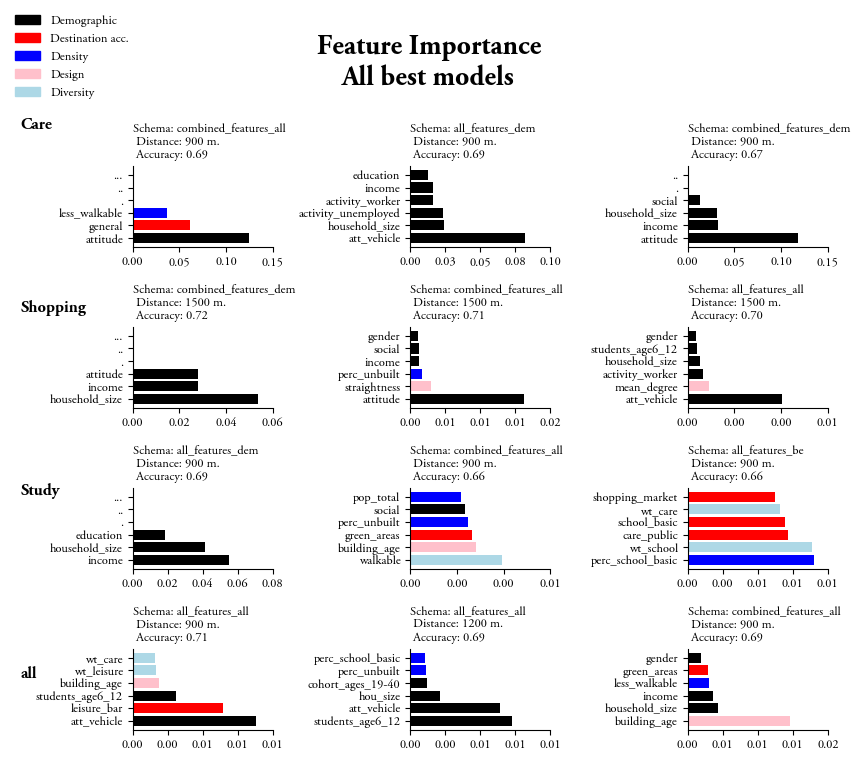

In [ ]:
plot_feature_importances(final_df_all, "Feature Importance\nAll best models",(8.5, 7.33)).savefig(r"../figures/30_feature_importance_all_2.jpg",bbox_inches='tight')

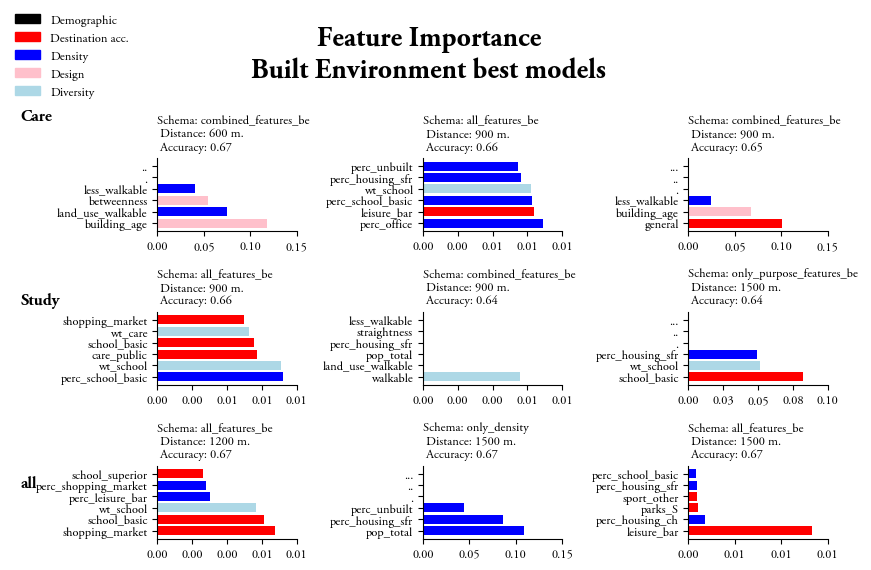

In [ ]:
plot_feature_importances(final_df_be, "Feature Importance\nBuilt Environment best models",(8.5, 5.5)).savefig(r"../figures/31_feature_importance_be_2.jpg",bbox_inches='tight')

In [35]:
final_df = pd.concat([final_df_be,final_df_all])
final_df = final_df.drop_duplicates(subset='model_name')

In [36]:
cmap = {
    'distance_threshold': 'Trip Distance',
    'trip_purpose':"Trip Purpose",
    "schema":"Schema",
    'table_size':"Table Size",
    'sample_size':"Sample Size",
    'rf_accuracy':"Accuracy",
    'true other P':"True Other TN (%)",
    'false other P':"False Other FN (%)",
    'true walking P':"True Walking TP (%)",
    'false walking P':"False Walking FP (%)"}

final_df = final_df.sort_values('rf_accuracy',ascending=False).rename(columns=cmap)[[c for c in cmap.values()]]
final_df['Sample Size'] = final_df['Sample Size'].astype(int)
final_df['True Other TN (%)'] = final_df['True Other TN (%)'].astype(int)
final_df['True Walking TP (%)'] = final_df['True Walking TP (%)'].astype(int)
final_df['False Walking FP (%)'] = final_df['False Walking FP (%)'].astype(int)
final_df['False Other FN (%)'] = final_df['False Other FN (%)'].astype(int)

final_df = final_df.replace("all","All")

In [ ]:
final_df.to_excel(r"../data/final_df.xlsx",index=False)

In [38]:
final_df

,Trip Distance,Trip Purpose,Schema,Table Size,Sample Size,Accuracy,True Other TN (%),False Other FN (%),True Walking TP (%),False Walking FP (%)
3,1500,Shopping,combined_features_dem,5074,359623,0.722,28,72,91,9
4,1500,Shopping,combined_features_all,5074,359623,0.710,27,73,91,9
9,900,All,all_features_all,18164,1344443,0.709,27,73,91,9
5,1500,Shopping,all_features_all,5074,359623,0.698,26,74,91,9
6,900,Study,all_features_dem,5580,436009,0.694,30,70,87,13
0,900,Care,combined_features_all,2964,213306,0.693,50,50,85,15
10,1200,All,all_features_all,21228,1560109,0.689,34,66,89,11
1,900,Care,all_features_dem,2964,213306,0.688,50,50,84,16
11,900,All,combined_features_all,18164,1344443,0.685,26,74,92,8
6,1200,All,all_features_be,21228,1560109,0.671,31,69,87,13
